1. Please install and enable the following extensions to correctly display this notebook:
  - [ToC2 jupyter extension](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html)
  - [Collapsible Headings](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/collapsible_headings/readme.html)
2. Python 3.8.2+ is required.
3. As the *RAD domain* was initially called *companion domain* when the research began, the variable names and section titles remained intact.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 80% !important; }</style>"))
from jupyterthemes import jtplot
jtplot.reset()
#jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)

# Preprocess

## Helper Functions

In [2]:
import multiprocessing as mp
import numpy as np
import json, datetime, dateutil, sqlite3, pickle, hashlib, re, math, bisect, random
from pathlib import Path, PosixPath
from collections import defaultdict, OrderedDict, Counter


from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from urllib.parse import urlparse as _urlparse
# https://stackoverflow.com/a/43609542/11712282
def urlparse(url):
    parsed = _urlparse(url)
    if parsed.netloc.endswith(':80'):
        parsed = parsed._replace(netloc=parsed.netloc[:-len(':80')])
    elif parsed.netloc.endswith(':443'):
        parsed = parsed._replace(netloc=parsed.netloc[:-len(':443')])
    return parsed

def parallel(func, data, process_num=None, chunksize=None, total=None, desc=None):
    process_num = mp.cpu_count() if process_num is None else process_num
    chunksize = (total // (process_num * 32) + 1) if chunksize is None else chunksize
    print(f'Parallel {process_num=} {chunksize=}')
    with mp.Pool(process_num) as p:
        for res in tqdm(p.imap_unordered(func, data, chunksize=chunksize), total=total, desc=desc):
            yield res
            
from publicsuffixlist import PublicSuffixList
psl = PublicSuffixList()

def get_ps_domain(dm):
    return psl.privatesuffix(dm)

## Data Structures

In [3]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, scoped_session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, String, Text, DateTime, Boolean

'''
+----------------+--------------+------+-----+-------------------+-------------------+
| Field          | Type         | Null | Key | Default           | Extra             |
+----------------+--------------+------+-----+-------------------+-------------------+
| id             | bigint       | NO   | PRI | NULL              | auto_increment    |
| domain         | varchar(256) | NO   | MUL | NULL              |                   |
| datetime       | datetime     | NO   |     | NULL              |                   |
| request        | longtext     | NO   |     | NULL              |                   |
| request_raw    | longtext     | NO   |     | NULL              |                   |
| initiator      | longtext     | NO   |     | NULL              |                   |
| initiator_raw  | longtext     | NO   |     | NULL              |                   |
| crawl_datetime | datetime     | NO   |     | CURRENT_TIMESTAMP | DEFAULT_GENERATED |
+----------------+--------------+------+-----+-------------------+-------------------+
2016-05-17 00:00:12 - 2020-03-28 23:57:55
'''

Base = declarative_base()
class Request(Base):
    #__tablename__ = 'requests'
    __tablename__ = 'requests_merged'
    id = Column(BigInteger, primary_key=True)
    domain = Column(String)
    request = Column(Text)
    datetime = Column(DateTime)
    initiator = Column(Text)
    blocked = Column(Boolean)
    
    def __repr__(self):
        return f'{self.domain}: {self.datetime} {self.request}'

# Thread-local Sessions object
class Session():
    def __init__(self):
        self.engine = create_engine('mysql://<redacted>/wayback_machine_crawl')
        self._Session = scoped_session(sessionmaker(bind=self.engine))
        self.session = self._Session()
    def __enter__(self):
        return self.session
    def __exit__(self, type, value, traceback):
        self.session.close()
        self._Session.remove()
        self._Session.close()
        self.engine.dispose()

In [4]:
class TrieSet:
    def __init__(self, _dms, include_subdomain=False):
        self._set = set(_dms)
        self.trie = {}
        if include_subdomain:
            dms = ['*.' + i for i in self._set] + list(self._set)
        else:
            dms = self._set
        for dm in dms:
            cur_dic = self.trie
            nodes = dm.split('.')
            if len(nodes) <= 1 or ('*' in dm and nodes[0] != '*'):
                #print('ignore', repr(dm))
                continue
            for node in reversed(nodes):
                if '*' in cur_dic:
                    cur_dic = cur_dic['*']
                    break
                if node not in cur_dic:
                    cur_dic[node] = {}
                cur_dic = cur_dic[node]
            if '.value' in cur_dic:
                pass
                #print('dup?', dm, json.dumps(cur_dic, indent=2))
            cur_dic['.value'] = True

    def __contains__(self, dm):
        cur_dic = self.trie
        nodes = dm.split('.')
        if len(nodes) <= 1 or '*' in dm:
            return False
        for node in reversed(nodes):
            if '*' in cur_dic:
                return True
            if node not in cur_dic:
                return False
            cur_dic = cur_dic[node]
        if '.value' not in cur_dic:
            return False
        assert cur_dic['.value'] == True
        return True
    
    def __iter__(self):
        return iter(self._set)

In [5]:
class TrieDict:
    def __init__(self, dm2time, include_subdomain=False):
        self._dict = dm2time
        self.trie = {}
        dm_time = list(dm2time.items())
        if include_subdomain:
            dm_time += [('*.' + dm, time) for dm, time in dm2time.items()]
        for dm, time in dm_time:
            cur_dic = self.trie
            nodes = dm.split('.')
            if len(nodes) <= 1 or ('*' in dm and nodes[0] != '*'):
                print('ignore', repr(dm))
                continue
            for node in reversed(nodes):
                if '*' in cur_dic:
                    cur_dic = cur_dic['*']
                    break
                if node not in cur_dic:
                    cur_dic[node] = {}
                cur_dic = cur_dic[node]
            #if '.value' in cur_dic:
            #    print('dup?', dm, cur_dic)
            cur_dic['.value'] = time

    def __contains__(self, dm):
        return self._getValue(dm, return_bool=True)
    
    def __getitem__(self, dm):
        v = self._getValue(dm, return_bool=False)
        if v is None:
            raise KeyError(dm)
        return v
    
    def get(self, dm, default_value=None):
        v = self._getValue(dm, return_bool=False)
        return default_value if v is None else v
    
    def _getValue(self, dm, return_bool):
        cur_dic = self.trie
        nodes = dm.split('.')
        #assert len(nodes) > 1 and '*' not in dm, 'Invalid dm ' + repr(dm)
        if len(nodes) <= 1 or '*' in dm:
            return False if return_bool else None
        for node in reversed(nodes):
            if '*' in cur_dic:
                return True if return_bool else cur_dic['*']['.value']
            if node not in cur_dic:
                return False if return_bool else None
            cur_dic = cur_dic[node]
        if '.value' not in cur_dic:
            return False if return_bool else None
        return True if return_bool else cur_dic['.value']
    
    def __iter__(self):
        return iter(self._dict)
    
    def items(self):
        return self._dict.items()
    
    def keys(self):
        return self._dict.keys()
    
    def values(self):
        return self._dict.values()

In [6]:
class PathTrie:
    V = '!@__VALUE__@!'
    def __init__(self, urls, progress=False):
        prog = tqdm if progress else lambda x: x
        self.trie = {}
        dicts = []
        for url in prog(urls):
            path = url.path
            cur_dic = self.trie
            nodes = self.getNormalizedNodes(path)
            for node in nodes:
                if node not in cur_dic:
                    cur_dic[node] = {}
                cur_dic = cur_dic[node]
                if __class__.V not in cur_dic:
                    cur_dic[__class__.V] = set()
                cur_dic[__class__.V].add(url.netloc)
                dicts.append(cur_dic)
        self.max_n = 0
        for d in dicts:
            if isinstance(d[__class__.V], int):
                continue
            l = len(d[__class__.V])
            d[__class__.V] = l
            self.max_n = max(l, self.max_n)
    
    def getNormalizedNodes(self, path):
        normalized_path = path.lstrip('/')
        if normalized_path == '':
            return ['']
        return [''] + normalized_path.split('/')
    
    def getMaxSubpath(self, path):
        cur_dic = self.trie
        normalized_path = path.lstrip('/')
        nodes = self.getNormalizedNodes(path)
        n = 0
        for node in nodes:
            if node not in cur_dic:
                break
            n += 1
            cur_dic = cur_dic[node]
        return nodes[:n], cur_dic.get(__class__.V, 0)

## Load Data

In [7]:
data_dir = Path('data')
to_load_data = '''
# dm2cert_names
# dm2dns
# url2response
# dm2whois

# dm2info_with_initiator # 61 G memory
dm2info # 26.4 G memory
# site2time_parsed # 22.6 G memory

dm2related_ads 
all_path_trie
# site2ad_parsed2t
dm2dns
#dm2subj
dm2trackingradar
#dm2contents
dm_pair2jaccard_similarity
'''.strip().splitlines()

for to_load_datum in to_load_data:
    var, _, _ = to_load_datum.strip().partition('#')
    var = var.strip()
    if var.startswith('#') or var == '':
        continue
    if var in globals():
        print(var, 'is already loaded...... skip')
    else:
        print('Loading', var, '......')
        exec(f'{var} = pickle.loads(Path(data_dir / (var + ".pickle")).read_bytes())') 
        print('Loading', var, '......', 'done')
        if var == 'dm2info_with_initiator':
            dm2info = dm2info_with_initiator

Loading dm2info ......
Loading dm2info ...... done
Loading dm2related_ads ......
Loading dm2related_ads ...... done
Loading all_path_trie ......
Loading all_path_trie ...... done
Loading dm2dns ......
Loading dm2dns ...... done
Loading dm2trackingradar ......
Loading dm2trackingradar ...... done
Loading dm_pair2jaccard_similarity ......
Loading dm_pair2jaccard_similarity ...... done


# Turing Parameters

## URL Similarity and Time Constraint 

### Choose parameters in URL similarity

#### Path

In [177]:
import sys
sys.setrecursionlimit(0x100000)
def parse(trie):
    _counts = []
    for k, v in trie.items():
        if k == '!@__VALUE__@!':
            _counts.append(v)
            continue
        _counts += parse(v)
    return _counts
            
counts = parse(all_path_trie.trie)
counts.sort()
print(len(counts))

43247537


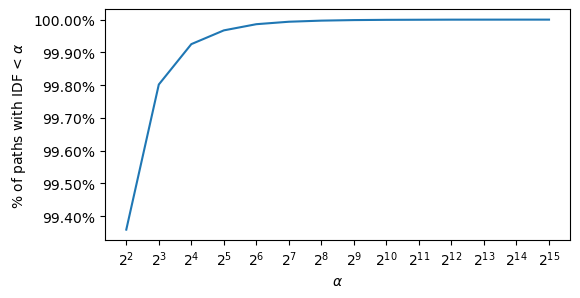

In [242]:
import matplotlib.ticker as mtick
figure, ax = plt.subplots(figsize=(6,3))
ys = list(range(2, 16))
ax.plot(ys, [
    bisect.bisect_left(counts, 2**y) / len(counts)
    for y in ys
])
#ax.set_yscale('log')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(lambda x, pos: f'$2^{{' + str(x) + f'}}$')
ax.set_xticks(ys)
ax.set_ylabel(r'% of paths with IDF < $\alpha$')
ax.set_xlabel(r'$\alpha$')
figure.savefig('figures/path-idf.pdf', bbox_inches='tight')
figure

In [ ]:
for i in range(7, 15):
    print(i)
    for k, v in all_path_trie.trie[''].items():
        if k == '!@__VALUE__@!':
            continue
        if 2**i <= v['!@__VALUE__@!'] <= 2**(i+1):
            print('  ', k, v['!@__VALUE__@!'])

#### URL

In [ ]:
from itertools import product
import numpy as np
_, OKAPI_N = all_path_trie.getMaxSubpath('/')

def get_longest_common_path(p0, p1):
    p0 = ('' if p0.startswith('/') else '/') + p0.rstrip('/')
    p1 = ('' if p1.startswith('/') else '/') + p1.rstrip('/')
    nodes = []
    for n0, n1 in zip(p0.split('/'), p1.split('/')):
        if n0 != n1:
            break
        nodes.append(n0)
    return '/'.join(nodes)

def get_longest_common_path_and_distance(p0, p1):
    common_path = get_longest_common_path(p0, p1)
    p, count = all_path_trie.getMaxSubpath(common_path)
    return common_path, count

def get_similar_paths(netloc0, netloc1):
    p0s = dm2info[netloc0]['paths'] if netloc0 in dm2info else set()
    p1s = dm2info[netloc1]['paths'] if netloc1 in dm2info else set()
    #results = set()
    results = {'p0': set(), 'p1': set()}
    if not p0s or not p1s:
        return results
    for p0 in p0s:
        min_common_path, min_distance = min(
            (get_longest_common_path_and_distance(p0, p1) for p1 in p1s),
            key=lambda path_distance: path_distance[1]
        )
        results['p0'].add((min_common_path, min_distance))
    for p1 in p1s:
        min_common_path, min_distance = min(
            (get_longest_common_path_and_distance(p0, p1) for p0 in p0s),
            key=lambda path_distance: path_distance[1]
        )
        results['p1'].add((min_common_path, min_distance))
    return results

def are_satifying_time_constraint(this_info, ad_info):
    this_dm_ts = [r['blocked_t'] for r in this_info['requests'] if r['is_ad']]
    ad_dm_ts = [r['blocked_t'] for r in ad_info['requests'] if r['is_ad']]
    
    '''it's not a ad domain'''
    if not ad_dm_ts:
        return False
    '''ad domain appear after evading domain'''
    if this_info['first_appear'] < ad_info['first_appear']:
        return False
    '''two domains are blocked at the same time'''
    if min(this_dm_ts, default=-1) == min(ad_dm_ts):
        return False
    return True

In [ ]:
def func(this_dm):
    data = []
    similar_ad_dms = dm2related_ads[this_dm]
    for ad_dm, reasons in similar_ad_dms.items():
        '''identical domain'''
        if this_dm == ad_dm:
            continue
        '''no path info'''
        if this_dm not in dm2info or ad_dm not in dm2info:
            continue
    
        this_info, ad_info = dm2info[this_dm], dm2info[ad_dm]
        
        if not are_satifying_time_constraint(this_info, ad_info):
            continue
            
        '''the urls of two domain is not similar'''
        sim_paths = get_similar_paths(this_dm, ad_dm)
        data.append((this_dm, ad_dm, sim_paths))
    return data

parameter_suspects = []
n = len(dm2related_ads)
dms = list(dm2related_ads)
random.shuffle(dms)
for data in parallel(func, dms[:n], chunksize=16, total=n):
    parameter_suspects += data

In [13]:
from functools import partial

def logMax(sim_paths, alpha):
    return max(
        sum(max(0, alpha - (math.log2(distance))) for path, distance in sim_paths['p1']),
        sum(max(0, alpha - (math.log2(distance))) for path, distance in sim_paths['p0'])
    )

def okapiLogMax(sim_paths, alpha):
    return max(
        sum(
            np.log2(OKAPI_N / distance)
            for path, distance in sim_paths['p1'] if distance <= 2** alpha
        ),
        sum(
            np.log2(OKAPI_N / distance)
            for path, distance in sim_paths['p0'] if distance <= 2** alpha
        )
    )
def okapiBM25LogMax(sim_paths, alpha):
    return max(
        sum(
            np.log2((OKAPI_N-distance +0.5) / (distance+0.5) + 1)
            for path, distance in sim_paths['p1'] if distance <= 2** alpha
        ),
        sum(
            np.log2((OKAPI_N-distance +0.5) / (distance+0.5) + 1)
            for path, distance in sim_paths['p0'] if distance <= 2** alpha
        )
    )
    

name2formula = {
    **{
        f'logMax Alpha {i}': partial(logMax, alpha=i)
        for i in [8, 10, 12]
    }, **{
        f'okapi Log Max Alpha {i}': partial(okapiLogMax, alpha=i)
        for i in [8, 10, 12]
    }, **{
        f'okapi bm25 log Max Alpha {i}': partial(okapiBM25LogMax, alpha=i)
        for i in [8, 10, 12]
    }
}

name2dm2s = {name: {} for name in name2formula}

for this_dm, ad_dm, sim_paths in tqdm(parameter_suspects):
    for name, formula in name2formula.items():
        s = formula(sim_paths)
        if this_dm not in name2dm2s[name]:
            name2dm2s[name][this_dm] = s
        name2dm2s[name][this_dm] = max(name2dm2s[name][this_dm], s)

  0%|          | 0/711260 [00:00<?, ?it/s]

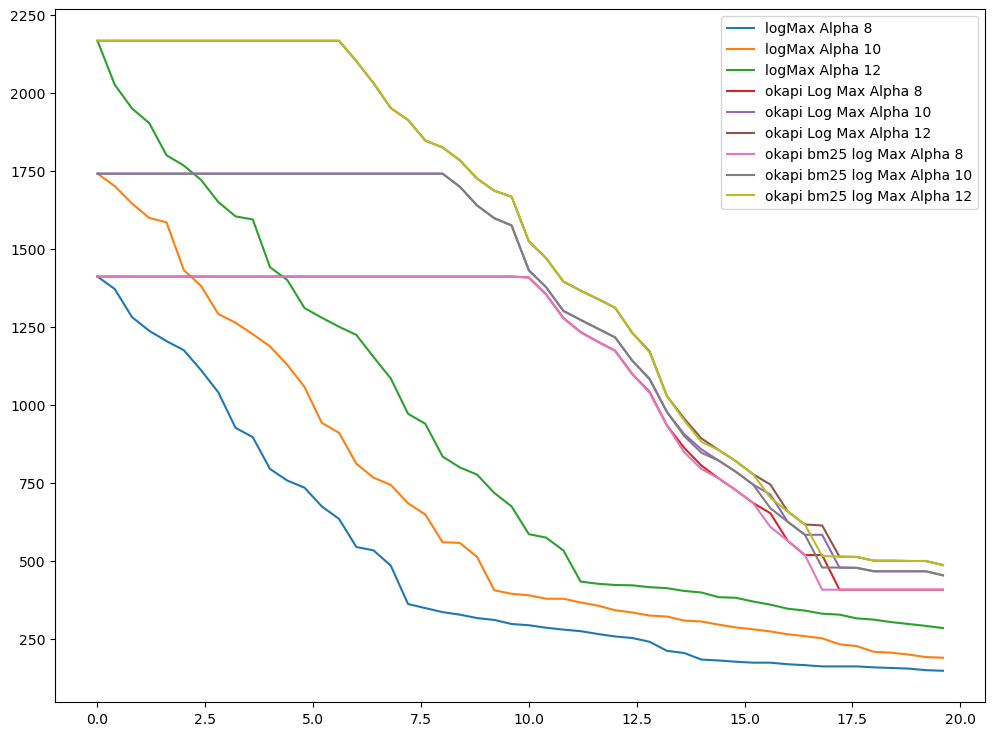

In [14]:
figure, ax = plt.subplots(figsize=(12,9))
for name, this_dm2s in name2dm2s.items():
    #if name.startswith('okapi') and 'bm25' in name:
    #    continue
    xs = sorted([s for this_dm, s in this_dm2s.items()])
    ys = list(np.linspace(1e-10, 20, 50, endpoint=False))
    ax.plot(ys, [
        len(xs) - bisect.bisect_left(xs, y)
        for y in ys
    ], label=name)
ax.legend()
figure

In [15]:
'''
def func(this_dm):
    data = []
    similar_ad_dms = dm2related_ads[this_dm]
    for ad_dm, reasons in similar_ad_dms.items():
        #identical domain
        if this_dm == ad_dm:
            continue
        #no path info
        if this_dm not in dm2info or ad_dm not in dm2info:
            continue
    
        this!@__VALUE__@!_info, ad_info = dm2info[this_dm], dm2info[ad_dm]
        
        #if not are_satifying_time_constraint(this_info, ad_info):
        #    continue
            
        #the urls of two domain is not similar
        sim_paths = get_similar_paths(this_dm, ad_dm)
        v = sum(sim for p, sim in sim_paths)
        #if v < 1:
        #    continue
        data.append((this_dm, ad_dm, v))
    return data

alpha = 4.42
del alpha

figure, ax = plt.subplots()

if 'alpha' not in globals():
    parameter_suspects = []
    n = len(dm2related_ads)
    dms = list(dm2related_ads)
    random.shuffle(dms)
    for data in parallel(func, dms[:n], chunksize=8, total=n):
        parameter_suspects += data
    this_dm2max_s = {}
    #ps_dm2max_s = {}
    for this_dm, ad_dm, s in tqdm(parameter_suspects):
        this_dm2max_s[this_dm] = max(this_dm2max_s.get(this_dm, 0), s)
        #ps_dm = get_ps_domain(this_dm)
        #ps_dm2max_s[ps_dm] = max(ps_dm2max_s.get(ps_dm, 0), s)

    xs = sorted([max_s for this_dm, max_s in this_dm2max_s.items()])
    ys = list(np.linspace(1, 10, 100, endpoint=False))

    
    ax.plot(ys, [
        (bisect.bisect_left(xs, last_y) - bisect.bisect_left(xs, y))
        - (bisect.bisect_left(xs, last_last_y) - bisect.bisect_left(xs, last_y))
        for last_last_y, last_y, y in zip([-2, -1] + ys, [-1] + ys, ys)
    ], label="f'2")
    
    min_x, min_y = min(list(zip(ys, [
        bisect.bisect_left(xs, last_y) - bisect.bisect_left(xs, y)
        for last_y, y in zip([-1] + ys, ys)
    ])),key=lambda x: x[1])
    ax.plot(min_x, min_y, 'ro', label=r'$\alpha = ' + str(min_x) + '$')
else:
    ys = list(np.linspace(1, 10, 100, endpoint=False))
    #f0 = [23610, 23610, 23610, 23610, 23610, 23610, 23610, 23610, 23610, 23610, 23610, 23610, 23610, 23610, 23610, 23610, 23610, 23610, 23204, 23204, 22450, 22450, 22450, 22426, 22426, 22334, 21802, 21802, 21723, 21328, 21075, 20989, 20989, 20989, 20958, 20923, 20923, 20923, 19363, 18031, 17946, 17924, 17924, 17017, 17010, 17000, 16963, 16868, 16811, 16747, 16339, 16216, 16198, 16052, 15708, 15345, 14981, 14915, 14882, 14728, 14295, 14156, 13749, 13611, 13459, 13416, 13234, 13214, 13073, 13018, 12892, 12678, 12589, 12560, 12531, 12316, 12243, 12142, 12058, 11964, 11927, 11823, 11669, 11602, 11502, 11386, 11274, 11117, 11031, 10934, 10787, 10719, 10639, 10520, 10426, 10414, 10251, 10086, 9910, 9901]
    f1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -406, 0, -754, 0, 0, -24, 0, -92, -532, 0, -79, -395, -253, -86, 0, 0, -31, -35, 0, 0, -1560, -1332, -85, -22, 0, -907, -7, -10, -37, -95, -57, -64, -408, -123, -18, -146, -344, -363, -364, -66, -33, -154, -433, -139, -407, -138, -152, -43, -182, -20, -141, -55, -126, -214, -89, -29, -29, -215, -73, -101, -84, -94, -37, -104, -154, -67, -100, -116, -112, -157, -86, -97, -147, -68, -80, -119, -94, -12, -163, -165, -176, -9]
    f2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -406, 406, -754, 754, 0, -24, 24, -92, -440, 532, -79, -316, 142, 167, 86, 0, -31, -4, 35, 0, -1560, 228, 1247, 63, 22, -907, 900, -3, -27, -58, 38, -7, -344, 285, 105, -128, -198, -19, -1, 298, 33, -121, -279, 294, -268, 269, -14, 109, -139, 162, -121, 86, -71, -88, 125, 60, 0, -186, 142, -28, 17, -10, 57, -67, -50, 87, -33, -16, 4, -45, 71, -11, -50, 79, -12, -39, 25, 82, -151, -2, -11, 167]
    min_xy = (4.42, -1560)
    #ax.plot(ys, f0, label="f'0")
    ax.plot(ys, f1, label="f'1")
    ax.plot(ys, f2, label="f'2")
    ax.plot(*min_xy, 'ro', label=r'$\alpha = ' + str(min_x) + '$')
    ax.set_title(r"$\alpha = 4.42$")

ax.grid()
ax.legend()    
figure
''';

## File content similarity

In [441]:
def get_content_jaccard_similarity(netloc0, netloc1):
    if netloc0 not in dm2contents or netloc1 not in dm2contents:
        return 0
    if len(dm2contents[netloc0] | dm2contents[netloc1]) == 0:
        return 0
    return len(dm2contents[netloc0] & dm2contents[netloc1]) / len(dm2contents[netloc0] | dm2contents[netloc1])

In [442]:
import csv
import itertools
dm2contents = pickle.loads(Path('./data/dm2contents.pickle').read_bytes())
def load_labeled_data(filename):
    is_dpdm = set()
    with open(filename) as f:
        reader = list(csv.reader(f, delimiter=',', quotechar='"'))
    labeled_dm2is_ad = {}
    for l in reader[1:]:
        is_ad, why, ad_dm, this_dm = bool(l[1] == 'v'), l[9], l[3], l[4]
        if is_ad:
            is_dpdm.add((ad_dm, this_dm))
    return is_dpdm

random.seed(1234)
dpdm_p = random.sample(load_labeled_data('./suspected_v1.csv'), 100)
rddm_p = [ (k, random.sample(list(dm2related_ads[k]), 1)[0]) for k in random.sample(list(dm2related_ads.keys()), 100) ]
popdm_p = [ random.sample(list(dm2contents.keys()), 2) for i in range(100) ]

In [443]:
dpdm_p_js = [ get_content_jaccard_similarity(p[0], p[1]) for p in dpdm_p ]
rddm_p_js = [ get_content_jaccard_similarity(p[0], p[1]) for p in rddm_p ]
popdm_p_js = [ get_content_jaccard_similarity(p[0], p[1]) for p in popdm_p ]

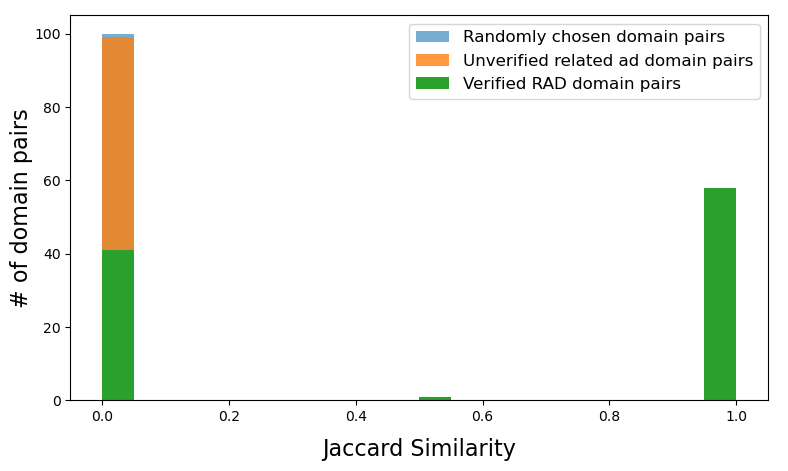

In [444]:
import numpy as np

dpdm_p_js = [ get_content_jaccard_similarity(p[0], p[1]) for p in dpdm_p ]
popdm_p_js = [ get_content_jaccard_similarity(p[0], p[1]) for p in popdm_p ]

figure, ax_hist = plt.subplots(1, figsize=(9, 5), sharex=True, gridspec_kw={
    "hspace":0
})
ax_hist.hist(popdm_p_js, bins=np.linspace(0, 1, 21), label="Randomly chosen domain pairs", alpha=0.6)
ax_hist.hist(rddm_p_js, bins=np.linspace(0, 1, 21), label="Unverified related ad domain pairs", alpha=0.8)
ax_hist.hist(dpdm_p_js, bins=np.linspace(0, 1, 21), label="Verified RAD domain pairs", alpha=1)
ax_hist.legend(fontsize=12)

# https://stackoverflow.com/a/53172335/11712282
ax = figure.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_ylabel("# of domain pairs", fontsize=16)
ax.set_xlabel("Jaccard Similarity", labelpad=10, fontsize=16)

figure.savefig('figures/file-similarity.pdf', bbox_inches='tight')
figure

# Companion domains

## Content similarity

In [8]:
sum([sum([ len(v_) for v_ in v.values() ]) for v in list(dm2dns.values()) ]), len(dm2dns.keys())

(812867, 309921)

In [9]:
from itertools import product
import numpy as np

# https://raw.githubusercontent.com/xajkep/wordlists/master/discovery/directory_only_one.small.txt
common_directory = set()
with open('./data/common.txt', 'r') as f:
    for l in f.readlines():
        common_directory.add('/' + l.strip().strip('/'))

def get_longest_common_path(p0, p1):
    p0 = ('' if p0.startswith('/') else '/') + p0.rstrip('/')
    p1 = ('' if p1.startswith('/') else '/') + p1.rstrip('/')
    nodes = []
    for n0, n1 in zip(p0.split('/'), p1.split('/')):
        if n0 != n1:
            break
        nodes.append(n0)
    return '/'.join(nodes)

def get_longest_common_path_and_distance(p0, p1):
    common_path = get_longest_common_path(p0, p1)
    p, count = all_path_trie.getMaxSubpath(common_path)
    return common_path, count

def get_similar_paths(netloc0, netloc1):
    p0s = dm2info[netloc0]['paths'] if netloc0 in dm2info else set()
    p1s = dm2info[netloc1]['paths'] if netloc1 in dm2info else set()
    results = set()
    if not p0s or not p1s:
        return results
    p0_results, p1_results = set(), set()
    for p0 in p0s:
        min_common_path, min_distance = min(
            (get_longest_common_path_and_distance(p0, p1) for p1 in p1s),
            key=lambda path_distance: path_distance[1]
        )
        p0_results.add((min_common_path, min_distance))
        if min_common_path not in common_directory:
            p0_results.add((min_common_path, min_distance))
    for p1 in p1s:
        min_common_path, min_distance = min(
            (get_longest_common_path_and_distance(p0, p1) for p0 in p0s),
            key=lambda path_distance: path_distance[1]
        )
        p1_results.add((min_common_path, min_distance))
        if min_common_path not in common_directory:
            p1_results.add((min_common_path, min_distance))
    alpha = 10
    s = max(
        sum(max(0, alpha - (math.log2(distance))) for path, distance in p0_results),
        sum(max(0, alpha - (math.log2(distance))) for path, distance in p1_results)
    )
    if s > 0:
        return p0_results | p1_results
    return None

In [10]:
def get_content_jaccard_similarity(netloc0, netloc1):
    if netloc0 in dm_pair2jaccard_similarity and netloc1 in dm_pair2jaccard_similarity[netloc0]:
        return dm_pair2jaccard_similarity[netloc0][netloc1]
    
    if netloc1 in dm_pair2jaccard_similarity and netloc0 in dm_pair2jaccard_similarity[netloc1]:
        return dm_pair2jaccard_similarity[netloc1][netloc0]

    return 0

    """
    if netloc0 not in dm2contents or netloc1 not in dm2contents:
        return 0
    if len(dm2contents[netloc0] | dm2contents[netloc1]) == 0:
        return 0
    return len(dm2contents[netloc0] & dm2contents[netloc1]) / len(dm2contents[netloc0] | dm2contents[netloc1])
    """

In [11]:
def func(this_dm):
    data = []
    similar_ad_dms = dm2related_ads[this_dm]
    for ad_dm, reasons in similar_ad_dms.items():
        '''the domains have to be different'''
        if not (this_dm != ad_dm):
            continue
        if this_dm == "www." + ad_dm or ad_dm == "www." + this_dm:
            continue
        
        '''We must have path info for both'''
        if not (this_dm in dm2info and ad_dm in dm2info):
            continue
        
        this_info, ad_info = dm2info[this_dm], dm2info[ad_dm]
        
        '''ad domain has to send at least one ad request'''
        if not (any(r['is_ad'] for r in ad_info['requests'])):
            continue
            
        '''the urls or contents of two domains should be similar'''
        sim_paths = get_similar_paths(this_dm, ad_dm)
        sim_contents = get_content_jaccard_similarity(this_dm, ad_dm)
        if sim_paths is None and sim_contents < 0.7:
            continue
            
        data.append((
            this_dm,
            ad_dm,
            sorted(set(sim_paths), key=lambda path_idf: path_idf[1]) if sim_paths is not None else [],
            sim_contents >= 0.7
        ))
    return data        

cache = Path('cache/suspects_v4_no_time_cons_tmp.pickle')
if cache.is_file():
    suspects = pickle.loads(cache.read_bytes())
else:
    suspects = []
    n = len(dm2related_ads)
    for data in parallel(func, list(dm2related_ads)[:n], total=n):
        suspects += data
    cache.write_bytes(pickle.dumps(suspects))
len(suspects), len({this_dm for this_dm,_,_,_ in suspects})

(162684, 6465)

## Timeline constraint

In [12]:
done = []
for this_dm, ad_dm, sim_paths, file_jc_sims in tqdm(suspects):
    this_info, ad_info = dm2info[this_dm], dm2info[ad_dm]
    
    '''without loss of generality, ad domain has to appear before evading domain'''
    #if not (ad_info['first_appear'] < this_info['first_appear']):
    #    continue
        
    this_dm_t = min([int(r['blocked_t']) for r in this_info['requests'] if r['is_ad']], default=float('inf'))
    ad_dm_t = min([int(r['blocked_t']) for r in ad_info['requests'] if r['is_ad']])
    
    '''ad domain has to be blocked (strictly) first'''
    #if not (ad_dm_t < this_dm_t):
    #    continue
    
    '''companion domain must not be blocked when first appear'''
    if not (this_info['first_appear'] <= this_dm_t):
        continue
    
    done.append((this_dm, ad_dm, sim_paths, file_jc_sims))
print(len({this_dm for this_dm, _, _, _ in done}))

suspects = done

  0%|          | 0/162684 [00:00<?, ?it/s]

2313


## Results

We totally crawled 252601 uniq domains with 49490 uniq ad domains


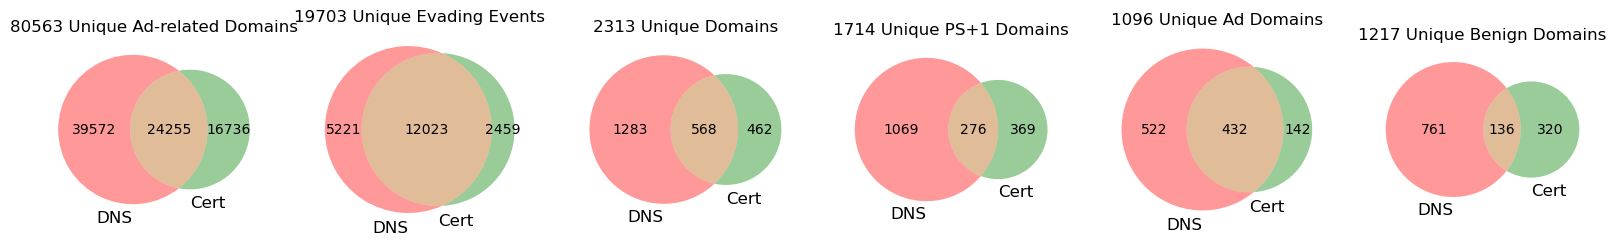

In [13]:
from matplotlib_venn import venn2, venn3

reasons = ['dns', 'cert']
labels = ['DNS', 'Cert']

reason2dms = {reason: set() for reason in reasons}
reason2ps_dms = {reason: set() for reason in reasons}
reason2dm_pairs = {reason: set() for reason in reasons}
reason2ad_dms = {reason: set() for reason in reasons}
reason2benign_dms = {reason: set() for reason in reasons}

for this_dm, ad_dm, _, _ in suspects:
    for reason in dm2related_ads[this_dm][ad_dm]:
        if any(r['is_ad'] for r in dm2info[this_dm]['requests']):
            reason2ad_dms[reason].add(this_dm)
        else:
            reason2benign_dms[reason].add(this_dm)
        reason2dms[reason].add(this_dm)
        reason2ps_dms[reason].add(get_ps_domain(this_dm))
        reason2dm_pairs[reason].add((this_dm, ad_dm))

figure, axes = plt.subplots(1, 6, figsize=(20,6))
venn2([
    {
        dm
        for dm, ads in dm2related_ads.items()
        if any(reason in _reasons for ad_dm, _reasons in ads.items())
    } 
    for reason in reasons
], labels, ax=axes[0])
axes[0].set_title(str(len(dm2related_ads)) + ' Unique Ad-related Domains')

def sum_all(reason2sets):
    al = set()
    for _, s in reason2sets.items():
        al.update(s)
    return len(al)

print(
    'We totally crawled', len(dm2info), 'uniq domains',
    'with', len({dm for dm, info in dm2info.items() if any(r['is_ad'] for r in info['requests'])}),
    'uniq ad domains'
)

venn2([reason2dm_pairs[reason] for reason in reasons], labels, ax=axes[1])
axes[1].set_title(str(sum_all(reason2dm_pairs)) + ' Unique Evading Events')
venn2([reason2dms[reason] for reason in reasons], labels, ax=axes[2])
axes[2].set_title(str(sum_all(reason2dms)) + ' Unique Domains')
venn2([reason2ps_dms[reason] for reason in reasons], labels, ax=axes[3])
axes[3].set_title(str(sum_all(reason2ps_dms)) + ' Unique PS+1 Domains')
venn2([reason2ad_dms[reason] for reason in reasons], labels, ax=axes[4])
axes[4].set_title(str(sum_all(reason2ad_dms)) + ' Unique Ad Domains')
venn2([reason2benign_dms[reason] for reason in reasons], labels, ax=axes[5])
axes[5].set_title(str(sum_all(reason2benign_dms)) + ' Unique Benign Domains')
figure

In [ ]:
import pandas as pd
from random import randint

t2s = lambda t: datetime.date.fromtimestamp(int(t)).isoformat()
done = set()
last_index = 0

def row_filter(row):
    this_dm, ad_dm, sim_paths = row
    #if len(dm2related_ads[this_dm][ad_dm]) <= 2:
    #    return False
    #this_dm_ts = [r['blocked_t'] for r in dm2info[this_dm]['requests'] if r['is_ad']]
    #if this_dm_ts:
    #    return False
    #ad_dm_ts = [r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]
    #if not this_dm_ts:
    #    return False
    #if min(this_dm_ts) >= min(ad_dm_ts):
    #    return False
    #return not (
    #    min(this_dm_ts) < dm2info[this_dm]['first_appear']
    #    or min(ad_dm_ts) < dm2info[ad_dm]['first_appear']
    #)
    return True

def row_convert(_row):
    this_dm, ad_dm, sim_paths = list(_row)
    this_dm_ts = [r['blocked_t'] for r in dm2info[this_dm]['requests'] if r['is_ad']]
    ad_dm_ts = [r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]

    global last_index
    last_index = 0 if this_dm not in done else (last_index+1)
    done.add(this_dm)
    return [
        ('Is ad', 'v' if this_dm_ts or labeled_dm2is_ad.get(this_dm, False) or this_dm in previous_labeled_true else ('x' if labeled_dm2is_ad.get(this_dm, True) == False or this_dm in previous_labeled_false else '')),
        #('Is ad', 'v' if this_dm_ts else ''),
        ('', last_index),
        ('Related ad domain', ad_dm),
        ('Suspect domain', this_dm),
        ('Ad blocked', t2s(min(ad_dm_ts))),
        ('Suspect blocked', t2s(min(this_dm_ts)) if this_dm_ts else 'X'),
        ('Ad first appear', t2s(dm2info[ad_dm]['first_appear'])),
        ('Suspect first appear', t2s(dm2info[this_dm]['first_appear'])),
        ('Related reasons', ','.join(dm2related_ads[this_dm][ad_dm])),
        ('Similar paths', ', '.join(f"{path} ({round(sim, 2)})" for path, sim in sim_paths[:3]))
    ]

df = [row_convert(row) for row in tqdm(suspects) if row_filter(row)]
df = pd.DataFrame([[v for k, v in row] for row in df], columns=[k for k, v in df[0]])#.sample(100)
print(df.shape[0], len({i for i in df['Suspect domain']}))

display(df.sample(10))

#df.to_csv("suspected_v3.csv")

## Sample

$$n = \frac{1}{\frac{1}{N} + \frac{D^2}{Z^2p(1-p)}}$$
- D: error
- Z: 1.96 for 95% confidence
- p(1-p) : 0.5 to maxmize
- n: sampling num
- N: population num

In [14]:
import csv
has_labeled = set()
def load_labeled_data(filename):
    global has_labeled
    with open(filename) as f:
        reader = list(csv.reader(f, delimiter='\t', quotechar='"'))
    labeled_dm2is_ad = {}
    for l in reader[1:]:
        is_ad, why, ad_dm, this_dm = bool(l[1].lower().strip() == 'v'), l[9], l[3], l[4]
        #(this_dm, ad_dm, sim_paths)
        is_in_suspect = False
        for s in suspects:
            if s[0] == this_dm and s[1] == ad_dm:
                is_in_suspect = True
                
        if bool(l[6] == 'X') and is_in_suspect:
            labeled_dm2is_ad[this_dm] = is_ad
        has_labeled.add((this_dm, ad_dm))
    return labeled_dm2is_ad

labeled_dm2is_ad = load_labeled_data('./suspected_v5-labeled.csv')

In [15]:
for s in suspects:
    if (s[0], s[1]) not in has_labeled:
        print(s)

In [16]:
suspect_labeled = []
for this_dm, ad_dm,_,_ in suspects:
    suspect_labeled.append({
        'suspect_dm': this_dm,
        'ad_dm': ad_dm,
        'suspect_dm_manual_label_is_ad': labeled_dm2is_ad.get(this_dm, None)
    })
#Path('cache/suspect_labeled_v2.pickle').write_bytes(pickle.dumps(suspect_labeled))

In [17]:
print("labeled:", len(set([s['suspect_dm'] for s in suspect_labeled if s['suspect_dm_manual_label_is_ad'] is not None])))
print("labeled as ad:", len(set([s['suspect_dm'] for s in suspect_labeled if s['suspect_dm_manual_label_is_ad'] == True])))
print("ratio:", len(set([s['suspect_dm'] for s in suspect_labeled if s['suspect_dm_manual_label_is_ad'] == True])) / len(set([s['suspect_dm'] for s in suspect_labeled if s['suspect_dm_manual_label_is_ad'] is not None])))

labeled: 1217
labeled as ad: 652
ratio: 0.5357436318816763


# General

## General Statistics

In [18]:
companions = [
    (this_dm, ad_dm, sim_paths, file_jc_sim)
    for this_dm, ad_dm, sim_paths, file_jc_sim in suspects
    if any(r['is_ad'] for r in dm2info[this_dm]['requests']) or (
        labeled_dm2is_ad.get(this_dm, False)
    )
]
len({this_dm for this_dm, _, _, _ in companions})
#suspects = None

1748

In [19]:
#[reason2dms[reason] for reason in reasons]

['dns', 'cert']
[81.92, 48.57]
[87.04, 52.37]
[73.31, 42.18]


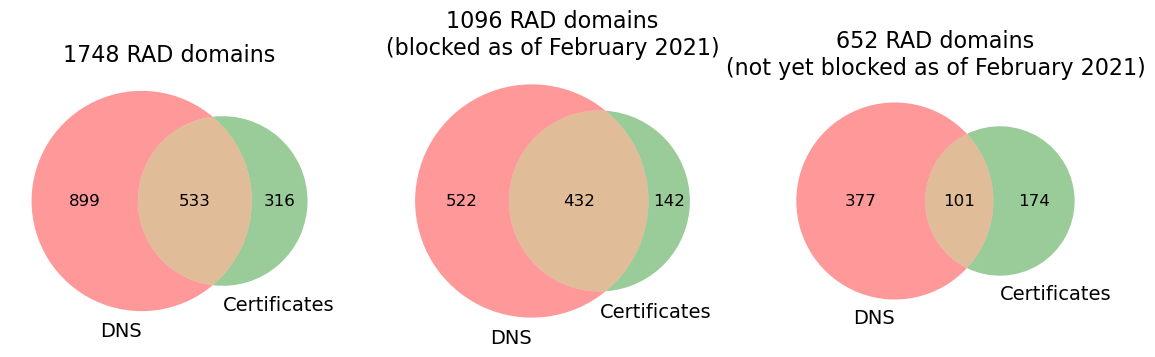

In [163]:
figure, axes = plt.subplots(1, 3, figsize=(14, 8))
venns = []
# reasons = ['dns', 'fp', 'cert']
# labels = ['DNS', 'Responses', 'Certificates']
reasons = ['dns', 'cert']
labels = ['DNS', 'Certificates']

reason2dms = {reason: set() for reason in reasons}
reason2ps_dms = {reason: set() for reason in reasons}
reason2dm_pairs = {reason: set() for reason in reasons}
reason2ad_dms = {reason: set() for reason in reasons}
reason2benign_dms = {reason: set() for reason in reasons}

for this_dm, ad_dm, _, _ in companions:
    for reason in dm2related_ads[this_dm][ad_dm]:
        if any(r['is_ad'] for r in dm2info[this_dm]['requests']):
            reason2ad_dms[reason].add(this_dm)
        else:
            reason2benign_dms[reason].add(this_dm)
        reason2dms[reason].add(this_dm)
        reason2ps_dms[reason].add(get_ps_domain(this_dm))
        reason2dm_pairs[reason].add((this_dm, ad_dm))

venns.append(venn2([reason2dms[reason] for reason in reasons], labels, ax=axes[0]))
axes[0].set_title(str(sum_all(reason2dms)) + ' RAD domains')
venns.append(venn2([reason2ad_dms[reason] for reason in reasons], labels, ax=axes[1]))
axes[1].set_title(str(sum_all(reason2ad_dms)) + ' RAD domains\n(blocked as of February 2021)')
venns.append(venn2([reason2benign_dms[reason] for reason in reasons], labels, ax=axes[2]))
axes[2].set_title(str(sum_all(reason2benign_dms)) + ' RAD domains\n(not yet blocked as of February 2021)')

for venn in venns:
    for text in venn.set_labels:
        text.set_fontsize(14)
    for text in venn.subset_labels:
        if text is not None:
            text.set_fontsize(12)
for ax in axes:
    ax.title.set_fontsize(16)

print(reasons)
print([round(len(reason2dms[reason])/sum_all(reason2dms) * 100,2) for reason in reasons])
print([round(len(reason2ad_dms[reason])/sum_all(reason2ad_dms) * 100,2) for reason in reasons])
print([round(len(reason2benign_dms[reason])/sum_all(reason2benign_dms) * 100,2) for reason in reasons])
figure.savefig('figures/footprint-venn.pdf', bbox_inches='tight')
figure

['dns', 'cert']
[89.65, 22.14]
[87.32, 23.36]
[93.56, 20.09]


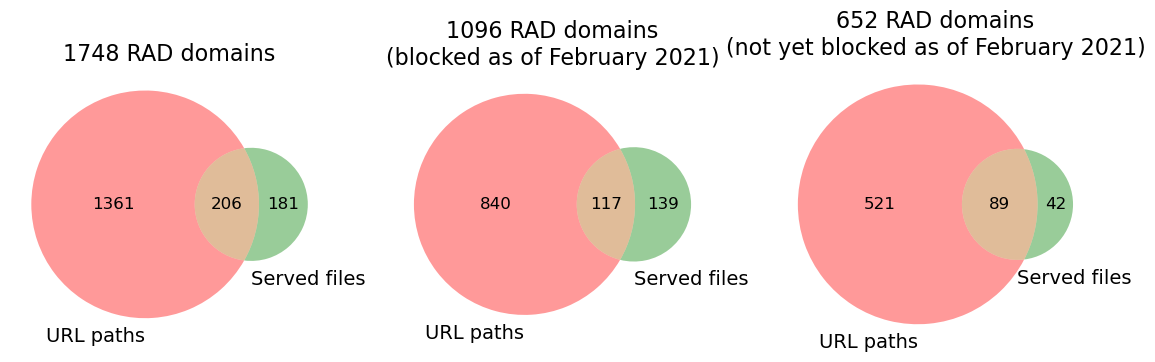

In [164]:
figure, axes = plt.subplots(1, 3, figsize=(14, 8))
venns = []
# reasons = ['dns', 'fp', 'cert']
# labels = ['DNS', 'Responses', 'Certificates']
link_reasons = ['paths', 'file']
link_labels = ['URL paths', 'Served files']

link_reason2dms = {reason: set() for reason in link_reasons}
link_reason2ps_dms = {reason: set() for reason in link_reasons}
link_reason2dm_pairs = {reason: set() for reason in link_reasons}
link_reason2ad_dms = {reason: set() for reason in link_reasons}
link_reason2benign_dms = {reason: set() for reason in link_reasons}

for this_dm, ad_dm, sim_path, file_jc_sim in companions:
    dm_reasons = []
    if len(sim_path) > 0:
        dm_reasons.append('paths')
    if file_jc_sim:
        dm_reasons.append('file')
        
    for reason in dm_reasons:
        if any(r['is_ad'] for r in dm2info[this_dm]['requests']):
            link_reason2ad_dms[reason].add(this_dm)
        else:
            link_reason2benign_dms[reason].add(this_dm)
        link_reason2dms[reason].add(this_dm)
        link_reason2ps_dms[reason].add(get_ps_domain(this_dm))
        link_reason2dm_pairs[reason].add((this_dm, ad_dm))


venns.append(venn2([link_reason2dms[reason] for reason in link_reasons], link_labels, ax=axes[0]))
axes[0].set_title(str(sum_all(link_reason2dms)) + ' RAD domains')
venns.append(venn2([link_reason2ad_dms[reason] for reason in link_reasons], link_labels, ax=axes[1]))
axes[1].set_title(str(sum_all(link_reason2ad_dms)) + ' RAD domains\n(blocked as of February 2021)')
venns.append(venn2([link_reason2benign_dms[reason] for reason in link_reasons], link_labels, ax=axes[2]))
axes[2].set_title(str(sum_all(link_reason2benign_dms)) + ' RAD domains\n(not yet blocked as of February 2021)')

for venn in venns:
    for text in venn.set_labels:
        text.set_fontsize(14)
    for text in venn.subset_labels:
        if text is not None:
            text.set_fontsize(12)
for ax in axes:
    ax.title.set_fontsize(16)

print(reasons)
print([round(len(link_reason2dms[reason])/sum_all(link_reason2dms) * 100,2) for reason in link_reasons])
print([round(len(link_reason2ad_dms[reason])/sum_all(link_reason2ad_dms) * 100,2) for reason in link_reasons])
print([round(len(link_reason2benign_dms[reason])/sum_all(link_reason2benign_dms) * 100,2) for reason in link_reasons])
figure.savefig('figures/similarity-venn.pdf', bbox_inches='tight')
figure

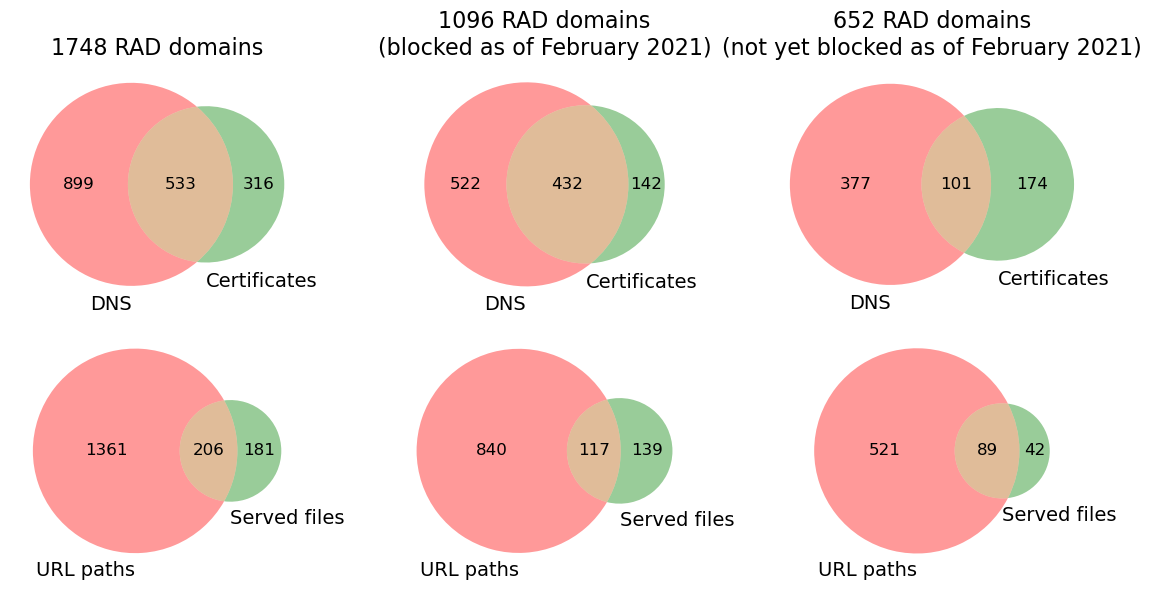

In [176]:
figure, axes = plt.subplots(2, 3, figsize=(12, 6), tight_layout=True)


venns.append(venn2([reason2dms[reason] for reason in reasons], labels, ax=axes[0][0]))
axes[0][0].set_title(str(sum_all(reason2dms)) + ' RAD domains')
venns.append(venn2([reason2ad_dms[reason] for reason in reasons], labels, ax=axes[0][1]))
axes[0][1].set_title(str(sum_all(reason2ad_dms)) + ' RAD domains\n(blocked as of February 2021)')
venns.append(venn2([reason2benign_dms[reason] for reason in reasons], labels, ax=axes[0][2]))
axes[0][2].set_title(str(sum_all(reason2benign_dms)) + ' RAD domains\n(not yet blocked as of February 2021)')

venns.append(venn2([link_reason2dms[reason] for reason in link_reasons], link_labels, ax=axes[1][0]))
# axes[1][0].set_title(str(sum_all(link_reason2dms)) + ' RAD domains')
venns.append(venn2([link_reason2ad_dms[reason] for reason in link_reasons], link_labels, ax=axes[1][1]))
# axes[1][1].set_title(str(sum_all(link_reason2ad_dms)) + ' RAD domains\n(blocked as of February 2021)')
venns.append(venn2([link_reason2benign_dms[reason] for reason in link_reasons], link_labels, ax=axes[1][2]))
# axes[1][2].set_title(str(sum_all(link_reason2benign_dms)) + ' RAD domains\n(not yet blocked as of February 2021)')

for venn in venns:
    for text in venn.set_labels:
        text.set_fontsize(14)
    for text in venn.subset_labels:
        if text is not None:
            text.set_fontsize(12)
for axs in axes:
    for ax in axs:
        ax.title.set_fontsize(16)
figure.savefig('figures/merged-venn.pdf', bbox_inches='tight')
figure

In [22]:
import disjoint_set
companions_ds = disjoint_set.DisjointSet()
for this_dm, ad_dm, _, _ in companions:
    companions_ds.union(this_dm,ad_dm)

# Revolving Domain Identification & Analysis

## Revolving domain identification

In [23]:
revolving_seeds = { 
    'sghehllds.com', 
    'parkurl.com',
    'qtjscx.com', 
    'vsntrk.com', 
    'zesdmn.com', 
    'awalnuts.ru',
    'prpopss.com', 
    'qqqwes.com', 
    'vjcbm.com', 
    'sw.wpu.sh', 
    'omynews.net', 
    'fortpush.com', 
    'stressfulpyjamas.com',
    'awempt.com',
    'hrbpark.bid',
    'fejla.com',
    'disproveknob.com',
    'j745s.com',
    'jqk2me2mzf.ru',
    'fadsatz.com',
    'patrizio.pro',
    'bgxmq.com',
    'cadspms.com',
    'd.jannews.pro',
    'sx.teston.pro',
    'zyrji.com',
    'domicileperil.com',
    'eondunpea.com',
    'bnrslks.com',
    'newmarads.com',
    'hadsimz.com',
    'militanttrial.com',
    'basetts.com',
    'alqbptof.volstqkwmth.com',
    'evlwlkmq.lmyiwaakn.com',
    'dpypzvjarj.com',
    'ckrf1.com',
    't0gju20fq34i.com',
    'boyalebut.site',
    'gadslimz.com',
    'poreklik.ru',
    'mdeih.com',
    't.hrtyi.com'
}
# suspected: evlwlkmq.lmyiwaakn.com, awept.com, hgbn.rocks, pto.awecr.com, www.madjabb.com, basetts.com, www.tr563.com




In [24]:
for s in companions_ds.itersets():
    if len(s & revolving_seeds) > 0:
        print(s)
        for v in s & revolving_seeds:
            revolving_seeds.remove(v)

{'urtirepor.com', 'faidoud.com', 'qtbb6.com', 'exofrwe.com', 'qfjherc.com', 'dumbpop.com', 'iociley.com', 'ppfrlfe.com', 'krkursist.com', 'terrapsps.com', 'expertnifg.com', 'sdkfjxjertertry.com', 'drjgjngf.com', 'rakamu.com', 'popsoffer.com', 'uruswan.com', 'qwerfdx.com', 'douoblelimpup.com', 'redlele.com', 'qumagee.com', 'exoprsdds.com', 'africaewgrhdtb.com', 'ewooe6df.com', 'sdhfbvd.com', '2cnjuh34jbman.com', 'rtyznd.com', 'nicksstevmark.com', 'asgclickpop.com', 'mrzikj.com', 'gooblesdd.com', 'meowpushnot.com', 'srigbxxv.com', 'xxccdshj.com', 'syyycc.com', 'prpopss.com', 'crocopop.com', 'mavenlohi.com', 'fhgh9sd.com', 'exobafrgdf.com', 'yougotacheck.com', '2cnjuh34jbpoint.com', 'dmvbdfblevxvx.com', 'rukoval.com', 'swesomepop.com', 'mrjb7hvcks.com', 'exoclsodaqs.com', 'smart2cnjuh34jb.com', 'livezombymil.com', '2cnjuh34jbhub.com', 'libedgolart.com', 'noproblfr.com', 'artpever.com', 'easy2cnjuh34jb.com', 'exlusepolly.com', 'terra8nb.com', 'sdasasyydd.com', 'asewlfjqwlflkew.com', 'jb7hv

In [25]:
revolving_seeds = {
    'Clickadu': {'exofrwe.com'},
    'AdSpyGlass': {'a.neverbe.xyz'},
    'LuckyAds': {'bpioqb.com'},
    #'kickvox': {'zm232.com'},
    'ads2.bid': {'jqk2me2mzf.ru'},
    'Unknown1': {'vjcbm.com', 'fejla.com', 'zyrji.com', 'basetts.com', 'bgxmq.com'}, # GIF case
    'Unknown2': {'defpush.com'}, # might be propellerads?
    'Unknown3': {'yadro24.ru'},
    'Unknown4': {'stressfulpyjamas.com', 'disproveknob.com'},
    #'Unknown5': {'bgxmq.com'},
    'Unknown6': {'fadsatz.com', 'cadspms.com', 'domicileperil.com', 'ju427bv7an9n.com', 'q28ztgp2ih5r.com', 'worshipstubborn.com', 'newmarads.com', 'hadsimz.com', 'militanttrial.com', 'madspms.com', 't0gju20fq34i.com', 'gadslimz.com', '1jsskipuf8sd.com', 'palateyawn.com', 'turbanconstituent.com'}, # redirect to Google
    'Unknown7': {'d.jannews.pro', 'sx.teston.pro'},
    'Unknown8': {'eondunpea.com', 'boyalebut.site'}, # 1clkn
    'Unknown9': {'bnrslks.com'},
    'Unknown10': {'ckrf1.com'},
    'Unknown11': {'poreklik.ru'},
    'Unknown12': {'tmntzqea.gcomrarlta.com'}
}

adv2dms = dict()
revolvings = list()
for adv, seeds in revolving_seeds.items():
    all_dms = set()
    for s in companions_ds.itersets():
        if len(s & seeds) > 0:
            all_dms |=  s
    adv2dms[adv] = sorted(list(all_dms), key=lambda dm: dm2info[dm]['first_appear'])
    
    latest_ad_dm = [ dm for dm in adv2dms[adv] if len([r['blocked_t'] for r in dm2info[dm]['requests'] if r['is_ad']]) != 0][0]
    for dm in adv2dms[adv][1:]:
        if dm in {this_dm for this_dm, _, _, _ in companions}:
            revolvings.append((dm, latest_ad_dm))
        
        if dm in {ad_dm for _, ad_dm, _, _ in companions}: #len([r['blocked_t'] for r in dm2info[dm]['requests'] if r['is_ad']]) != 0:
            latest_ad_dm = dm
len({ this_dm for this_dm, _ in revolvings})

222

In [26]:
for adv, dms in adv2dms.items():
    print(adv, len(set(dms) & {this_dm for this_dm, _, _, _ in companions}), set(dms) & {this_dm for this_dm, _, _, _ in companions})

Clickadu 35 {'faidoud.com', 'terrapsps.com', 'exlusepolly.com', 'drjgjngf.com', 'qwerfdx.com', 'redlele.com', 'qumagee.com', 'africaewgrhdtb.com', 'ewooe6df.com', 'rtyznd.com', '2cnjuh34jbman.com', 'sdhfbvd.com', 'nicksstevmark.com', 'mrzikj.com', 'xxccdshj.com', 'syyycc.com', 'prpopss.com', 'fhgh9sd.com', 'dmvbdfblevxvx.com', 'exoclsodaqs.com', 'swesomepop.com', 'smart2cnjuh34jb.com', 'livezombymil.com', 'terra8nb.com', 'easy2cnjuh34jb.com', 'sdasasyydd.com', 'sghehllds.com', 'trtjigpsscmv9epe10.com', 'tibacta.com', 'qqqwes.com', 'xxxrevpushclcdu.com', 'dlfvgndsdfsn.com', 'pkhhyool.com', 'blaghfpd.com', 'xineday.com'}
AdSpyGlass 27 {'my.shymilftube.com', 'uthbxvz.bestzba.com', 'asg.faperoni.com', 'z0000g.yvmads.com', 'rst.pornyhd.com', 'a.nvrblk.xyz', 'asg.pornoplay.online', 'jc743hbc6.info', 'b.filexan.com', '0i.sh-cdn.com', 'softspace.mobi', 'a.cdn1.pro', 'satmon.neekstore.com', 'a.neverbe.xyz', 'kliqz.com', 'asg.bhabhiporn.pro', 'asg.somecdn.bid', 'parkurl.com', 'a.hentaimotel.com'

In [27]:
import pandas as pd
for adv, dms in adv2dms.items():
    df = pd.DataFrame.from_dict({ dm: [ dm2info[dm]['first_appear'], dm2info[dm]['last_appear'] ]for dm in dms }, orient='index', columns=['appear', 'disappear'])
    
    df = df.stack().to_frame()
    df = df.reset_index(level=1)
    
    df.columns = ['status_tmp', 'time']
    #df = df.reset_index().drop('index', axis=1)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.sort_values('time')

    new_df = pd.melt(df, id_vars="time", value_name="status", ignore_index=False)
    new_df.drop(columns=["variable"],inplace=True)
    new_df['counter'] = np.where(new_df['status'].eq('appear'),1,-1).cumsum()
    print(f'========== {adv} ==========')
    with pd.option_context("display.max_rows", 1000):
        display(new_df)

========== Clickadu ==========


,time,status,counter
blaghfpd.com,2019-04-13 03:10:51,appear,1
tssandycateup.com,2019-05-16 20:38:21,appear,2
sghehllds.com,2019-06-21 12:32:07,appear,3
sdasasyydd.com,2019-06-22 00:23:16,appear,4
drjgjngf.com,2019-06-22 00:23:16,appear,5
exoclsodaqs.com,2019-06-22 00:23:16,appear,6
smart2cnjuh34jb.com,2019-07-07 15:50:01,appear,7
2cnjuh34jbman.com,2019-07-07 15:50:01,appear,8
qumagee.com,2019-07-16 15:36:13,appear,9
drjgjngf.com,2019-07-30 15:07:16,disappear,8


========== AdSpyGlass ==========


,time,status,counter
a.o333o.com,2015-09-04 04:24:31,appear,1
pornvideos.casa,2019-10-11 06:03:45,appear,2
hq3x.com,2019-11-10 19:52:28,appear,3
rst.pornyhd.com,2019-11-19 14:38:58,appear,4
asg.somecdn.bid,2019-12-16 04:08:37,appear,5
z0000g.yvmads.com,2019-12-17 12:42:46,appear,6
satmon.neekstore.com,2019-12-31 03:59:51,appear,7
cdn3.hentaihand.com,2020-02-03 07:38:47,appear,8
a.xxe2.com,2020-02-09 05:18:33,appear,9
dsfgp.admenhost.com,2020-02-09 13:10:24,appear,10


========== LuckyAds ==========


,time,status,counter
yomzba.com,2019-10-03 01:42:02,appear,1
tneduf.com,2019-11-03 07:34:59,appear,2
yomzba.com,2019-11-04 19:08:00,disappear,1
jvljpv.com,2019-11-08 21:30:32,appear,2
inpiza.com,2019-11-23 22:47:39,appear,3
aafdcq.com,2019-11-23 22:47:39,appear,4
kbtzxl.com,2019-11-26 22:26:20,appear,5
kbtzxl.com,2019-11-26 22:26:20,disappear,4
bveyge.com,2019-12-07 08:24:52,appear,5
jvljpv.com,2019-12-09 08:10:54,disappear,4


========== ads2.bid ==========


,time,status,counter
jrs2igoimq.ru,2019-11-20 19:34:45,appear,1
fqab5xq7qlgt.info,2019-11-24 17:49:41,appear,2
dtashjvcjswq.info,2019-12-20 05:33:48,appear,3
g52bxi1v1w.com,2020-02-18 18:15:05,appear,4
info.tytytutu.ru,2020-03-06 09:28:52,appear,5
f6dy9wgfbf.ru,2020-05-03 01:07:21,disappear,4
f6dy9wgfbf.ru,2020-05-03 01:07:21,appear,5
fqab5xq7qlgt.info,2020-05-28 15:08:07,disappear,4
4nb437eugn.ru.com,2020-07-07 04:10:42,appear,5
3eu2bbh2w5.com,2020-07-18 21:59:33,appear,6


========== Unknown1 ==========


,time,status,counter
qaadv.com,2015-03-01 07:20:25,appear,1
jkolp.com,2015-03-05 02:52:55,appear,2
viewclc.com,2015-03-06 08:48:06,appear,3
qaadv.com,2015-04-02 05:11:08,disappear,2
nyyed.com,2015-04-07 01:38:22,appear,3
nyyed.com,2015-04-07 01:38:22,disappear,2
basetts.com,2015-04-09 06:35:34,disappear,1
basetts.com,2015-04-09 06:35:34,appear,2
elnpe.com,2015-05-05 01:54:48,appear,3
elnpe.com,2015-05-05 01:54:48,disappear,2


========== Unknown2 ==========


,time,status,counter
defpush.com,2017-09-11 22:00:52,appear,1
go.pushnative.com,2017-11-21 15:22:54,appear,2
pushno.com,2018-02-20 06:00:37,appear,3
pushnest.com,2018-03-08 03:53:07,appear,4
basepush.com,2018-03-19 23:37:26,appear,5
fortpush.com,2018-03-20 19:59:00,appear,6
pushance.com,2018-03-31 07:00:56,appear,7
luckypushh.com,2018-08-09 07:31:20,appear,8
pushno.com,2018-08-10 00:14:33,disappear,7
pushanert.com,2018-09-23 02:26:03,appear,8


========== Unknown3 ==========


,time,status,counter
engine.turboroller.ru,2015-03-02 05:35:25,appear,1
adv-first.ru,2015-03-06 08:48:06,appear,2
ssl.cdn.odinkod.ru,2015-03-06 21:03:01,appear,3
vogo-vogo.ru,2015-04-02 19:58:16,appear,4
js.clickequations.net,2015-04-18 21:09:20,appear,5
js.clickequations.net,2015-04-18 21:09:20,disappear,4
ssl.cdn.odinkod.ru,2015-05-08 05:34:43,disappear,3
adv-first.ru,2015-05-24 00:35:59,disappear,2
ad.arklm.com,2015-12-27 03:55:13,appear,3
www.adjs.ru,2016-03-09 22:57:21,appear,4


========== Unknown4 ==========


,time,status,counter
pl13633635.puserving.com,2017-03-02 11:12:53,appear,1
pl13633635.puserving.com,2017-05-06 16:01:22,disappear,0
pussl3.com,2017-08-16 18:16:32,appear,1
pussl3.com,2017-10-22 13:26:51,disappear,0
gqqdlckj8y.com,2019-06-05 22:18:58,appear,1
gqqdlckj8y.com,2020-03-04 00:42:30,disappear,0
nqrkzcd7ixwr.com,2020-04-04 20:44:14,appear,1
nqrkzcd7ixwr.com,2020-04-04 20:44:14,disappear,0
jzhzm30o49gv.com,2020-04-10 13:30:14,appear,1
fnacgbik9v14.com,2020-05-06 11:08:02,appear,2


========== Unknown6 ==========


,time,status,counter
pl131736.puhtml.com,2015-11-01 10:22:48,appear,1
pl140057.puhtml.com,2015-12-05 18:31:25,appear,2
pl3865175.puhtml.com,2016-07-13 01:44:23,appear,3
pl3865175.puhtml.com,2016-08-26 05:02:47,disappear,2
pl8648023.puhtml.com,2016-10-04 02:27:48,appear,3
pl131736.puhtml.com,2016-11-08 01:47:26,disappear,2
pl12645170.puserving.com,2017-03-24 00:28:05,appear,3
pl13154800.puserving.com,2017-04-22 06:43:52,appear,4
pl12616679.puserving.com,2017-04-29 12:40:21,appear,5
pl12645170.puserving.com,2017-05-03 17:32:10,disappear,4


========== Unknown7 ==========


,time,status,counter
api.clickaine.com,2017-02-22 04:40:16,appear,1
ca.xxxshame.com,2018-08-05 22:02:13,appear,2
ca.xxxshame.com,2018-08-05 22:02:13,disappear,1
ca.clcknads.pro,2018-08-08 08:01:21,appear,2
cc.sersh.com,2019-08-20 12:46:44,appear,3
cc.sersh.com,2019-08-20 12:46:44,disappear,2
ca.clcknads.pro,2020-02-14 17:53:41,disappear,1
www.rtnews.pro,2020-05-05 10:17:45,appear,2
ww1.willalland.info,2020-06-28 03:07:55,appear,3
www.rtnews.pro,2020-07-04 18:34:07,disappear,2


========== Unknown8 ==========


,time,status,counter
eondunpea.com,2019-07-19 19:43:08,appear,1
keapeiros.xyz,2019-08-21 07:41:59,appear,2
idspatchi.com,2020-02-03 12:09:18,appear,3
keapeiros.xyz,2020-02-04 01:52:55,disappear,2
titoaktop.com,2020-02-10 19:29:24,appear,3
boyalebut.site,2020-03-03 23:56:37,appear,4
boyalebut.site,2020-03-03 23:56:37,disappear,3
eondunpea.com,2020-03-25 03:29:29,disappear,2
apeartalb.site,2020-03-25 05:51:56,appear,3
bopvetgel.com,2020-04-07 11:40:03,disappear,2


========== Unknown9 ==========


,time,status,counter
bnrs.it,2016-06-12 13:13:16,appear,1
bnrs.it,2017-06-24 07:46:38,disappear,0
misslk.com,2017-11-26 23:07:05,appear,1
misslk.com,2017-12-27 16:34:08,disappear,0
bnrdom.com,2018-04-30 12:32:51,appear,1
bnrdom.com,2018-07-08 07:11:05,disappear,0
kcolbda.com,2018-12-31 02:37:32,appear,1
bnrslks.com,2019-02-19 19:48:31,appear,2
cdsbnrs.com,2019-08-07 09:02:05,appear,3
bnrslks.com,2019-10-15 03:58:14,disappear,2


========== Unknown10 ==========


,time,status,counter
mnbvjhg.com,2018-06-29 06:43:07,appear,1
www.afgr10.com,2018-07-29 14:43:43,appear,2
www.afgr10.com,2018-07-29 14:43:43,disappear,1
mnbvjhg.com,2018-09-07 09:45:53,disappear,0
ckrf1.com,2019-01-02 21:18:26,appear,1
ckrf1.com,2019-01-02 21:18:26,disappear,0
www.sbfsdvc.com,2019-06-03 20:32:09,appear,1
www.sbfsdvc.com,2019-06-03 20:32:09,disappear,0
mncvjhg.com,2019-08-31 14:10:37,appear,1
mncvjhg.com,2019-08-31 14:10:37,disappear,0


========== Unknown11 ==========


,time,status,counter
poreklik.ru,2018-05-05 22:40:41,appear,1
leokross.com,2018-07-18 19:35:40,appear,2
kont-news.com,2018-09-16 03:00:37,appear,3
kont-news.com,2018-10-16 04:05:22,disappear,2
o-podelkah.ru,2018-12-25 22:36:35,appear,3
poreklik.ru,2019-03-15 12:14:20,disappear,2
juhysgu.ru,2019-04-15 07:21:43,appear,3
healtherbal.ru,2021-01-02 06:45:00,appear,4
healtherbal.ru,2021-01-02 06:45:00,disappear,3
juhysgu.ru,2021-01-16 08:41:18,disappear,2


========== Unknown12 ==========


,time,status,counter
syhdxiag.oaqjwapqdho.com,2019-06-24 11:20:42,appear,1
tmntzqea.gcomrarlta.com,2019-06-28 21:54:36,appear,2
tmntzqea.gcomrarlta.com,2019-06-28 21:54:36,disappear,1
jcpnhnyi.oaqjwapqdho.com,2019-08-02 23:09:25,appear,2
dolfdwkl.oaqjwapqdho.com,2019-08-30 11:13:04,appear,3
dolfdwkl.oaqjwapqdho.com,2019-08-30 11:13:04,disappear,2
talthcqm.oaqjwapqdho.com,2019-08-31 08:46:38,appear,3
talthcqm.oaqjwapqdho.com,2019-08-31 08:46:38,disappear,2
jcpnhnyi.oaqjwapqdho.com,2019-09-04 11:28:47,disappear,1
syhdxiag.oaqjwapqdho.com,2019-09-14 12:30:33,disappear,0


  0%|          | 0/222 [00:00<?, ?it/s]

Passive (blocked) 91
Proactive (blocked) 63
Passive (non-blocked) 59
Proactive (non-blocked) 9


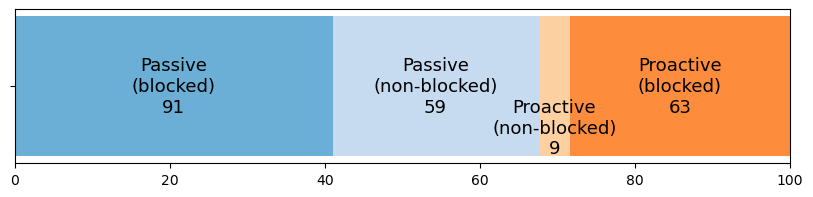

In [29]:
type2dms = defaultdict(set)
for this_dm, ad_dm in tqdm(revolvings):
    if len([r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]) == 0:
        continue
    this_dm_t = float(min([r['blocked_t'] for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf')))
    ad_dm_t = float(min([r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]))
    
    reaction_days = datetime.timedelta(seconds=(
         dm2info[this_dm]['first_appear'] - float(ad_dm_t)
    )).days
    name = ''
    name += 'Passive' if reaction_days > 0 else 'Proactive'
    name += ' (non-blocked)' if this_dm_t == float('inf') else ' (blocked)'
    type2dms[name].add(this_dm)

    
for typ, dms in type2dms.items():
    print(typ, len(dms))

figure, ax = plt.subplots(figsize=(10,2))

names = [
    'Passive (blocked)',
    'Passive (non-blocked)',
    'Proactive (non-blocked)',
    'Proactive (blocked)'
]

start = 0
ax.set_xlim(0, 100)
for name, color in zip(names, plt.get_cmap("tab20c")(np.array([1, 3, 7, 5]))):
    p = ax.barh([""], [len(type2dms[name]) / sum([len(type2dms[name]) for name in names]) * 100], left=start, label=name.replace(" ", "\n"), color=color)
    if len(type2dms[name]) < 20:
        ax.bar_label(p, label_type='center', fontsize=13, labels=["\n\n\n\n" + name.replace(" ", "\n") + "\n" + str(len(type2dms[name]))])
    elif len(type2dms[name]) < 30:
        ax.bar_label(p, label_type='center', fontsize=13, labels=[name.replace(" ", "\n") + "\n" + str(len(type2dms[name])) + "\n\n\n\n"])
    else:
        ax.bar_label(p, label_type='center', fontsize=13, labels=[name.replace(" ", "\n") + "\n" + str(len(type2dms[name]))])
    start += len(type2dms[name]) / sum([len(type2dms[name]) for name in names]) * 100
"""
p = ax.barh(
    [ name.replace(" ", "\n") for name in names],
    [len(type2dms[name]) for name in names],
    left=[ sum([ len(type2dms[j]) for j in names[:i] ])  for i, name in enumerate(names) ]
    #radius=1,
    #color=plt.get_cmap("tab20c")(np.array([1, 3, 7, 5])),
    #labels=names,
    #autopct=lambda p : '{:1.1f}%\n({:,.0f})'.format(p,p * sum(len(i) for i in type2dms.values())/100),
    #pctdistance=0.8,
    #textprops=dict(fontsize=16),
    #wedgeprops=dict(width=0.4, edgecolor='w')
)
""";

#ax.set_yticks([ name.replace(" ", "\n") for name in names])
#ax.set_yticklabels([ name.replace(" ", "\n") for name in names], fontsize=12)
#ax.set_xlabel("# of evading domains", labelpad=20, fontsize=20)
#ax.bar_label(p, padding=3)
#figure.savefig('figures/evading-type-bar.pdf', bbox_inches='tight')
figure

## Reaction time

  0%|          | 0/222 [00:00<?, ?it/s]

Passive len: 150 mean: 265.12 median: 118.0 max: 1999.0 min: 2.0 <= 90: 65
Proactive len: 72 mean: -106.40277777777777 median: -36.5 max: -1.0 min: -446.0 <= 90: 72


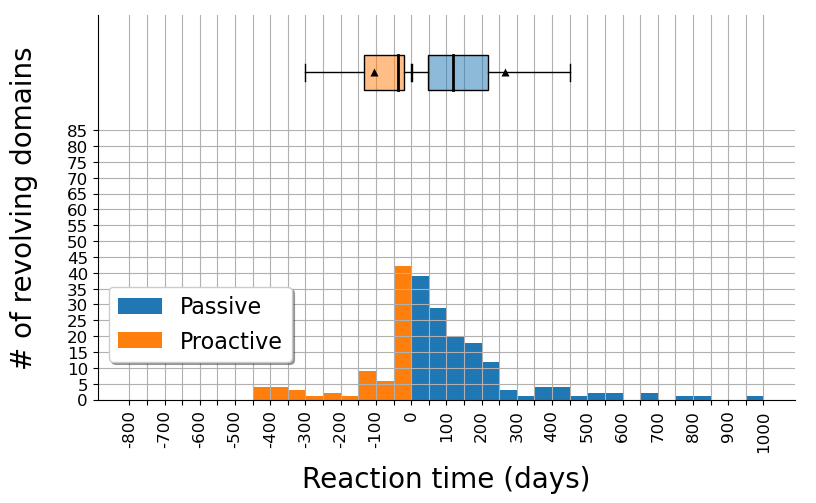

In [30]:
less_than_90_events = []
all_events_reaction_time = []
proactive_events = []
type2this_dm2days = defaultdict(lambda: defaultdict(list))
dm2reaction_time = dict()
for this_dm, ad_dm in tqdm(revolvings):
    if len([r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]) == 0:
        print(ad_dm)
        continue
    this_dm_t = float(min([r['blocked_t'] for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf')))
    ad_dm_t = float(min([r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]))
    #assert dm2info[this_dm]['first_appear'] < this_dm_t
    #assert ad_dm_t < this_dm_t
    reaction_days = datetime.timedelta(seconds=(
         dm2info[this_dm]['first_appear'] - ad_dm_t
    )).days
    if 0 <= reaction_days <= 90:
        less_than_90_events.append((this_dm, ad_dm, reaction_days))
    if reaction_days < 0:
        proactive_events.append((this_dm, ad_dm, reaction_days))
    type2this_dm2days['Proactive' if reaction_days < 0 else 'Passive'][this_dm].append(reaction_days)
    all_events_reaction_time.append((this_dm, ad_dm, reaction_days))
    dm2reaction_time[(this_dm, ad_dm)] = reaction_days

figure, (ax_box, ax_hist) = plt.subplots(2, figsize=(9, 5), sharex=True, gridspec_kw={
    "height_ratios": (.3, .7), "hspace": 0
})

bins = range(-800, 1000+1, 50)

for idx, (dm_type, dm2days) in enumerate(type2this_dm2days.items()):
    avg_days = [sum(days) / len(days) for _, days in dm2days.items()]
    print(dm_type,
          'len:',len(avg_days),
          'mean:', np.mean(avg_days),
          'median:', np.median(avg_days),
          'max:', max(avg_days),
          'min:', min(avg_days),
          '<= 90:', sum([d <= 90 for d in avg_days]) 
    )
    colors = [
        [0x1f/0xff, 0x77/0xff, 0xb4/0xff], [0xff/0xff, 0x7f/0xff, 0x0e/0xff],
        [0x2c/0xff, 0xa0/0xff, 0x2c/0xff]
    ]
    ax_box.boxplot(
        avg_days,
        vert=False,
        showmeans=True,
        showfliers=False,
        patch_artist=True,
        widths = 0.3,
        boxprops=dict(facecolor=colors[idx] + [0.5], linewidth=1),
        #capprops=dict(color=c),
        #whiskerprops=dict(color=c),
        #flierprops=dict(color=c, markeredgecolor=c),
        medianprops=dict(color='black', linewidth=2),
        meanprops=dict(markeredgecolor=(0,0,0,0), markerfacecolor='black'),
    )
    ax_hist.hist(avg_days, bins=bins, label=dm_type)

xticks = bins
yticks = range(0, 85+1, 5)

ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.set_xticks(xticks)
ax_hist.set_xticklabels([str(x) if i & 1 == 0 else '' for i, x in enumerate(xticks)], fontsize=12, rotation=90)
ax_hist.set_yticks(yticks)
ax_hist.set_yticklabels(yticks, fontsize=12)
ax_hist.legend(
    loc='lower left',
    bbox_to_anchor=(0, 0.1, 1, 1),
    framealpha=1,
    shadow=True,
    fontsize=16
)
ax_hist.grid(True)

ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.spines['bottom'].set_visible(False)
ax_box.get_yaxis().set_visible(False)
ax_box.grid(True)

# https://stackoverflow.com/a/53172335/11712282
ax = figure.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_ylabel("# of revolving domains", labelpad=20, fontsize=20)

#ax.set_xticklabels(xticks, rotation=90)
ax.set_xlabel("Reaction time (days)", labelpad=30, fontsize=20)
#figure.savefig('figures/reaction-bar.pdf', bbox_inches='tight')
figure

  0%|          | 0/222 [00:00<?, ?it/s]

Passive len: 102 mean: 312.04901960784315 median: 118.5 max: 1966.0 min: 1.0 <= 90: 44
Proactive len: 108 mean: -226.55555555555554 median: -97.0 max: -3.0 min: -1556.0 <= 90: 108


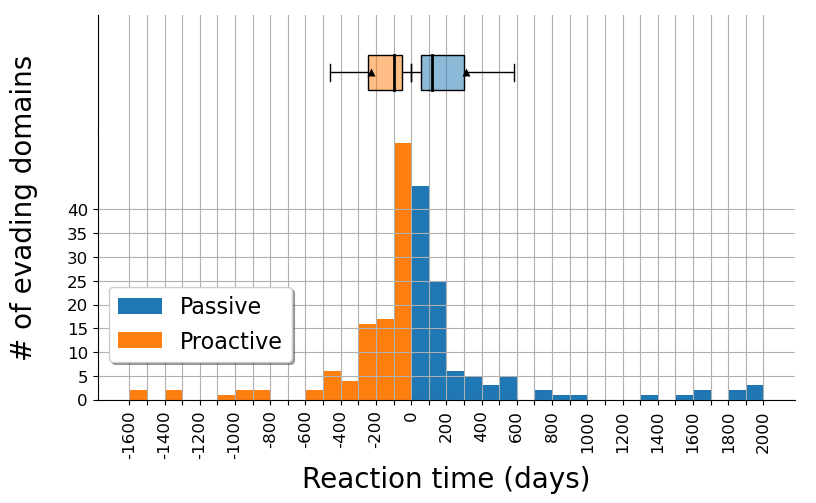

In [31]:
type2this_dm2days = defaultdict(lambda: defaultdict(list))
for this_dm, ad_dm in tqdm(revolvings):
    this_dm_t = float(min([r['blocked_t'] for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf')))
    ad_dm_t = float(min([r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]))
    assert dm2info[this_dm]['first_appear'] < this_dm_t
    #assert ad_dm_t < this_dm_t
    
    s = list()
    for fp in {r['first_party'] for r in dm2info[this_dm]['requests']}:
        first_appear = float(min([r['t'] for r in dm2info[this_dm]['requests'] if r['first_party'] == fp], default=float('inf')))
        
        if fp not in dm2info:
            continue
        
        ts = float(max([ r['t'] for r in dm2info[fp]['requests'] if r['t'] < first_appear ], default=float('-inf')))
        if first_appear == float('inf') or ts == float('-inf'):
            continue
        s.append(ts)
    
    if len(s) == 0:
        continue
    
    reaction_days = datetime.timedelta(seconds=(
         min(s) - ad_dm_t
    )).days
    type2this_dm2days['Proactive' if reaction_days < 0 else 'Passive'][this_dm].append(reaction_days)

figure, (ax_box, ax_hist) = plt.subplots(2, figsize=(9, 5), sharex=True, gridspec_kw={
    "height_ratios": (.3, .7), "hspace": 0
})

bins = range(-1600, 2000+1, 100)

for idx, (dm_type, dm2days) in enumerate(type2this_dm2days.items()):
    avg_days = [sum(days) / len(days) for _, days in dm2days.items()]
    print(dm_type,
          'len:',len(avg_days),
          'mean:', np.mean(avg_days),
          'median:', np.median(avg_days),
          'max:', max(avg_days),
          'min:', min(avg_days),
          '<= 90:', sum([d <= 90 for d in avg_days]) 
    )
    colors = [
        [0x1f/0xff, 0x77/0xff, 0xb4/0xff], [0xff/0xff, 0x7f/0xff, 0x0e/0xff],
        [0x2c/0xff, 0xa0/0xff, 0x2c/0xff]
    ]
    ax_box.boxplot(
        avg_days,
        vert=False,
        showmeans=True,
        showfliers=False,
        patch_artist=True,
        widths = 0.3,
        boxprops=dict(facecolor=colors[idx] + [0.5], linewidth=1),
        #capprops=dict(color=c),
        #whiskerprops=dict(color=c),
        #flierprops=dict(color=c, markeredgecolor=c),
        medianprops=dict(color='black', linewidth=2),
        meanprops=dict(markeredgecolor=(0,0,0,0), markerfacecolor='black'),
    )
    ax_hist.hist(avg_days, bins=bins, label=dm_type)

xticks = bins
yticks = range(0, 40+1, 5)

ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.set_xticks(xticks)
ax_hist.set_xticklabels([str(x) if i & 1 == 0 else '' for i, x in enumerate(xticks)], fontsize=12, rotation=90)
ax_hist.set_yticks(yticks)
ax_hist.set_yticklabels(yticks, fontsize=12)
ax_hist.legend(
    loc='lower left',
    bbox_to_anchor=(0, 0.1, 1, 1),
    framealpha=1,
    shadow=True,
    fontsize=16
)
ax_hist.grid(True)

ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.spines['bottom'].set_visible(False)
ax_box.get_yaxis().set_visible(False)
ax_box.grid(True)

# https://stackoverflow.com/a/53172335/11712282
ax = figure.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_ylabel("# of evading domains", labelpad=20, fontsize=20)

#ax.set_xticklabels(xticks, rotation=90)
ax.set_xlabel("Reaction time (days)", labelpad=30, fontsize=20)
#figure.savefig('figures/reaction-bar.pdf', bbox_inches='tight')
figure

## Survival Time

  0%|          | 0/222 [00:00<?, ?it/s]

Proactive len: 113 mean: 79.90265486725664 median: 34.0 max: 655.0 min: 1.0 <= 4: 8


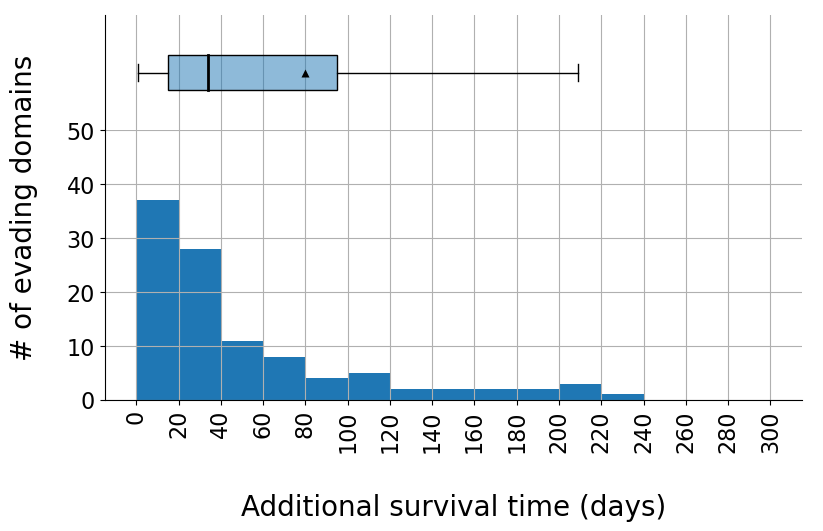

In [32]:
dm2survival_time = dict()
type2this_dm2days = defaultdict(lambda: defaultdict(list))
for this_dm, ad_dm in tqdm(revolvings):
    this_dm_t = float(min([r['blocked_t'] for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf')))
    ad_dm_t = float(min([r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]))
    assert dm2info[this_dm]['first_appear'] < this_dm_t
    #assert ad_dm_t < this_dm_t
    '''ignore cases where this_dm is not blocked'''
    if this_dm_t == float('inf'):
        continue
    start = max(dm2info[this_dm]['first_appear'], ad_dm_t)
    end = this_dm_t
    survival_days = datetime.timedelta(seconds=end - start).days
    #assert survival_days >= 0
    dm2survival_time[(this_dm, ad_dm)] = survival_days
    if survival_days <= 0:
        continue
    type2this_dm2days['blocked'][this_dm].append(survival_days)

figure, (ax_box, ax_hist) = plt.subplots(2, figsize=(9, 5), sharex=True, gridspec_kw={
    "height_ratios": (.3, .7), "hspace":0
})

bins = range(0, 300+1, 20)
dm2days = type2this_dm2days['blocked']
avg_days = [sum(days) / len(days) for _, days in dm2days.items()]
print(dm_type,
      'len:',len(avg_days),
      'mean:', np.mean(avg_days),
      'median:', np.median(avg_days),
      'max:', max(avg_days),
      'min:', min(avg_days),
      '<= 4:', sum([d <= 4 for d in avg_days]) 
)

ax_box.boxplot(
    avg_days,
    vert=False,
    showmeans=True,
    showfliers=False,
    patch_artist=True,
    widths = 0.3,
    boxprops=dict(facecolor=colors[0] + [0.5], linewidth=1),
    #capprops=dict(linewidth=2),
    #whiskerprops=dict(linewidth=2),
    #flierprops=dict(color=c, markeredgecolor=c),
    medianprops=dict(color='black', linewidth=2),
    meanprops=dict(markeredgecolor=(0,0,0,0), markerfacecolor='black'),
)
ax_hist.hist(avg_days, bins=bins, label=dm_type)

xticks = bins
yticks = range(0, 50+1, 10)

ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.set_xticks(xticks)
ax_hist.set_xticklabels(xticks, fontsize=16, rotation=90)
ax_hist.set_yticks(yticks)
ax_hist.set_yticklabels(yticks, fontsize=16)
#ax_hist.legend(
#    loc='lower left',
#    bbox_to_anchor=(0, 0.1, 1, 1),
#    framealpha=1,
#    shadow=True
#)
ax_hist.grid(True)

ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.spines['bottom'].set_visible(False)
ax_box.get_yaxis().set_visible(False)
ax_box.grid(True)

# https://stackoverflow.com/a/53172335/11712282
ax = figure.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_ylabel("# of evading domains", labelpad=25, fontsize=20)

#ax.set_xticklabels(xticks, rotation=90)
ax.set_xlabel("Additional survival time (days)", labelpad=50, fontsize=20)
#figure.savefig('figures/survival-blocked-bar.pdf', bbox_inches='tight')
figure

## DNS

In [33]:
revdm2reason = defaultdict(lambda: set())
for revdm in {this_dm for this_dm, _ in revolvings}:
    for ad_dm, reasons in dm2related_ads[this_dm].items():
        if ad_dm in {ad_dm for _, ad_dm in revolvings}:
            revdm2reason[revdm] |= reasons

In [34]:
for name, dms in adv2dms.items():
    print(name)
    for dm in dms:
        print(dm2dns[dm].get('A', set()))

Clickadu
{'23.108.102.138', '103.254.155.144'}
{'103.254.155.144'}
{'103.254.155.143', '103.254.155.144'}
{'103.254.155.143'}
{'23.108.102.138'}
{'23.108.102.138'}
{'23.106.252.154', '103.254.155.144'}
{'103.254.155.143', '43.249.39.182'}
{'23.108.102.138', '103.254.155.144'}
{'23.106.252.154'}
{'23.108.102.138', '43.249.39.182'}
{'23.108.102.138', '23.106.252.154'}
{'23.108.102.138', '23.106.252.154'}
{'23.108.102.138'}
{'23.108.102.138', '103.254.155.143'}
{'103.254.155.143', '23.106.252.154'}
{'103.254.155.143', '23.106.252.154'}
{'103.254.155.143'}
{'23.108.102.138'}
{'23.108.102.138', '103.254.155.144'}
{'43.249.39.182'}
{'23.106.252.154', '43.249.39.182'}
{'23.108.102.138', '23.106.252.154'}
{'23.108.102.138'}
{'23.108.102.138', '23.106.252.154'}
{'23.106.252.154'}
{'23.108.102.138', '103.254.155.144'}
{'23.106.252.154', '103.254.155.144'}
{'103.254.155.144'}
{'23.108.102.138', '103.254.155.143'}
{'23.108.102.138', '103.254.155.144'}
{'23.108.102.138', '43.249.39.182'}
{'23.108.1

# Companion domain Analysis

## Prominent metrics

In [35]:
from tranco import Tranco
tranco = Tranco(cache=True, cache_dir='.tranco')
tranco_list = tranco.list(date="2021-03-01")
top20k = tranco.list(date="2021-03-01").top(20000)

  0%|          | 0/18646 [00:00<?, ?it/s]

Not in top 20k len: 380 mean: -403.26286421896054 median: -158.22727272727275 max: -1.0 min: -2029.0 <= 90: 380
In top 20k len: 256 mean: 435.13964533730154 median: 240.0 max: 2028.0 min: 1.0 <= 90: 84


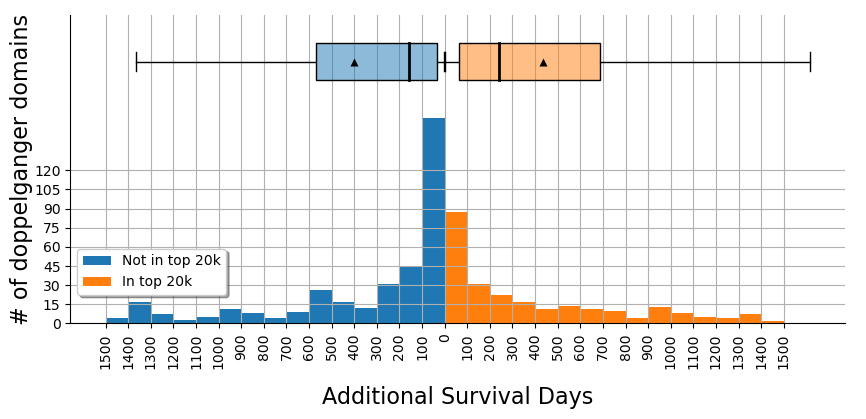

In [36]:
import numpy as np

only_appear_in_not_top_20k = set()

type2this_dm2days = defaultdict(lambda: defaultdict(list))
for this_dm, ad_dm, _, _ in tqdm(companions):
    this_dm_t = min([r['blocked_t'] for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf'))
    ad_dm_t = min([r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']])
    assert dm2info[this_dm]['first_appear'] < this_dm_t
    #assert ad_dm_t < this_dm_t
    '''ignore cases where this_dm is not blocked'''
    if this_dm_t == float('inf'):
        continue
    start = max(dm2info[this_dm]['first_appear'], ad_dm_t)
    end = this_dm_t
    survival_days = datetime.timedelta(seconds=end - start).days
    #assert survival_days >= 0
    if survival_days <= 0:
        continue
    if any(r['first_party'] in top20k for r in dm2info[this_dm]['requests']):
        type2this_dm2days['In top 20k'][this_dm].append(survival_days)
    if any(r['first_party'] not in top20k for r in dm2info[this_dm]['requests']):
        type2this_dm2days['Not in top 20k'][this_dm].append(-survival_days)
    if all(r['first_party'] not in top20k for r in dm2info[this_dm]['requests']):
        only_appear_in_not_top_20k.add(this_dm)

figure, (ax_box, ax_hist) = plt.subplots(2, figsize=(10, 4), sharex=True, gridspec_kw={
    "height_ratios": (.3, .7), "hspace":0
})

bins = range(-1500, 1500+1, 100)
for idx, (dm_type, dm2days) in enumerate(type2this_dm2days.items()):
    avg_days = [sum(days) / len(days) for _, days in dm2days.items()]
    print(dm_type,
          'len:',len(avg_days),
          'mean:', np.mean(avg_days),
          'median:', np.median(avg_days),
          'max:', max(avg_days),
          'min:', min(avg_days),
          '<= 90:', sum([d <= 90 for d in avg_days]) 
    )
    colors = [[0x1f/0xff, 0x77/0xff, 0xb4/0xff], [0xff/0xff, 0x7f/0xff, 0x0e/0xff]]
    ax_box.boxplot(
        avg_days,
        vert=False,
        showmeans=True,
        showfliers=False,
        patch_artist=True,
        widths = 0.4,
        boxprops=dict(facecolor=colors[idx] + [0.5], linewidth=1),
        #capprops=dict(color=c),
        #whiskerprops=dict(color=c),
        #flierprops=dict(color=c, markeredgecolor=c),
        medianprops=dict(color='black', linewidth=2),
        meanprops=dict(markeredgecolor=(0,0,0,0), markerfacecolor='black'),
    )
    ax_hist.hist(avg_days, bins=bins, label=dm_type)

xticks = bins
yticks = range(0, 120+1, 15)

ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.set_xticks(xticks)
ax_hist.set_xticklabels([abs(i) for i in xticks], rotation=90)
ax_hist.set_yticks(yticks)
ax_hist.legend(
    loc='lower left',
    bbox_to_anchor=(0, 0.1, 1, 1),
    framealpha=1,
    shadow=True
)
ax_hist.grid(True)

ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.spines['bottom'].set_visible(False)
ax_box.get_yaxis().set_visible(False)
ax_box.grid(True)

# https://stackoverflow.com/a/53172335/11712282
ax = figure.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_ylabel("# of doppelganger domains", fontsize=16)

ax.set_xlabel("Additional Survival Days", labelpad=28, fontsize=16)

#print(only_appear_in_not_top_20k, len(only_appear_in_not_top_20k))
figure

  0%|          | 0/18646 [00:00<?, ?it/s]

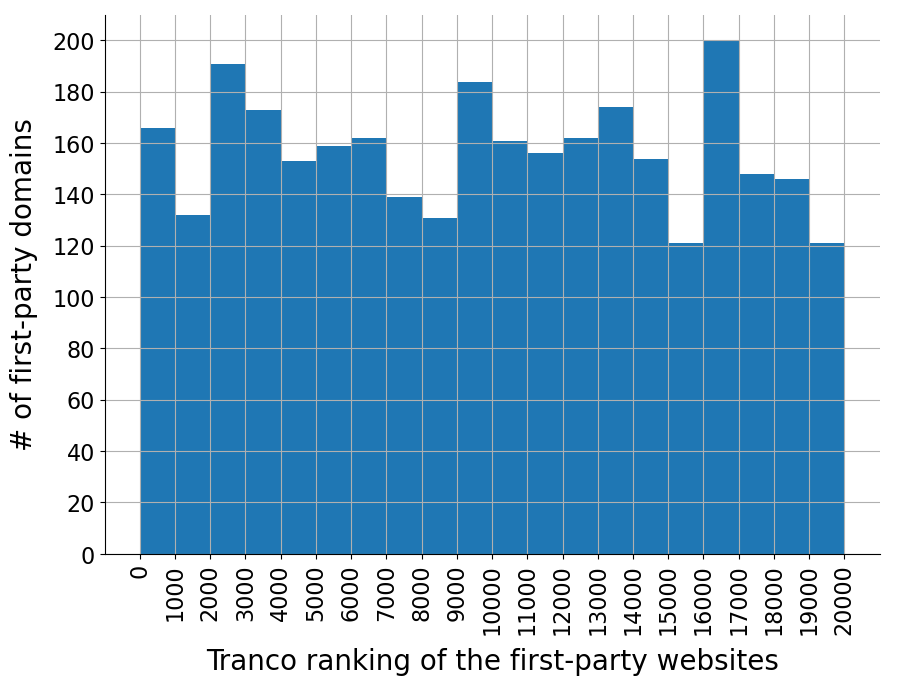

In [37]:
this_dm_site_ranking = set()
for this_dm, ad_dm, sim_paths, _ in tqdm(companions):
    start = max(dm2info[this_dm]['first_appear'], ad_dm_t)
    has_pushed = set()
    for r in dm2info[this_dm]['requests']:
        if r['first_party'] in has_pushed:
            continue
        has_pushed.add(r['first_party'])
        this_dm_site_ranking.add((this_dm, tranco_list.rank(r['first_party'])))

this_dm_site_ranking = [ s for s in list(this_dm_site_ranking) if s[1] < 20000 ]


figure, ax_hist = plt.subplots(1, figsize=(10, 7), sharex=True)#, gridspec_kw={
#    "height_ratios": (.3, .7), "hspace":0
#})

bins = range(0, 20001, 1000)
ax_hist.hist([s[1] for s in this_dm_site_ranking], bins=bins, label=dm_type)

xticks = bins
yticks = range(0, 200+1, 20)

ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.set_xticks(xticks)
ax_hist.set_xticklabels(xticks, fontsize=16, rotation=90)
ax_hist.set_yticks(yticks)
ax_hist.set_yticklabels(yticks, fontsize=16)
#ax_hist.legend(
#    loc='lower left',
#    bbox_to_anchor=(0, 0.1, 1, 1),
#    framealpha=1,
#    shadow=True
#)
ax_hist.grid(True)

ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.spines['bottom'].set_visible(False)
ax_box.get_yaxis().set_visible(False)
ax_box.grid(True)

# https://stackoverflow.com/a/53172335/11712282
ax = figure.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_ylabel("# of first-party domains", labelpad=25, fontsize=20)

#ax.set_xticklabels(xticks, rotation=90)
ax.set_xlabel("Tranco ranking of the first-party websites", labelpad=50, fontsize=20)
figure.savefig('figures/first-site-ranking.pdf', bbox_inches='tight')
figure

In [38]:
cpdm_ranking = []
for this_dm in tqdm({this_dm for this_dm, _, _, _ in companions}):
    if get_ps_domain(this_dm) == this_dm:
        cpdm_ranking.append(tranco_list.rank(this_dm))

  0%|          | 0/1748 [00:00<?, ?it/s]

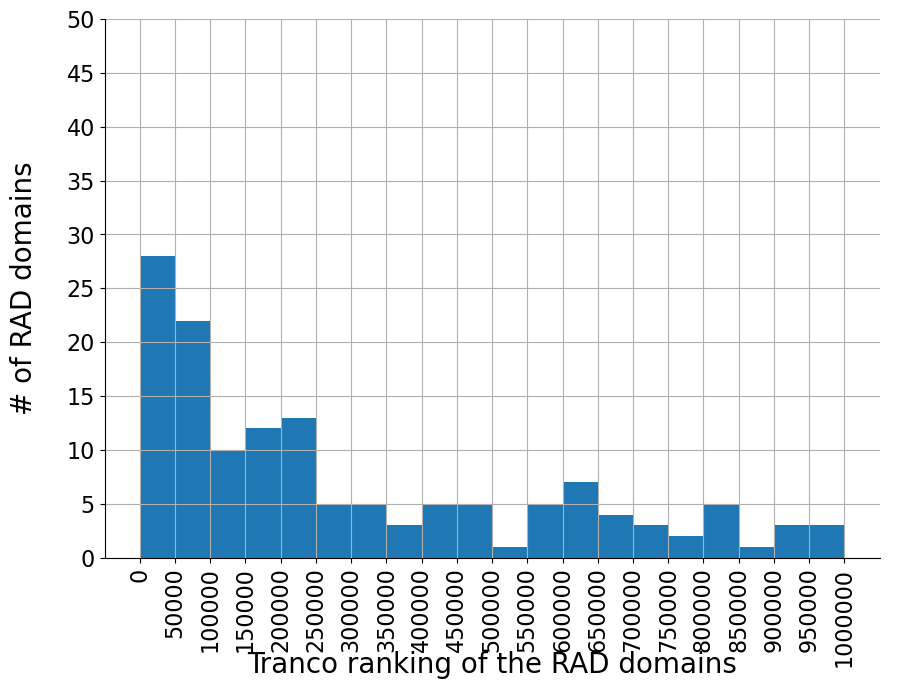

In [39]:
figure, ax_hist = plt.subplots(1, figsize=(10, 7), sharex=True)#, gridspec_kw={
#    "height_ratios": (.3, .7), "hspace":0
#})

bins = range(0, 1_000_001, 5_0000)
ax_hist.hist(cpdm_ranking, bins=bins)

xticks = bins
yticks = range(0, 50+1, 5)

ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.set_xticks(xticks)
ax_hist.set_xticklabels(xticks, fontsize=16, rotation=90)
ax_hist.set_yticks(yticks)
ax_hist.set_yticklabels(yticks, fontsize=16)
#ax_hist.legend(
#    loc='lower left',
#    bbox_to_anchor=(0, 0.1, 1, 1),
#    framealpha=1,
#    shadow=True
#)
ax_hist.grid(True)

# https://stackoverflow.com/a/53172335/11712282
ax = figure.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_ylabel("# of RAD domains", labelpad=25, fontsize=20)

#ax.set_xticklabels(xticks, rotation=90)
ax.set_xlabel("Tranco ranking of the RAD domains", labelpad=50, fontsize=20)
#figure.savefig('figures/cpdm-ranking.pdf', bbox_inches='tight')
figure

In [40]:
len(cpdm_ranking), cpdm_ranking.count(-1), len([c for c in cpdm_ranking if c > 100_000])

(508, 366, 92)

In [41]:
for this_dm in tqdm({this_dm for this_dm, _, _, _ in companions}):
    if get_ps_domain(this_dm) != this_dm:
        continue
    a = tranco_list.rank(this_dm)
    if -1 < a < 50000:
        print(get_ps_domain(this_dm), this_dm, a, this_dm in {this_dm for this_dm, _ in revolvings})

  0%|          | 0/1748 [00:00<?, ?it/s]

fluidsurveys.com fluidsurveys.com 49251 False
omniglot.com omniglot.com 13750 False
smi2.ru smi2.ru 9138 False
usconstitution.net usconstitution.net 26702 False
pantagraph.com pantagraph.com 20595 False
democraticunderground.com democraticunderground.com 15266 False
mapio.net mapio.net 13654 False
czilladx.com czilladx.com 27679 False
sinoptik.ua sinoptik.ua 5646 False
spinbot.com spinbot.com 11682 False
fastdlr.com fastdlr.com 11733 False
simplypsychology.org simplypsychology.org 8617 False
iconarchive.com iconarchive.com 15107 False
insidenova.com insidenova.com 44206 False
christiantoday.com christiantoday.com 16541 False
thesunchronicle.com thesunchronicle.com 46689 False
allhiphop.com allhiphop.com 27074 False
nicksstevmark.com nicksstevmark.com 49459 True
adpushup.com adpushup.com 10276 False
maxpark.com maxpark.com 42685 False
constitution.org constitution.org 15829 False
onesignal.com onesignal.com 1141 False
phrases.org.uk phrases.org.uk 10983 False
percentagecalculator.net pe

## Survival Time

  0%|          | 0/18646 [00:00<?, ?it/s]

blocked len: 535 mean: 424.24539740103586 median: 196.0 max: 2029.0 min: 1.0 <= 90: 203
non-blocked len: 651 mean: 784.6918386191231 median: 683.0 max: 2191.0 min: 1.0 <= 90: 55


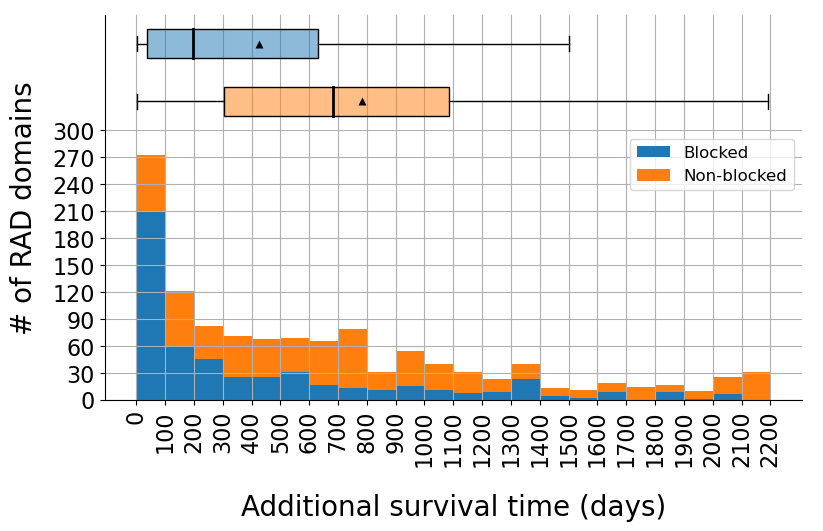

In [42]:
dm2survival_time = dict()
type2this_dm2days = defaultdict(lambda: defaultdict(list))
for this_dm, ad_dm, _, _ in tqdm(companions):
    this_dm_t = float(min([r['blocked_t'] for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf')))
    ad_dm_t = float(min([r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]))
    assert dm2info[this_dm]['first_appear'] < this_dm_t
    if ad_dm_t >= this_dm_t:
        #dm2survival_time[(this_dm, ad_dm)] = 0
        #type2this_dm2days['blocked' if this_dm_t != float('inf') else 'non-blocked'][this_dm].append(0)
        continue
    
    # suppose that the unblocked evading domains are blocked
    end = this_dm_t if this_dm_t != float('inf') else datetime.datetime(2021, 3, 1).timestamp()
    start = max(dm2info[this_dm]['first_appear'], ad_dm_t)
    survival_days = datetime.timedelta(seconds=end - start).days
    #assert survival_days >= 0
    dm2survival_time[(this_dm, ad_dm)] = survival_days
    if survival_days <= 0:
        continue
    type2this_dm2days['blocked' if this_dm_t != float('inf') else 'non-blocked'][this_dm].append(survival_days)

figure, (ax_box_blocked, ax_box_unblocked, ax_hist) = plt.subplots(3, figsize=(9, 5), sharex=True, gridspec_kw={
    "height_ratios": (.15, .15, .7), "hspace":0
})

# blocked
bins = range(0, 2200+1, 100)
avg_days_blocked = [sum(days) / len(days) for _, days in type2this_dm2days['blocked'].items()]
ax_box_blocked.boxplot(
    avg_days_blocked,
    vert=False,
    showmeans=True,
    showfliers=False,
    patch_artist=True,
    widths = 0.5,
    boxprops=dict(facecolor=colors[0] + [0.5], linewidth=1),
    #capprops=dict(linewidth=2),
    #whiskerprops=dict(linewidth=2),
    #flierprops=dict(color=c, markeredgecolor=c),
    medianprops=dict(color='black', linewidth=2),
    meanprops=dict(markeredgecolor=(0,0,0,0), markerfacecolor='black'),
)
#ax_hist.hist(avg_days, bins=bins, label=dm_type, color=colors[2])
print('blocked',
    'len:',len(avg_days_blocked),
    'mean:', np.mean(avg_days_blocked),
    'median:', np.median(avg_days_blocked),
    'max:', max(avg_days_blocked),
    'min:', min(avg_days_blocked),
    '<= 90:', sum([d <= 90 for d in avg_days_blocked]) 
)


# non-blocked
avg_days_unblocked = [sum(days) / len(days) for _, days in type2this_dm2days['non-blocked'].items()]

ax_box_unblocked.boxplot(
    avg_days_unblocked,
    vert=False,
    showmeans=True,
    showfliers=False,
    patch_artist=True,
    widths = 0.5,
    boxprops=dict(facecolor=colors[1] + [0.5], linewidth=1),
    #capprops=dict(linewidth=2),
    #whiskerprops=dict(linewidth=2),
    #flierprops=dict(color=c, markeredgecolor=c),
    medianprops=dict(color='black', linewidth=2),
    meanprops=dict(markeredgecolor=(0,0,0,0), markerfacecolor='black'),
)
print('non-blocked',
    'len:',len(avg_days_unblocked),
    'mean:', np.mean(avg_days_unblocked),
    'median:', np.median(avg_days_unblocked),
    'max:', max(avg_days_unblocked),
    'min:', min(avg_days_unblocked),
    '<= 90:', sum([d <= 90 for d in avg_days_unblocked]) 
)
ax_hist.hist([avg_days_blocked, avg_days_unblocked], bins=bins, label=['Blocked', 'Non-blocked'], stacked=True, color=colors[0:2])



xticks = bins
yticks = range(0, 300+1, 30)

ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.set_xticks(xticks)
ax_hist.set_xticklabels(xticks, fontsize=16, rotation=90)
ax_hist.set_yticks(yticks)
ax_hist.set_yticklabels(yticks, fontsize=16)
#ax_hist.legend(
#    loc='lower left',
#    bbox_to_anchor=(0, 0.1, 1, 1),
#    framealpha=1,
#    shadow=True
#)
ax_hist.grid(True)
ax_hist.legend(fontsize=12)

ax_box_blocked.spines['top'].set_visible(False)
ax_box_blocked.spines['right'].set_visible(False)
ax_box_blocked.spines['bottom'].set_visible(False)
ax_box_blocked.get_yaxis().set_visible(False)
ax_box_blocked.grid(True)
ax_box_unblocked.spines['top'].set_visible(False)
ax_box_unblocked.spines['right'].set_visible(False)
ax_box_unblocked.spines['bottom'].set_visible(False)
ax_box_unblocked.get_yaxis().set_visible(False)
ax_box_unblocked.grid(True)

# https://stackoverflow.com/a/53172335/11712282
ax = figure.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_ylabel("# of RAD domains", labelpad=25, fontsize=20)

#ax.set_xticklabels(xticks, rotation=90)
ax.set_xlabel("Additional survival time (days)", labelpad=50, fontsize=20)
figure.savefig('figures/survival-all-companion-bar.pdf', bbox_inches='tight')
figure

  0%|          | 0/18646 [00:00<?, ?it/s]

len: 216 mean: 377.84280586954196 median: 152.9090909090909 max: 2023.0 min: 3.6666666666666665 <= 90: 76


<ipython-input-43-21f3984f7994>:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, rotation=90)


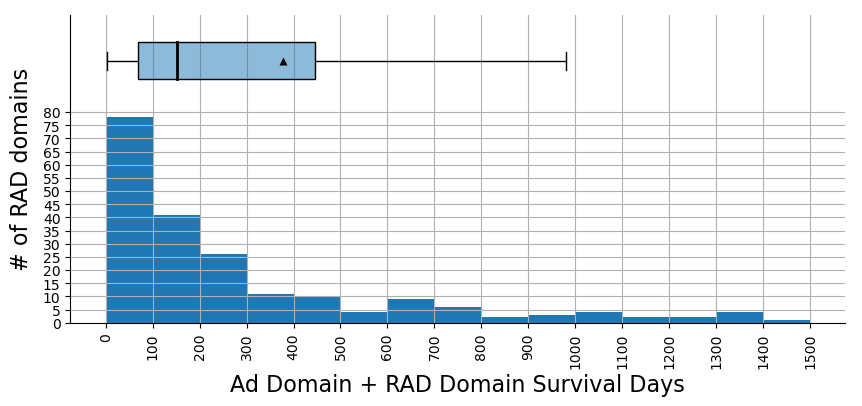

In [43]:
import numpy as np

this_dm2survival_days = defaultdict(list)
for this_dm, ad_dm, _, _ in tqdm(companions):
    ad_dm_block = float(min([r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]))
    ad_dm_appear = float(dm2info[ad_dm]['first_appear'])
    if ad_dm_block < ad_dm_appear:
        continue
    ad_survival_days = datetime.timedelta(seconds=ad_dm_block - ad_dm_appear).days
    assert ad_survival_days >= 0
    
    this_dm_t = float(min([r['blocked_t'] for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf')))
    ad_dm_t = float(min([r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]))
    assert dm2info[this_dm]['first_appear'] < this_dm_t
    if ad_dm_t >= this_dm_t:
        continue
    '''ignore cases where this_dm is not blocked'''
    if this_dm_t == float('inf'):
        continue
    start = max(dm2info[this_dm]['first_appear'], ad_dm_t)
    end = this_dm_t
    ev_survival_days = datetime.timedelta(seconds=end - start).days
    assert ev_survival_days >= 0
    this_dm2survival_days[this_dm].append((ev_survival_days + ad_survival_days))

figure, (ax_box, ax_hist) = plt.subplots(2, figsize=(10, 4), sharex=True, gridspec_kw={
    "height_ratios": (.3, .7), "hspace":0
})

bins = range(0, 1500+1, 100)
#dm2days = type2this_dm2days['blocked']
#avg_days = [sum(days) / len(days) for _, days in dm2days.items()]
avg_days = [ sum(days) / len(days) for _, days in this_dm2survival_days.items() ]
print(
      'len:',len(avg_days),
      'mean:', np.mean(avg_days),
      'median:', np.median(avg_days),
      'max:', max(avg_days),
      'min:', min(avg_days),
      '<= 90:', sum([d <= 90 for d in avg_days]) 
)

ax_box.boxplot(
    avg_days,
    vert=False,
    showmeans=True,
    showfliers=False,
    patch_artist=True,
    widths = 0.4,
    boxprops=dict(facecolor=colors[0] + [0.5], linewidth=1),
    #capprops=dict(linewidth=2),
    #whiskerprops=dict(linewidth=2),
    #flierprops=dict(color=c, markeredgecolor=c),
    medianprops=dict(color='black', linewidth=2),
    meanprops=dict(markeredgecolor=(0,0,0,0), markerfacecolor='black'),
)
ax_hist.hist(avg_days, bins=bins, label=dm_type)

xticks = bins
yticks = range(0, 80+1, 5)

ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.set_xticks(xticks)
ax_hist.set_xticklabels(xticks, rotation=90)
ax_hist.set_yticks(yticks)
#ax_hist.legend(
#    loc='lower left',
#    bbox_to_anchor=(0, 0.1, 1, 1),
#    framealpha=1,
#    shadow=True
#)
ax_hist.grid(True)

ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.spines['bottom'].set_visible(False)
ax_box.get_yaxis().set_visible(False)
ax_box.grid(True)

# https://stackoverflow.com/a/53172335/11712282
ax = figure.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_ylabel("# of RAD domains", fontsize=16)

ax.set_xticklabels(xticks, rotation=90)
ax.set_xlabel("Ad Domain + RAD Domain Survival Days", labelpad=10, fontsize=16)
figure

In [44]:
type2this_dm2days = defaultdict(lambda: defaultdict(list))
for this_dm, ad_dm, _, _ in tqdm(companions):
    this_dm_t = float(min([r['blocked_t'] for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf')))
    ad_dm_t = float(min([r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]))
    assert dm2info[this_dm]['first_appear'] < this_dm_t
    
    if ad_dm_t >= this_dm_t:
        survival_days = 0
        type2this_dm2days['blocked' if this_dm_t != float('inf') else 'non-blocked'][this_dm].append(survival_days)
    
    # suppose that the unblocked evading domains are blocked
    end = this_dm_t if this_dm_t != float('inf') else datetime.datetime(2021, 3, 1).timestamp()
    start = max(dm2info[this_dm]['first_appear'], ad_dm_t)
    survival_days = datetime.timedelta(seconds=end - start).days
    #assert survival_days >= 0
    dm2survival_time[(this_dm, ad_dm)] = survival_days
    if survival_days <= 0:
        continue
    type2this_dm2days['blocked' if this_dm_t != float('inf') else 'non-blocked'][this_dm].append(survival_days)

figure, (ax_box_blocked, ax_box_unblocked, ax_hist) = plt.subplots(3, figsize=(9, 5), sharex=True, gridspec_kw={
    "height_ratios": (.15, .15, .7), "hspace":0
})

# blocked
bins = range(0, 2200+1, 100)
avg_days_blocked = [sum(days) / len(days) for _, days in type2this_dm2days['blocked'].items()]

#ax_hist.hist(avg_days, bins=bins, label=dm_type, color=colors[2])
print('blocked',
    'len:',len(avg_days_blocked),
    'mean:', np.mean(avg_days_blocked),
    'median:', np.median(avg_days_blocked),
    'max:', max(avg_days_blocked),
    'min:', min(avg_days_blocked),
    '<= 90:', sum([d <= 90 for d in avg_days_blocked]) 
)

  0%|          | 0/18646 [00:00<?, ?it/s]

blocked len: 1093 mean: 193.5102037364671 median: 0.0 max: 2029.0 min: 0.0 <= 90: 780


## Clusters

In [45]:
print(np.mean([len(s) for s in companions_ds.itersets() if len(s) > 2]), len([len(s) for s in companions_ds.itersets() if len(s) > 2]), sum([len(s) for s in companions_ds.itersets() if len(s) > 2]), sum([len(s & {this_dm for this_dm, _, _, _ in companions}) for s in companions_ds.itersets() if len(s) > 2]))
for s in companions_ds.itersets():
    if len(s) >= 3:
        print(len(s), s)

10.549356223175966 233 2458 1386
6 {'jvd.a.swcs.jp', 'irq.a.swcs.jp', 'jyn.a.swcs.jp', 'jgk.a.swcs.jp', 'kev.a.swcs.jp', 'lgu.a.swcs.jp'}
73 {'urtirepor.com', 'faidoud.com', 'qtbb6.com', 'exofrwe.com', 'qfjherc.com', 'dumbpop.com', 'iociley.com', 'ppfrlfe.com', 'krkursist.com', 'terrapsps.com', 'expertnifg.com', 'sdkfjxjertertry.com', 'drjgjngf.com', 'rakamu.com', 'popsoffer.com', 'uruswan.com', 'qwerfdx.com', 'douoblelimpup.com', 'redlele.com', 'qumagee.com', 'exoprsdds.com', 'africaewgrhdtb.com', 'ewooe6df.com', 'sdhfbvd.com', '2cnjuh34jbman.com', 'rtyznd.com', 'nicksstevmark.com', 'asgclickpop.com', 'mrzikj.com', 'gooblesdd.com', 'meowpushnot.com', 'srigbxxv.com', 'xxccdshj.com', 'syyycc.com', 'prpopss.com', 'crocopop.com', 'mavenlohi.com', 'fhgh9sd.com', 'exobafrgdf.com', 'yougotacheck.com', '2cnjuh34jbpoint.com', 'dmvbdfblevxvx.com', 'rukoval.com', 'swesomepop.com', 'mrjb7hvcks.com', 'exoclsodaqs.com', 'smart2cnjuh34jb.com', 'livezombymil.com', '2cnjuh34jbhub.com', 'libedgolart.co

## First-party disguised domains

In [46]:
sites = set()
for dm, info in tqdm(dm2info.items()):
    sites.update({r['first_party'] for r in info['requests']})
len(sites)

  0%|          | 0/252601 [00:00<?, ?it/s]

46922

In [48]:
dms = list({this_dm for this_dm, _, _, _ in companions})
this_dm_fp = set()
for dm in tqdm(dms):
    for site in {r['first_party'] for r in dm2info[dm]['requests']}:
        if dm.endswith('.' + site) and dm != 'www.' + site:
            this_dm_fp.add((dm, site))
        #else:
        #    if dm == site or dm == 'www.' + site:
        #        continue
        #    if (set(dm.split('.')[:-1]) & set(site.split('.')[:-1]) - {'com', 'org', 'ru', 'de', 'net'}):
        #        print(dm, site)
print("Companion FP", len({dm for dm, site in this_dm_fp}))
print("Unblocked companion FP", len({ dm for dm, site in this_dm_fp } & { this_dm for this_dm, _, _, _ in companions if min([int(r['blocked_t']) for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf')) == float('inf')  }))
print(len(dms))

for this_dm, _, _, _ in companions:
    if 'xid' in this_dm or 'cid' in this_dm:
        print(this_dm)

"""
subj2this_dms = defaultdict(set)
for this_dm, fp, subj in [(this_dm, fp, dm2subj.get(this_dm, {}).get('O')) for this_dm, fp in this_dm_fp if dm2subj.get(this_dm, {}).get('O') is not None]:
    subj2this_dms[subj].add(this_dm)

#for this_dm, ad_dm, _ in companions:
#    if this_dm == 'infos.anz.com':
#        print(this_dm, ad_dm)
for owner, dms in sorted(subj2this_dms.items(), key=lambda k_v:len(k_v[1]), reverse=True):
    print(' ', '\x1b[1;33m' + owner + '\x1b[0m', str(len(dms))) 
    print('  ', list(dms)[:30])
for owner, dms in sorted(subj2this_dms.items(), key=lambda k_v:len(k_v[1]), reverse=True):
    print(' ', '\x1b[1;33m' + owner + '\x1b[0m', str(len(dms))) 
    print('  ', list(dms)[:30])
#print(*[(this_dm, fp, dm2subj.get(this_dm, {}).get('O')) for this_dm, fp in this_dm_fp if dm2subj.get(this_dm, {}).get('O') is not None], sep='\n')
""";

  0%|          | 0/1748 [00:00<?, ?it/s]

Companion FP 305
Unblocked companion FP 170
1748


In [49]:
{dm for dm, site in this_dm_fp}

{'168.it168.com',
 'a.freetp.org',
 'a.lanrentuku.com',
 'a.mhthemes.com',
 'a02342.bournemouthecho.co.uk',
 'a02342.chesterstandard.co.uk',
 'a02342.chorleycitizen.co.uk',
 'a02342.denbighshirefreepress.co.uk',
 'a02342.dorsetecho.co.uk',
 'a02342.echo-news.co.uk',
 'a02342.heraldscotland.com',
 'a02342.herefordtimes.com',
 'a02342.ludlowadvertiser.co.uk',
 'a02342.newsshopper.co.uk',
 'a02342.nwemail.co.uk',
 'a02342.salisburyjournal.co.uk',
 'a02342.southwalesargus.co.uk',
 'a02342.swindonadvertiser.co.uk',
 'a02342.theboltonnews.co.uk',
 'a02342.thenational.scot',
 'a02342.thenorthernecho.co.uk',
 'a02342.thetelegraphandargus.co.uk',
 'a02342.yorkpress.co.uk',
 'a2-eng.spankbang.com',
 'a2x-eng.spankbang.com',
 'a3.jandan.net',
 'a3xo-eng.spankbang.com',
 'aabb123.liuxue86.com',
 'adbutler.costco.com',
 'aex-mms.autoexpress.co.uk',
 'affiliate.adbeat.com',
 'analytics.socialblade.com',
 'analytics2.socialblade.com',
 'api.pushnami.com',
 'app.clickfunnels.com',
 'asg.faperoni.com',

In [72]:
# execute CNAME cloaking analysis first before executing this part
for d in {dm for dm, site in this_dm_fp} - {this_dm for this_dm, ad_dm in cname_cloaking_events}:
    if d not in dm2dns or 'CNAME' not in dm2dns[d]:
        print(d, dm2related_ads[d], dm2dns[d], "\n")

bbstatic.geek.com {'ziffdavis.com': {'cert'}, 'cdn.nsstatic.com': {'cert'}, 'm.optout.ziffdavis.com': {'cert'}, 'zdbb.netshelter.net': {'cert'}, 'cdn.nsstatic.net': {'cert'}, 'cdn.static.zdbb.net': {'cert'}} {} 

nv1.tveta.naver.net {'nv2.tveta.naver.net': {'dns', 'cert'}, 'adlog.shopping.naver.com': {'cert'}, 'tveta.naver.net': {'cert'}, 'nv.veta.naver.com': {'cert'}, 'nv2.veta.naver.com': {'cert'}, 'nv1.veta.naver.com': {'cert'}} {'A': {'111.91.132.23'}} 

company.clearbit.com {'reveal.clearbit.com': {'dns', 'cert'}, 'x.clearbitjs.com': {'dns'}, 'x.clearbit.com': {'dns', 'cert'}, 'ga.clearbit.com': {'dns', 'cert'}, 'risk.clearbit.com': {'dns', 'cert'}} {'A': {'54.169.228.98', '13.251.47.162'}} 

c.mql5.com {'www.mql5.com': {'cert'}, 'mql5.com': {'cert'}, 'content.mql5.com': {'cert'}, 'charts.mql5.com': {'cert'}} {'A': {'27.111.161.153'}} 

img.kinozal.tv {'st.kinozal.tv': {'dns', 'cert'}, 'kinozal.tv': {'dns', 'cert'}, 's.kinozal.tv': {'dns', 'cert'}, 'www.kinozal.tv': {'dns', 'cert'

KeyError: 'de-mms.drivingelectric.com'

In [83]:
"""
dm2subj = pickle.loads(Path('data/dm2subj.pickle').read_bytes())
get_o = lambda d: dm2subj.get(d, {}).get('O', 'unknown')



fp_evs = set()
site2fp_evs = defaultdict(set)
for this_dm, ad_dm, sim_paths in tqdm(companions):
    if get_ps_domain(this_dm) == get_ps_domain(ad_dm):
        continue
    site = find_fp_site(this_dm)
    if site is None:
        continue
    #if not any(r['is_ad'] for r in dm2info[ad_dm]['requests'] if r['first_party'] == site):
    #    continue
    if not any(r['first_party'] == site for r in dm2info[this_dm]['requests']):
        continue
    site2fp_evs[site].add((this_dm, ad_dm))
    fp_evs.add(this_dm)

print(len(site2fp_evs), len(fp_evs))
for site, evs in sorted(site2fp_evs.items(), key=lambda k_v: len(k_v[1]), reverse=True):
    print(site, get_o(site), len(evs), [(ad_dm, this_dm, get_o(this_dm)) for this_dm, ad_dm in evs][:5])
""";

## Subdomains

In [51]:
ps2pairs = defaultdict(set)
subdomains = set()
events = 0
for this_dm, ad_dm, sim_paths, _ in companions:
    if get_ps_domain(this_dm) == get_ps_domain(ad_dm):
        #if 'opt' in this_dm:
        #    print(this_dm, ad_dm, [i['path'] for i in sim_paths])
        events += 1
        ps2pairs[get_ps_domain(this_dm)].add((this_dm, ad_dm))
        subdomains.add(this_dm)
print(f'''
Events: {events}
PS+1 domains: {len(ps2pairs)}
Companion subdomains: {len(subdomains)}
Unblocked companion subdomains: {len(subdomains & { this_dm for this_dm, _, _, _ in companions if min([int(r['blocked_t']) for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf')) == float('inf')  } )}
''') 

for ps, th_ads in sorted(ps2pairs.items(), key=lambda k_v:len(k_v[1]), reverse=True):
    print(ps, len(th_ads), [f'{ad} -> {this}' for this, ad in th_ads])


Events: 13520
PS+1 domains: 226
Companion subdomains: 627
Unblocked companion subdomains: 103

podfdch.com 6432 ['iahijbxb.podfdch.com -> gkxwihhn.podfdch.com', 'jkijzekf.podfdch.com -> rnuummuz.podfdch.com', 'qacuwaah.podfdch.com -> sbifqivp.podfdch.com', 'drcuyatf.podfdch.com -> nwfdluvz.podfdch.com', 'yvgaocjf.podfdch.com -> innfogqo.podfdch.com', 'bdqfynss.podfdch.com -> qdjktefm.podfdch.com', 'mommhore.podfdch.com -> ensjpqxo.podfdch.com', 'ljwbedny.podfdch.com -> ppzlahfk.podfdch.com', 'xchzeift.podfdch.com -> jnosheys.podfdch.com', 'quwtaxxe.podfdch.com -> qbcsrycx.podfdch.com', 'ltuhmkbh.podfdch.com -> drcuyatf.podfdch.com', 'cduvayzt.podfdch.com -> jnosheys.podfdch.com', 'uhechyac.podfdch.com -> cycrbrhn.podfdch.com', 'gisibalv.podfdch.com -> dsiuplbb.podfdch.com', 'jbwturzi.podfdch.com -> mjmqkanx.podfdch.com', 'jpdaawyi.podfdch.com -> qdjktefm.podfdch.com', 'eagiueke.podfdch.com -> cagksrkf.podfdch.com', 'kmnjnrui.podfdch.com -> nzccloiv.podfdch.com', 'ewripwjf.podfdch.com 

In [115]:
for ps, th_ads in sorted(ps2pairs.items(), key=lambda k_v:len(k_v[1]), reverse=True):
    print(ps, len({this for this, ad in th_ads}), {this for this, ad in th_ads})

podfdch.com 67 {'hetvzvri.podfdch.com', 'odllmmfm.podfdch.com', 'jlnstbfr.podfdch.com', 'vdguafpk.podfdch.com', 'ihbwcnpx.podfdch.com', 'mommhore.podfdch.com', 'crgjgtmv.podfdch.com', 'nczxlznw.podfdch.com', 'sxtdtlqg.podfdch.com', 'yvymwlgz.podfdch.com', 'vqkvxkun.podfdch.com', 'qdjktefm.podfdch.com', 'eagiueke.podfdch.com', 'brroexdz.podfdch.com', 'vgjbbtaf.podfdch.com', 'kmnjnrui.podfdch.com', 'otfgerej.podfdch.com', 'ensjpqxo.podfdch.com', 'nuhmsqwj.podfdch.com', 'nwfdluvz.podfdch.com', 'gisibalv.podfdch.com', 'mjmqkanx.podfdch.com', 'gkxwihhn.podfdch.com', 'cagksrkf.podfdch.com', 'urunnuxo.podfdch.com', 'naulcnbi.podfdch.com', 'mnsmgvor.podfdch.com', 'xchzeift.podfdch.com', 'gaaajrsb.podfdch.com', 'dsiuplbb.podfdch.com', 'sbifqivp.podfdch.com', 'cycrbrhn.podfdch.com', 'innfogqo.podfdch.com', 'vbpttprj.podfdch.com', 'ihvsbzlh.podfdch.com', 'mzeibljv.podfdch.com', 'jnosheys.podfdch.com', 'drcuyatf.podfdch.com', 'iahijbxb.podfdch.com', 'gsyffftl.podfdch.com', 'cfdfdpsw.podfdch.com', 

In [52]:
# old heuristic, abondoned
is_subdomain_groups = list()
for ad_domain_cluster in companions_ds.itersets():
    if len({ get_ps_domain(dm) for dm in ad_domain_cluster }) > 1:
        continue
    
    if len({ dm for dm in ad_domain_cluster } - this_dm_fp) == 0:
        continue
    
    only_one_party = [ len({ r['first_party'] for r in dm2info[dm]['requests']}) <= 1 for dm in ad_domain_cluster]
    if sum(only_one_party) / len(only_one_party) < 0.8:
        continue
    
    if len(ad_domain_cluster) <= 5:
        continue
    #all_fp = { r['first_party'] for dm in ad_domain_cluster for r in dm2info[dm]['requests']}
    #only_one_ad_domain = [ sum({ fp in { r['first_party'] for r in dm2info[dm]['requests']} for dm in ad_domain_cluster }) == 1  for fp in all_fp]
    #if sum(only_one_party) / len(only_one_party) < 0.8:
     #   continue
    
    is_subdomain_groups.append(ad_domain_cluster)
print(len(is_subdomain_groups), sum({ len(s) for s in is_subdomain_groups }), sum({ len(s & {this_dm for this_dm, _, _, _ in companions}) for s in is_subdomain_groups }))
for s in sorted(is_subdomain_groups, key=lambda s: len(s & {this_dm for this_dm, _, _, _ in companions}), reverse=True):
    print(len(s), len(s & {this_dm for this_dm, _, _, _ in companions}), list(s)[:3])

17 593 184
97 67 ['odllmmfm.podfdch.com', 'crgjgtmv.podfdch.com', 'eagiueke.podfdch.com']
29 20 ['ninjadialer.agilecrm.com', 'userlytics.agilecrm.com', 'transparency.agilecrm.com']
50 15 ['ikearu.api.useinsider.com', 'foxtr.api.useinsider.com', 'popmama.api.useinsider.com']
14 14 ['101887.gsspcln.jp', '101366.gsspcln.jp', '567.gsspcln.jp']
56 13 ['74056.tctm.co', '118042.tctm.co', '37517.tctm.co']
21 11 ['koi-3qnkpkwize.marketingautomation.services', 'koi-9gmq6cby.marketingautomation.services', 'koi-3qnfd3ohvg.marketingautomation.services']
38 10 ['fararu.sabavision.com', 'khabaronline.camp.sabavision.com', 'beytoote.camp.sabavision.com']
8 8 ['cybersport.push4site.com', 'tuda-suda.push4site.com', 'vseinstrumenti.push4site.com']
7 7 ['static6.mixi.media', 'static2.mixi.media', 'static4.mixi.media']
6 6 ['st2.maxpark.com', 'st1.maxpark.com', 'st4.maxpark.com']
6 5 ['jvd.a.swcs.jp', 'irq.a.swcs.jp', 'jyn.a.swcs.jp']
18 4 ['intimissimi.commander1.com', 'subito.commander1.com', 'boulanger.

In [53]:
for ad_domain_cluster in companions_ds.itersets():
    if len({ get_ps_domain(dm) for dm in ad_domain_cluster }) > 1:
        continue
    fps = { r['first_party'] for dm in ad_domain_cluster for r in dm2info[dm]['requests']}
    dpdm = ad_domain_cluster & {this_dm for this_dm, _, _, _ in companions}
    print(len(fps), len(dpdm), list(dpdm)[:3])

6 5 ['jvd.a.swcs.jp', 'jyn.a.swcs.jp', 'jgk.a.swcs.jp']
17 67 ['odllmmfm.podfdch.com', 'hetvzvri.podfdch.com', 'jlnstbfr.podfdch.com']
53 13 ['26276.tctm.co', '35823.tctm.co', '9090.tctm.co']
15 2 ['client-registry.mutinycdn.com', 'user-data.mutinycdn.com']
2 3 ['nv2.tveta.naver.net', 'nv1.tveta.naver.net', 'tveta.naver.net']
15 2 ['go.linkwi.se', 'gr.linkwi.se']
47 2 ['cafemedia-com.videoplayerhub.com', 'kob-cdn-us.videoplayerhub.com']
112 2 ['c.parkingcrew.net', 'www.parkingcrew.net']
27 14 ['101887.gsspcln.jp', '101366.gsspcln.jp', '105904.gsspcln.jp']
1 2 ['nkeq.speedrun.com', 'eu1l.speedrun.com']
1 6 ['st2.maxpark.com', 'st1.maxpark.com', 'st4.maxpark.com']
2 4 ['t.boyfriendtv.com', 't01.boyfriendtv.com', 'cc.boyfriendtv.com']
9 1 ['myashot.txxx.com']
217 2 ['js.parkingcrew.net', 'parkingcrew.net']
5 3 ['koi-183s4gq.sharpspring.com', 'koi-880wwqge.sharpspring.com', 'koi-13rm5dk.sharpspring.com']
1 1 ['d.39.net']
25 20 ['transparency.agilecrm.com', 'agora.agilecrm.com', 'mctest.agi

## CNAME cloaking

In [54]:
cname_cloaking_events = set()
for this_dm, ad_dm, _, _ in companions:
    '''must also be fp subdomain'''
    if this_dm not in {dm for dm, site in this_dm_fp}:
        continue
    if 'dns' in dm2related_ads[this_dm][ad_dm]:
        this = dm2dns[this_dm].get('CNAME', set()) | {this_dm}
        ad = dm2dns[ad_dm].get('CNAME', set()) | {ad_dm}
        if this & ad:
            cname_cloaking_events.add((this_dm, ad_dm))
            #print(this_dm, ad_dm)
print(f'''
events: {len(cname_cloaking_events)}
CNAME cloaking companion domains: {len({this_dm for this_dm, _ in cname_cloaking_events})}
Companion CNAME cloaking: {len({this_dm for this_dm, _ in cname_cloaking_events})}
Unblocked companion CNAME cloaking: {len({this_dm for this_dm, _ in cname_cloaking_events} & { this_dm for this_dm, _, _, _ in companions if min([int(r['blocked_t']) for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf')) == float('inf')  } )}
all companion domains: {len({this_dm for this_dm, _, _, _ in companions})}
''')

for this_dm, ad_dm in cname_cloaking_events:
    print(this_dm, '|', ad_dm)


events: 458
CNAME cloaking companion domains: 175
Companion CNAME cloaking: 175
Unblocked companion CNAME cloaking: 106
all companion domains: 1748

a02342.thenational.scot | a02342.thenorthernecho.co.uk
initjs.rfk.roguefitness.com | 112989470-prod.rfksrv.com
awaps.yandex.net | awaps.yandex.ru
ens.nzz.ch | ens.tagblatt.ch
a02342.southwalesargus.co.uk | a02342.newsshopper.co.uk
initjs.rfk.biglots.com | 162496825-prod.rfksrv.com
ww2.shopsocially.com | go.pardot.com
initjs.rfk.biglots.com | 68435223-prod.rfksrv.com
a02342.ludlowadvertiser.co.uk | a02342.heraldscotland.com
local.idahostatejournal.com | dailynewsrecord.wanderful.ownlocal.com
ens.luzernerzeitung.ch | ens.tagblatt.ch
a02342.chesterstandard.co.uk | a02342.echo-news.co.uk
info2.sunbridge.com | go.pardot.com
initjs.rfk.zennioptical.com | 121443083-prod.rfksrv.com
a02342.ludlowadvertiser.co.uk | a02342.southwalesargus.co.uk
hawk.toptenreviews.com | gadgets.future-fie-assets.co.uk
a02342.bournemouthecho.co.uk | a02342.echo-news.c

In [55]:
len({this_dm for this_dm, ad_dm in cname_cloaking_events} & {dm for dm, site in this_dm_fp}), {this_dm for this_dm, ad_dm in cname_cloaking_events} & {dm for dm, site in this_dm_fp}

(175,
 {'168.it168.com',
  'a.freetp.org',
  'a.mhthemes.com',
  'a02342.bournemouthecho.co.uk',
  'a02342.chesterstandard.co.uk',
  'a02342.chorleycitizen.co.uk',
  'a02342.denbighshirefreepress.co.uk',
  'a02342.dorsetecho.co.uk',
  'a02342.echo-news.co.uk',
  'a02342.heraldscotland.com',
  'a02342.herefordtimes.com',
  'a02342.ludlowadvertiser.co.uk',
  'a02342.newsshopper.co.uk',
  'a02342.nwemail.co.uk',
  'a02342.salisburyjournal.co.uk',
  'a02342.southwalesargus.co.uk',
  'a02342.swindonadvertiser.co.uk',
  'a02342.theboltonnews.co.uk',
  'a02342.thenational.scot',
  'a02342.thenorthernecho.co.uk',
  'a02342.thetelegraphandargus.co.uk',
  'a02342.yorkpress.co.uk',
  'aex-mms.autoexpress.co.uk',
  'affiliate.adbeat.com',
  'asg.faperoni.com',
  'assys01.fc2.com',
  'awaps.yandex.net',
  'ba.hugolescargot.com',
  'ba.jeux-gratuits.com',
  'bbstatic.extremetech.com',
  'bbstatic.pcmag.com',
  'build.usgbc.org',
  'business.guinnessworldrecords.com',
  'c.xbox.com',
  'c1.hit.tut.by

In [56]:
paradot = set()
paradot_fd = set()
paradot_cc = set()
for dm, record in dm2dns.items():
    if 'CNAME' in record:
        for d in record['CNAME']:
            if 'go.pardot.com' in d:
                if dm in {dm for dm, site in this_dm_fp}:
                    paradot_fd.add(dm)
                if dm in {this_dm for this_dm, ad_dm in cname_cloaking_events}:
                    paradot_cc.add(dm)
                paradot.add(dm)
                break
print(len(paradot), len(paradot_fd), len(paradot_cc), paradot, paradot_cc - paradot_fd)

57 35 35 {'www2.salesloft.com', 'go.dlink.com', 'www2.matterport.com', 'build.usgbc.org', 'go.learnplatform.com', 'go.terago.ca', 'www2.neonone.com', 'go.dignitymemorial.com', 'www2.perficient.com', 'goto.sportradar.com', 'www2.mediatemple.net', 'ds.digital-science.com', 'go.abtasty.com', 'go.gradle.com', 'www2.fronteo.com', 'go.adflegal.org', 'info2.sunbridge.com', 'go.accumen.com', 'go.holobuilder.com', 'www1.flir.com', 'go.helplightning.com', 'www2.bostonwhaler.com', 'www2.ecisolutions.com', 'go.echo.com', 'business.guinnessworldrecords.com', 'connect.ndspro.com', 'easy.gameanalytics.com', 'info.mrc.org', 'info.contently.com', 'www2.pardot.com', 'go.brennancenter.org', 'my.rapidrecon.com', 'go.hustlerturf.com', 'www2.spanning.com', 'tracker.comunidadmarriott.com', 'www2.onalytica.com', 'ww2.shopsocially.com', 'www2.bitnami.com', 'go.event-ntt.com', 'marketing.xertica.com', 'marketing.accessdata.com', 'www2.3dsystems.com', 'www2.irisvision.com', 'go.appsassociates.com', 'go.touchcomm

In [57]:
plausible = set()
plausible_fd = set()
plausible_cc = set()
for dm, record in dm2dns.items():
    if 'CNAME' in record:
        for d in record['CNAME']:
            if 'custom.plausible.io' in d:
                if dm in {dm for dm, site in this_dm_fp}:
                    plausible_fd.add(dm)
                if dm in {this_dm for this_dm, ad_dm in cname_cloaking_events}:
                    plausible_cc.add(dm)
                plausible.add(dm)
                break
print(len(plausible), len(plausible_fd), len(plausible_cc), plausible, plausible_fd, plausible_cc - plausible_fd)

7 4 4 {'stats.referralhero.com', 'stats.formcrafts.com', 'stats.ghost.org', 'stats.nctm.org', 'stats.changelog.com', 'tics.techdirt.com', 'a.mhthemes.com'} {'stats.ghost.org', 'stats.referralhero.com', 'tics.techdirt.com', 'a.mhthemes.com'} set()


## Entities

In [58]:
dm2owner = {}
disconnet = json.loads(Path('./data-collection/entity/entities.json').read_text())['entities']
for com, raw_data in disconnet.items():
    for dm in set(raw_data['resources'] + raw_data['properties']):
        dm2owner[dm] = com

In [59]:
for dm, tr in dm2trackingradar.items():
    if 'displayName' in tr['owner']:
        dm2owner[dm] = tr['owner']['displayName']
    elif 'name' in tr['owner']:
        dm2owner[dm] = tr['owner']['name']

In [60]:
def find_owner(ad_dm):
    for d in [ad_dm, get_ps_domain(ad_dm)]:
        if d in dm2owner:
            return {dm2owner[d]}
    return set()

for ad_dm_cluster in companions_ds.itersets():
    cluster_owners = set()
    for dm in ad_dm_cluster:
        cluster_owners = cluster_owners | find_owner(dm)
    
    if len(cluster_owners) == 0:
        continue
    
    for dm in ad_dm_cluster:
        dm2owner[dm] = cluster_owners
    print(len(ad_dm_cluster), cluster_owners, ad_dm_cluster)

"""
for dm in list(dm2behavior_types.keys()):
    if len(dm2behavior_types[dm]) == 0:
        del dm2behavior_types[dm]
# remove pure ad domain
for dm in list(dm2behavior_types.keys()):
    if dm not in {this_dm for this_dm, ad_dm, _ in companions}:
        del dm2behavior_types[dm]
""";

109 {'Amazon.com'} {'d1f1ahf99nq0ja.cloudfront.net', 'd25zomep54f91g.cloudfront.net', 'd3a42c7xs4vn3.cloudfront.net', 'd3g0ljvk7a1c7r.cloudfront.net', 'dxx59zheu19y2.cloudfront.net', 'd254l5jk9au3wv.cloudfront.net', 'dycfelr1akb60.cloudfront.net', 'd3axo1kp9v29qj.cloudfront.net', 'drrv68bagxr0s.cloudfront.net', 'd19m55ur8rme4m.cloudfront.net', 'd1alzvr683o8p8.cloudfront.net', 'drkq6nhqhb8b7.cloudfront.net', 'd3terveqlssriz.cloudfront.net', 'd12tjwpuegjwrx.cloudfront.net', 'd2pz40nchl7sp2.cloudfront.net', 'dsd7ugeb97nnc.cloudfront.net', 'd60r6iww29z6r.cloudfront.net', 'dvt4wxn8ibocz.cloudfront.net', 'd3lvalyq6xmerg.cloudfront.net', 'd19byj6yasb718.cloudfront.net', 'dbejeqv8nk3po.cloudfront.net', 'd3l320urli0p1u.cloudfront.net', 'd13l4u7pe64ymo.cloudfront.net', 'dfm7wh2x5l4za.cloudfront.net', 'd3237rs3i095wb.cloudfront.net', 'd2c4ylitp1qu24.cloudfront.net', 'd14qpp2he5atys.cloudfront.net', 'doi3unldljdx6.cloudfront.net', 'd8yw4927nnimu.cloudfront.net', 'dfmx20dpmctcx.cloudfront.net', 'd1

TypeError: unhashable type: 'set'

In [61]:
dm2owner = {}
disconnet = json.loads(Path('./data-collection/entity/entities.json').read_text())['entities']
for com, raw_data in disconnet.items():
    for dm in set(raw_data['resources'] + raw_data['properties']):
        dm2owner[dm] = com
for dm, tr in dm2trackingradar.items():
    if 'displayName' in tr['owner']:
        dm2owner[dm] = tr['owner']['displayName']
    elif 'name' in tr['owner']:
        dm2owner[dm] = tr['owner']['name']

In [62]:
def find_owner(this_dm, ad_dm):
    for d in [ad_dm, get_ps_domain(ad_dm)]:
        if d in dm2owner:
            return dm2owner[d]
    return None

ad2this_dms = defaultdict(set)
dms_have_owner = set()
owner2dms = defaultdict(set)
for this_dm, ad_dm, sim_paths, _ in companions:
    owner = find_owner(this_dm, ad_dm)
    if owner is None:
        continue
    owner2dms[owner].add(ad_dm)
    dms_have_owner.add(ad_dm)
    ad2this_dms[ad_dm].add(this_dm)
        
#owner2dms = {owner: {get_ps_domain(dm) for dm in dms} for owner, dms in owner2dms.items()}
print(len(dms_have_owner), len(owner2dms), len({this_dm for this_dm, ad_dm, _, _ in companions}), len(companions))
        
for owner, dms in sorted(owner2dms.items(), key=lambda k_v:len({d for dm in k_v[1] for d in ad2this_dms[dm]}), reverse=True):
    print(' ', '\x1b[1;33m' + owner + '\x1b[0m', str(len(dms)), str(len({d for dm in dms for d in ad2this_dms[dm]}))) 
    for dm in dms:
        print('  -', dm, ad2this_dms[dm])

730 171 1748 18646
  Amazon.com 20 131
  - fls-eu.amazon.com {'fls-eu.amazon.in'}
  - d2lv4zbk7v5f93.cloudfront.net {'d3ujids68p6xmq.cloudfront.net', 'd3qxwzhswv93jk.cloudfront.net'}
  - fls-eu.amazon.fr {'fls-eu.amazon.in'}
  - d3ujids68p6xmq.cloudfront.net {'d3avqv6zaxegeu.cloudfront.net', 'd3qxwzhswv93jk.cloudfront.net', 'd2lv4zbk7v5f93.cloudfront.net'}
  - dstik9906m659.cloudfront.net {'d2wlwbnaa4keje.cloudfront.net'}
  - d20duyjzb7cuoc.cloudfront.net {'d26yus1xeluqwf.cloudfront.net'}
  - d2c4ylitp1qu24.cloudfront.net {'d1f1ahf99nq0ja.cloudfront.net', 'd25zomep54f91g.cloudfront.net', 'd3a42c7xs4vn3.cloudfront.net', 'd3g0ljvk7a1c7r.cloudfront.net', 'dxx59zheu19y2.cloudfront.net', 'd254l5jk9au3wv.cloudfront.net', 'dycfelr1akb60.cloudfront.net', 'd3axo1kp9v29qj.cloudfront.net', 'drrv68bagxr0s.cloudfront.net', 'd19m55ur8rme4m.cloudfront.net', 'd1alzvr683o8p8.cloudfront.net', 'drkq6nhqhb8b7.cloudfront.net', 'd3terveqlssriz.cloudfront.net', 'd12tjwpuegjwrx.cloudfront.net', 'd2pz40nchl7sp

In [63]:
for owner, dms in sorted(owner2dms.items(), key=lambda k_v:len({get_ps_domain(d) for dm in k_v[1] for d in ad2this_dms[dm]}), reverse=True):
    print(' ', '\x1b[1;33m' + owner + '\x1b[0m', str(len(dms)), str(len({d for dm in dms for d in ad2this_dms[dm]})), str(len({get_ps_domain(d) for dm in dms for d in ad2this_dms[dm]}))) 
    for dm in dms:
        print('  -', dm, ad2this_dms[dm])

  Amazon.com 20 131 131
  - fls-eu.amazon.com {'fls-eu.amazon.in'}
  - d2lv4zbk7v5f93.cloudfront.net {'d3ujids68p6xmq.cloudfront.net', 'd3qxwzhswv93jk.cloudfront.net'}
  - fls-eu.amazon.fr {'fls-eu.amazon.in'}
  - d3ujids68p6xmq.cloudfront.net {'d3avqv6zaxegeu.cloudfront.net', 'd3qxwzhswv93jk.cloudfront.net', 'd2lv4zbk7v5f93.cloudfront.net'}
  - dstik9906m659.cloudfront.net {'d2wlwbnaa4keje.cloudfront.net'}
  - d20duyjzb7cuoc.cloudfront.net {'d26yus1xeluqwf.cloudfront.net'}
  - d2c4ylitp1qu24.cloudfront.net {'d1f1ahf99nq0ja.cloudfront.net', 'd25zomep54f91g.cloudfront.net', 'd3a42c7xs4vn3.cloudfront.net', 'd3g0ljvk7a1c7r.cloudfront.net', 'dxx59zheu19y2.cloudfront.net', 'd254l5jk9au3wv.cloudfront.net', 'dycfelr1akb60.cloudfront.net', 'd3axo1kp9v29qj.cloudfront.net', 'drrv68bagxr0s.cloudfront.net', 'd19m55ur8rme4m.cloudfront.net', 'd1alzvr683o8p8.cloudfront.net', 'drkq6nhqhb8b7.cloudfront.net', 'd3terveqlssriz.cloudfront.net', 'd12tjwpuegjwrx.cloudfront.net', 'd2pz40nchl7sp2.cloudfront.ne

In [64]:
len({this_dm for this_dm, ad_dm, sim_paths, _ in companions if "marketingautomation.services" in this_dm })

11

In [65]:
for owner, dms in sorted(owner2dms.items(), key=lambda k_v:len({get_ps_domain(d) for dm in k_v[1] for d in ad2this_dms[dm]}), reverse=True)[1:4]:
    print('\x1b[1;33m' + owner + '\x1b[0m')
    print(len({d for dm in dms for d in ad2this_dms[dm]}), len({get_ps_domain(d) for dm in dms for d in ad2this_dms[dm]}))
    print("CNAME cloaking", len({d for dm in dms for d in ad2this_dms[dm]} & {this_dm for this_dm, ad_dm in cname_cloaking_events}), {d for dm in dms for d in ad2this_dms[dm]} & {this_dm for this_dm, ad_dm in cname_cloaking_events})
    print("FP subdomain", len({d for dm in dms for d in ad2this_dms[dm]} & {dm for dm, site in this_dm_fp}), {d for dm in dms for d in ad2this_dms[dm]} & {dm for dm, site in this_dm_fp})

Ezoic
77 70
CNAME cloaking 0 set()
FP subdomain 0 set()
Salesforce.com
53 49
CNAME cloaking 36 {'www2.salesloft.com', 'go.dlink.com', 'go.learnplatform.com', 'build.usgbc.org', 'go.terago.ca', 'go.dignitymemorial.com', 'www2.perficient.com', 'goto.sportradar.com', 'go.abtasty.com', 'www2.fronteo.com', 'go.adflegal.org', 'info2.sunbridge.com', 'go.holobuilder.com', 'go.helplightning.com', 'www2.bostonwhaler.com', 'go.echo.com', 'business.guinnessworldrecords.com', 'connect.ndspro.com', 'www2.coverity.com', 'easy.gameanalytics.com', 'info.contently.com', 'my.rapidrecon.com', 'go.brennancenter.org', 'www2.pardot.com', 'go.hustlerturf.com', 'www2.onalytica.com', 'ww2.shopsocially.com', 'marketing.xertica.com', 'go.appsassociates.com', 'www2.irisvision.com', 'clicks.piie.com', 'go.apptimize.com', 'go.lark.com', 'jump.sproutsocial.com', 'go.chomps.com', 'go.rallybound.com'}
FP subdomain 36 {'www2.salesloft.com', 'go.dlink.com', 'go.learnplatform.com', 'build.usgbc.org', 'go.terago.ca', 'go.d

## CDN-based domains

In [67]:
ps2this_dms = defaultdict(set)
for this_dm in sorted({this_dm for this_dm, ad_dm, _, _ in companions}):
    ps2this_dms[get_ps_domain(this_dm)].add(this_dm)

cdn_companions = set()
#for ps_dm, dms in sorted(ps2this_dms.items(), key=lambda k_v: len(k_v[1]), reverse=True):
#    print(len(dms), ps_dm, list(dms)[:5])
aka = 0
clu = 0
aze = 0
for this_dm in sorted({this_dm for this_dm, ad_dm, _, _ in companions}):
    aka += 'akamaihd.net' in this_dm
    clu += 'cloudfront.net' in this_dm
    aze += 'azureedge.net' in this_dm
    if 'akamaihd.net' in this_dm or 'cloudfront.net' in this_dm or 'azureedge.net' in this_dm:
        cdn_companions.add(this_dm)
print(aka, clu, aze, len(cdn_companions), len({this_dm for this_dm, ad_dm, _, _ in companions}))

2 160 5 167 1748


In [69]:
print(f"""
Companion CDN: {len(cdn_companions)}
Unblocked companion CDN: {len(cdn_companions & { this_dm for this_dm, _, _, _ in companions if min([int(r['blocked_t']) for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf')) == float('inf')  } )}
""")


Companion CDN: 167
Unblocked companion CDN: 133



## Overall Statistics

In [155]:
type2all_this_dm = defaultdict(lambda: set())
type2this_dm2days = defaultdict(lambda: defaultdict(list))
for this_dm in tqdm({ this_dm for this_dm, _, _, _ in companions}):
    this_dm_t = float(min([r['blocked_t'] for r in dm2info[this_dm]['requests'] if r['is_ad']], default=float('inf')))
    #ad_dm_t = float(min([r['blocked_t'] for r in dm2info[ad_dm]['requests'] if r['is_ad']]))

    '''which pattern'''
    patterns = list()
    if 'akamaihd.net' in this_dm or 'cloudfront.net' in this_dm or 'azureedge.net' in this_dm:
        patterns.append('cdn')
    if this_dm in {dm for dm, _ in cname_cloaking_events} and this_dm in {dm for dm, site in this_dm_fp}:
        patterns.append('cname')
    if this_dm in {dm for dm, site in this_dm_fp}:
        patterns.append('fp')
    if this_dm in subdomains:
        patterns.append('subdomains')
    if this_dm in {t_dm for t_dm, _ in revolvings}:
        patterns.append('revolving')
    
    for p in patterns:
        type2all_this_dm[p].add(this_dm)
    if len(patterns) > 0:
        type2all_this_dm['has_pattern'].add(this_dm)
    
    type2all_this_dm['all'].add(this_dm)
    
    '''ignore cases where this_dm is not blocked'''
    if this_dm_t == float('inf'):
        continue
    
    start = dm2info[this_dm]['first_appear']#max(dm2info[this_dm]['first_appear'], ad_dm_t)
    end = this_dm_t
    survival_days = datetime.timedelta(seconds=end - start).days
    assert survival_days >= 0
    type2this_dm2days['all'][this_dm].append(survival_days)
    
    
    for p in patterns:
        type2this_dm2days[p][this_dm].append(survival_days)
    if len(patterns) > 0:
        type2this_dm2days['has_pattern'][this_dm].append(survival_days)
        
for dm_type, dm2days in type2this_dm2days.items():
    avg_days = [sum(days) / len(days) for _, days in dm2days.items()]
    print(dm_type,
      'all:', len(type2all_this_dm[dm_type]),
      'blocked:',len(avg_days),
      'mean:', np.mean(avg_days),
      'median:', np.median(avg_days),
      'max:', max(avg_days),
      'min:', min(avg_days),
      '<= 90:', sum([d <= 90 for d in avg_days]) 
    )

  0%|          | 0/1748 [00:00<?, ?it/s]

all all: 1748 blocked: 1096 mean: 410.5310218978102 median: 195.5 max: 2033.0 min: 0.0 <= 90: 334
subdomains all: 627 blocked: 524 mean: 419.19847328244276 median: 224.0 max: 1858.0 min: 0.0 <= 90: 132
has_pattern all: 1217 blocked: 790 mean: 336.4101265822785 median: 152.5 max: 2009.0 min: 0.0 <= 90: 274
revolving all: 222 blocked: 154 mean: 95.92207792207792 median: 37.0 max: 754.0 min: 0.0 <= 90: 109
fp all: 305 blocked: 135 mean: 436.02962962962965 median: 196.0 max: 2009.0 min: 2.0 <= 90: 26
cdn all: 167 blocked: 34 mean: 249.08823529411765 median: 151.0 max: 1240.0 min: 2.0 <= 90: 14
cname all: 175 blocked: 69 mean: 323.59420289855075 median: 137.0 max: 2009.0 min: 5.0 <= 90: 15


['All\n(All: 1748, Blocked: 1096)', 'Using CDN Domains\n(All: 167, Blocked: 34)', 'Changing subdomains\n(All: 627, Blocked: 524)', 'Using Revolving domains\n(All: 222, Blocked: 154)', 'Moving to\n First-party subdomains\n(All: 305, Blocked: 135)']


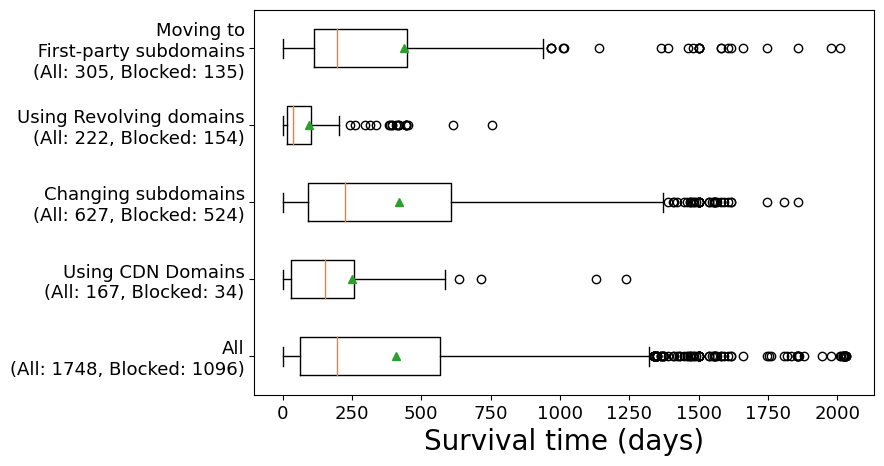

In [161]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot([ [sum(days) / len(days) for _, days in type2this_dm2days[dm_type].items()] for dm_type in ['all', 'cdn', 'subdomains', 'revolving', 'fp']], vert=False, showmeans=True)

labels = [ f"{name}\n(All: {len(type2all_this_dm[dm_type])}, Blocked: {len(type2this_dm2days[dm_type])})" 
          for dm_type, name in zip(['all', 'cdn', 'subdomains', 'revolving', 'fp'], ['All', 'Using CDN Domains', 'Changing subdomains', 'Using Revolving domains',  'Moving to\n First-party subdomains']) ]
print(labels)
ax.set_yticklabels(labels, fontsize=13)
ax.tick_params(axis='x', labelsize=13)
ax.set_xlabel("Survival time (days)", fontsize=20)
fig.savefig('figures/pattern-boxplot.pdf', bbox_inches='tight')
fig

## History

In [76]:
companion_times_df = pd.DataFrame([{
    "suspect_dm":this_dm, 
    "suspect_dm_first_appear": datetime.datetime.fromtimestamp(dm2info[this_dm]['first_appear']),
    "subdomain": this_dm in subdomains,
    "cname": this_dm in {this_dm for this_dm, ad_dm in cname_cloaking_events},
    "fp": this_dm in {dm for dm, site in this_dm_fp},
    "cdn": 'akamaihd.net' in this_dm or 'cloudfront.net' in this_dm or 'azureedge.net' in this_dm,
    "revolving": this_dm in { this_dm_ for this_dm_, _ in revolvings }
} for this_dm in { this_dm_ for this_dm_, _, _, _ in companions}],
columns=['suspect_dm', 'suspect_dm_first_appear', 'subdomain', 'cname', 'fp', 'cdn', 'revolving'])

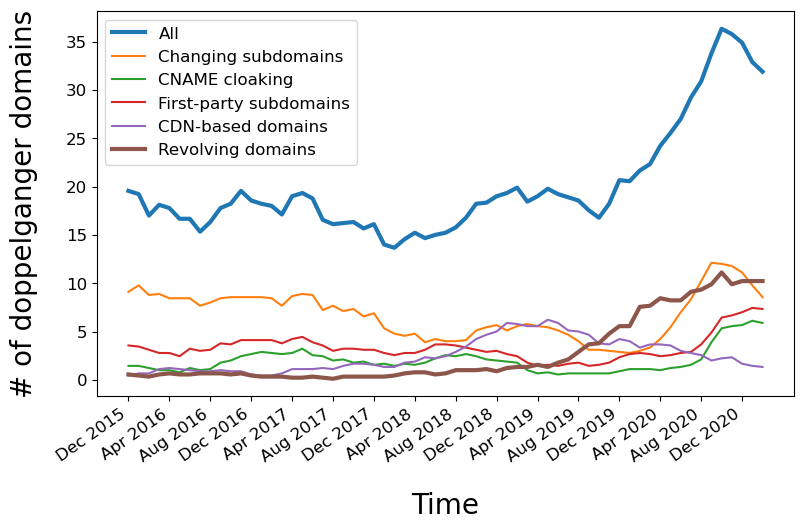

In [77]:
import calendar
figure, ax = plt.subplots(figsize=(9,5))
#ev_times = ev_times_df.groupby([ev_times_df["suspect_dm_first_appear"].dt.year, ev_times_df["suspect_dm_first_appear"].dt.month])['suspect_dm'].count().iloc[1:].rolling(window=4).mean()
#companion_times = companion_times_df.groupby([companion_times_df["suspect_dm_first_appear"].dt.year, companion_times_df["suspect_dm_first_appear"].dt.month // 4]).agg({'suspect_dm' : ['count'], 'subdomain' : ['sum'], 'cname' : ['sum'], 'fp' : ['sum'], 'cdn' : ['sum'], 'evading' : ['sum'], 'revolving' : ['sum']}).iloc[1:].rolling(window=4).mean()
companion_times = companion_times_df.groupby([companion_times_df["suspect_dm_first_appear"].dt.year, companion_times_df["suspect_dm_first_appear"].dt.month]).agg({'suspect_dm' : ['count'], 'subdomain' : ['sum'], 'cname' : ['sum'], 'fp' : ['sum'], 'cdn' : ['sum'], 'revolving' : ['sum']}).iloc[1:].rolling(window=9).mean()
ax = companion_times['suspect_dm']['count'].plot(kind="line", label="All", linewidth=3)
ax = companion_times['subdomain']['sum'].plot(kind="line", label="Changing subdomains")
ax = companion_times['cname']['sum'].plot(kind="line", label="CNAME cloaking")
ax = companion_times['fp']['sum'].plot(kind="line", label="First-party subdomains")
ax = companion_times['cdn']['sum'].plot(kind="line", label="CDN-based domains")
ax = companion_times['revolving']['sum'].plot(kind="line", label="Revolving domains", linewidth=3)
ax.set_xticks(range(companion_times.shape[0])[8::4])
ax.set_xticklabels(list(map(lambda t: f"{calendar.month_name[t[1]][:3]} {t[0]}", companion_times.index.to_list()))[8::4], rotation=35, ha='right', fontsize=12)
yticks = range(0, 35 + 1, 5)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=12)

ax.set_xlabel("Time", labelpad=20, fontsize=20)
ax.set_ylabel("# of doppelganger domains", labelpad=20, fontsize=20)
ax.legend(fontsize=12)
figure.savefig('figures/history.pdf', bbox_inches='tight')
figure

## Website Category

In [78]:
site2categories = defaultdict(lambda: set())
with open('data-collection/categories/site_to_categories.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        for c in row[1].split(','):
            site2categories[row[0]].add(c)

In [83]:
categories2first_party = defaultdict(lambda: set())
first_party2evdms = defaultdict(lambda: set())
for this_dm, _, _, _ in companions:
    for r in dm2info[this_dm]['requests']:
        if r['first_party'] not in site2categories:
            continue
        for c in site2categories[r['first_party']]:
            categories2first_party[c].add(r['first_party'])
        first_party2evdms[r['first_party']].add(this_dm)

In [84]:
key2name = {
    "business": "Business",
    "education": "Education",
    "entertainment": "Entertainment",
    "informationtech": "Information Technology",
    "newsandmedia": "News and Media",
    "shopping": "Shopping",
    "adult": "Adult",
    "travel": "Travel",
    "economyandfinance": "Economy and Finance",
    "health": "Health"
}

In [85]:
first_party_category_df = pd.DataFrame([{
    "first_party": dm,
    'category': key2name.get(cat, cat),
    "subdomain": any({evdm in subdomains for evdm in first_party2evdms[dm]}),
    "cname": any({this_dm in {this_dm for this_dm, ad_dm in cname_cloaking_events}  for this_dm in first_party2evdms[dm]}),
    "fp": any({this_dm in {this_dm for this_dm, site in this_dm_fp}  for this_dm in first_party2evdms[dm]}),
    "cdn": any({'akamaihd.net' in this_dm or 'cloudfront.net' in this_dm or 'azureedge.net' in this_dm for this_dm in first_party2evdms[dm]}),
    "revolving": any({this_dm in {this_dm_ for this_dm_, _ in revolvings}  for this_dm in first_party2evdms[dm]})
} for cat, dms in categories2first_party.items() for dm in dms],
columns=['first_party', 'category', 'subdomain', 'cname', 'fp', 'cdn', 'revolving'])

In [86]:
first_party_category_df.groupby([first_party_category_df['category']]).agg({'first_party' : ['count'], 'subdomain' : ['sum'], 'cname' : ['sum'], 'fp' : ['sum'], 'cdn' : ['sum']}).sort_values(by=[('first_party', 'count')], ascending=False)

,first_party,subdomain,cname,fp,cdn
,count,sum,sum,sum,sum
category,,,,,
Business,198,76,16,49,17
Education,111,46,7,24,8
Entertainment,67,19,5,19,13
Information Technology,57,22,5,15,5
News and Media,38,22,9,13,15
Shopping,31,12,9,13,2
Adult,14,6,2,5,0
Economy and Finance,10,7,0,1,0


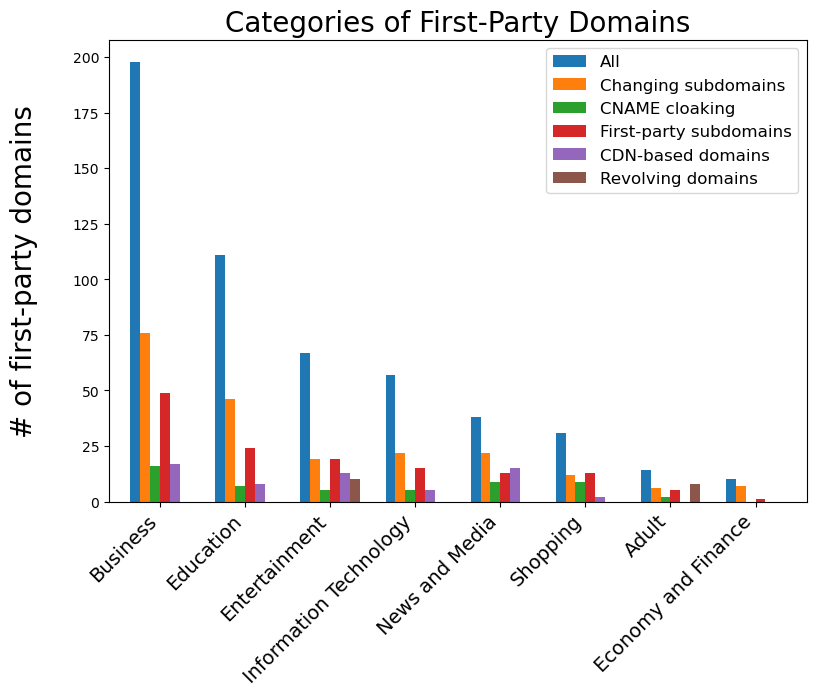

In [88]:
first_party_category = first_party_category_df.groupby([first_party_category_df['category']]).agg({'first_party' : ['count'], 'subdomain' : ['sum'], 'cname' : ['sum'], 'fp' : ['sum'], 'cdn' : ['sum'], 'revolving' : ['sum']}).sort_values(by=[('first_party', 'count')], ascending=False)

figure, ax = plt.subplots(figsize=(9,6))
ax = first_party_category.head(8).plot(kind="bar", ax=ax, width=0.7)
ax.set_title("Categories of First-Party Domains", fontsize=20)
ax.set_ylabel("# of first-party domains", labelpad=25, fontsize=20)
ax.set_xlabel("", fontsize=1)
ax.legend(["All", "Changing subdomains", "CNAME cloaking", "First-party subdomains", "CDN-based domains", "Revolving domains"], fontsize=12);
plt.xticks(np.arange(8), first_party_category.head(8).index, fontsize=14, rotation=45,ha='right')
plt.savefig('figures/categories.pdf', bbox_inches='tight', pad_inches=0)  
figure

In [184]:
"""
categories_keys = sorted(categories2evdm, key=lambda k: len(categories2evdm[k]), reverse=True)[:10]


plt.rcParams['figure.dpi'] = 300
labels = [key2name.get(n, n) for n in categories_keys]
sizes = [len(categories2evdm[n]) for n in categories_keys]
fig1, ax1 = plt.subplots(figsize=(9,6))
p = ax1.bar(np.arange(len(labels)), sizes, width=0.5)
ax1.set_title("Categories of First-Party Domains", fontsize=20)
ax1.set_ylabel("# of first-party domains", labelpad=25, fontsize=20)
plt.xticks(np.arange(len(labels)), labels, fontsize=14, rotation=45,ha='right')
ax1.bar_label(p, padding=3)
plt.savefig('figures/categories.pdf', bbox_inches='tight', pad_inches=0)  
fig1""";

## Purposes

In [108]:
dm2behavior_types = dict()

def find_behavior_types(dm):
    for d in [dm, get_ps_domain(dm)]:
        if d in dm2trackingradar:
            return set(dm2trackingradar[d]['categories'])
    return set()

for addm in {dm for dm, info in dm2info.items() if any(r['is_ad'] for r in info['requests'])} | { this_dm for this_dm, _, _, _ in companions }:
    if len(find_behavior_types(addm)) == 0:
        continue
    dm2behavior_types[addm] = find_behavior_types(addm) - { 'CDN' }

dm2behavior_types_copy = dm2behavior_types.copy()

this_dm_purpose_inference = 0
for this_dm, ad_dm, _, _ in companions:
    if this_dm not in dm2behavior_types_copy and ad_dm in dm2behavior_types_copy:
        dm2behavior_types[this_dm] = dm2behavior_types.get(this_dm, set()) | dm2behavior_types_copy[ad_dm]
    if this_dm in dm2behavior_types_copy and ad_dm not in dm2behavior_types_copy:
        dm2behavior_types[ad_dm] = dm2behavior_types.get(ad_dm, set()) | dm2behavior_types_copy[this_dm]
        
"""
for ad_dm_cluster in companions_ds.itersets():
    cluster_behavior_type = set()
    for dm in ad_dm_cluster:
        cluster_behavior_type = cluster_behavior_type | find_behavior_types(dm)
    
    if len(cluster_behavior_type) == 0:
        continue
    
    for dm in ad_dm_cluster:
        dm2behavior_types[dm] = cluster_behavior_type - { 'CDN' }

for dm in list(dm2behavior_types.keys()):
    if len(dm2behavior_types[dm]) == 0:
        del dm2behavior_types[dm]
# remove pure ad domain
for dm in list(dm2behavior_types.keys()):
    if dm not in {this_dm for this_dm, ad_dm, _ in companions}:
        del dm2behavior_types[dm]
""";

In [109]:
len({this_dm for this_dm, _, _, _ in companions} & ( set(dm2behavior_types.keys()) - set(dm2behavior_types_copy.keys()) ) )

299

5127 415 1758


<ipython-input-118-55b0cb1e3b47>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(figsize=(10, 4))


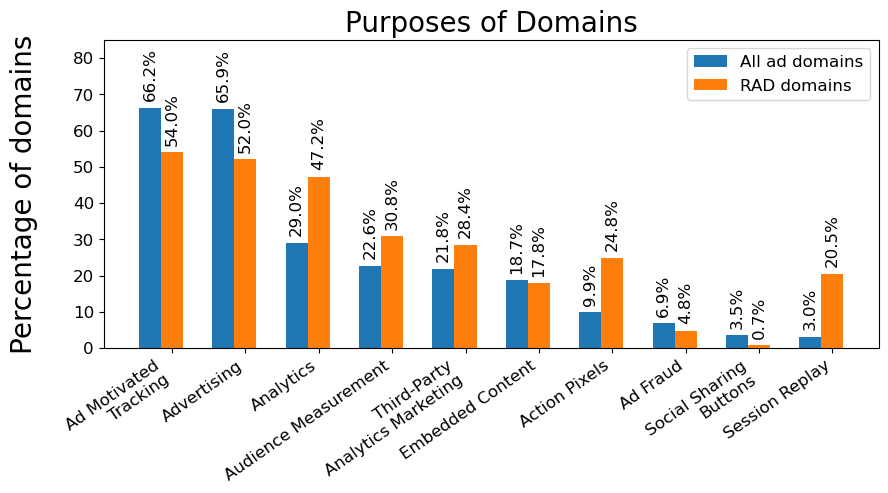

In [118]:
all_purpose_counter = Counter(v for set_ in dm2behavior_types.values() for v in set_)
cpdm_purpose_counter = Counter(v for dm in {this_dm for this_dm, _, _, _ in companions} for v in dm2behavior_types.get(dm, set()))

fp_purpose_counter = defaultdict(lambda: set())
for dm in {this_dm for this_dm, _, _, _ in companions}:
    for fp in {r['first_party'] for r in dm2info[dm]['requests'] }:
        for v in dm2behavior_types.get(dm, set()):
            fp_purpose_counter[v].add(fp)

all_dm_with_purposes = len(dm2behavior_types.keys())
cpdm_with_purposes = len({this_dm for this_dm, _, _, _ in companions} & set(dm2behavior_types.keys()))
fp_with_purposes = len({fp for fps in fp_purpose_counter.values() for fp in fps})
print(all_dm_with_purposes, cpdm_with_purposes, fp_with_purposes)

import textwrap
labels = [ c[0] for c in all_purpose_counter.most_common(10)]

fig1, ax1 = plt.subplots(figsize=(10, 4))
p_all = ax1.bar(np.arange(len(labels)) - 0.3, [ (all_purpose_counter[k] * 100 / all_dm_with_purposes)  for k in labels], width=0.3, label='All ad domains')
p_cpdm = ax1.bar(np.arange(len(labels)) + 0, [ cpdm_purpose_counter[k] * 100 / cpdm_with_purposes  for k in labels], width=0.3, label='RAD domains')
ax1.set_title("Purposes of Domains", fontsize=20)

ax1.set_ylabel("Percentage of domains", labelpad=25, fontsize=20)
ax1.set_yticks(range(0, 80 + 1, 10))
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylim(0, 85)

labels[8] = "Social Sharing Buttons"
plt.xticks(np.arange(len(labels)), labels, fontsize=12, rotation=35,ha='right')
ax1.set_xticklabels(map(lambda x: textwrap.fill(x.get_text(), 20), ax1.get_xticklabels()))

ax1.bar_label(p_all, padding=5, fontsize=12, fmt='%0.1f%%', rotation='vertical')
ax1.bar_label(p_cpdm, padding=5, fontsize=12, fmt='%0.1f%%', rotation='vertical')
ax1.legend(fontsize=12)

# ax2 = ax1.twinx()
# p_fp = ax2.bar(np.arange(len(labels)) + 0.3, [ len(fp_purpose_counter[k]) * 100 / 50_000 for k in labels], width=0.3, label='First-parties affected by RAD domains', color=[0x2c/0xff, 0xa0/0xff, 0x2c/0xff])
# ax2.bar_label(p_fp, padding=5, fontsize=12, fmt='%0.1f%%', rotation='vertical')
# ax2.set_ylabel("Percentage of first-parties", labelpad=25, fontsize=20)
# ax2.set_yticks(range(0, 80 + 1, 10))
# ax2.tick_params(axis='y', labelsize=12)
# ax2.set_ylim(0, 85)
# fig1.legend(fontsize=12, loc='upper right', bbox_to_anchor=(0.38, 0.35, 0.5, 0.5))

plt.savefig('figures/purposes.pdf', bbox_inches='tight', pad_inches=0)  
fig1

In [113]:
len(fp_purpose_counter['Ad Motivated Tracking'] ) / 50000

0.02758

In [120]:
len({dm for dm in {this_dm for this_dm, _, _, _ in companions} if len({'Ad Motivated Tracking', 'Advertising', 'Analytics'} & dm2behavior_types.get(dm, set())) > 0 })

240

In [121]:
cpdm_purpose_counter

Counter({'Analytics': 196,
         'Ad Motivated Tracking': 224,
         'Third-Party Analytics Marketing': 118,
         'Audience Measurement': 128,
         'Advertising': 216,
         'Action Pixels': 103,
         'Session Replay': 85,
         'Embedded Content': 74,
         'Ad Fraud': 20,
         'Badge': 4,
         'Online Payment': 7,
         'SSO': 7,
         'Social - Share': 3,
         'Federated Login': 1})

## Fingerprinting

In [122]:
dm2fingerprinting = dict()

def find_fingerprinting(dm):
    #for d in [dm, get_ps_domain(dm)]:
    for d in [dm, dm.lstrip('www.')]:
        if d in dm2trackingradar:
            return dm2trackingradar[d]['fingerprinting']
    return None

In [125]:
for addm in {dm for dm, info in tqdm(dm2info.items()) if any(r['is_ad'] for r in info['requests'])} | {this_dm for this_dm, ad_dm, _, _ in companions}:
    if find_fingerprinting(addm) is None:
        continue
    dm2fingerprinting[addm] = find_fingerprinting(addm)

dm2fingerprinting_copy = dm2fingerprinting.copy()

for this_dm, ad_dm, _, _ in companions:
    if this_dm not in dm2fingerprinting_copy and ad_dm in dm2fingerprinting_copy:
        dm2fingerprinting[this_dm] = min(dm2fingerprinting.get(this_dm, float('inf')), dm2fingerprinting[ad_dm])
    if this_dm in dm2fingerprinting_copy and ad_dm not in dm2fingerprinting_copy:
        dm2fingerprinting[ad_dm] = min(dm2fingerprinting.get(ad_dm, float('inf')), dm2fingerprinting[this_dm])
"""
for ad_dm_cluster in companions_ds.itersets():
    counter = Counter({ dm2fingerprinting[dm] for dm in ad_dm_cluster if dm in dm2fingerprinting })
    
    if len(counter.most_common(1)) > 0:
        for dm in ad_dm_cluster:
            dm2fingerprinting[dm] = counter.most_common(1)[0][0]
    else:
        for dm in ad_dm_cluster:
            if dm in dm2fingerprinting:
                del dm2fingerprinting[dm]
""";

  0%|          | 0/252601 [00:00<?, ?it/s]

In [149]:
len({this_dm for this_dm, _, _, _ in companions} & ( set(dm2fingerprinting.keys()) - set(dm2fingerprinting_copy.keys()) ) )

290

In [148]:
Counter(dm2fingerprinting.values()), len(dm2fingerprinting)

(Counter({0: 997, 2: 609, 1: 826, 3: 88}), 2520)

2520 395


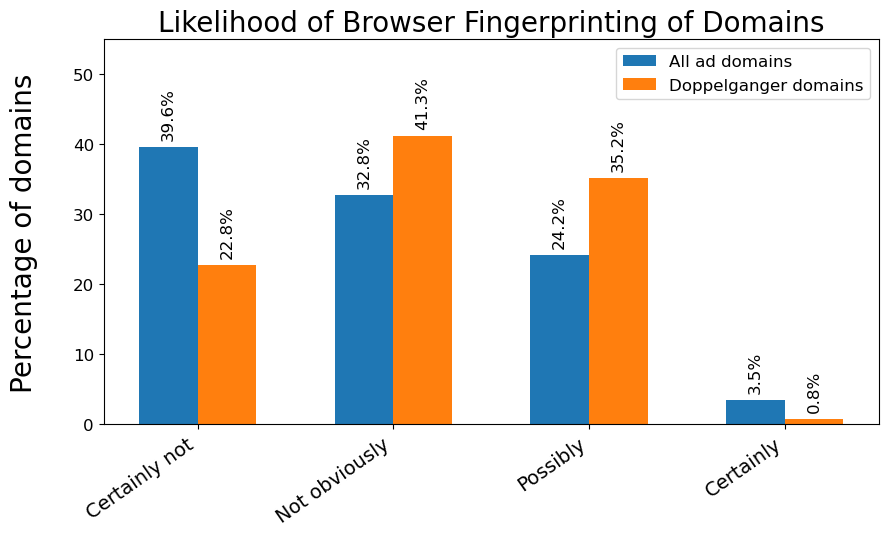

In [150]:
all_fingerprinting_counter = Counter(dm2fingerprinting.values())
cpdm_fingerprinting_counter = Counter(dm2fingerprinting[dm] for dm in {this_dm for this_dm, _, _, _ in companions} if dm in dm2fingerprinting)

all_dm_with_fingerprinting = len(dm2fingerprinting.keys())
cpdm_with_fingerprinting = len({this_dm for this_dm, _, _, _ in companions} & set(dm2fingerprinting.keys()))
print(all_dm_with_fingerprinting, cpdm_with_fingerprinting)

key2name = [
    "Certainly not",
    "Not obviously",
    "Possibly",
    "Certainly"
]
labels = [key2name[n] for n in range(0, 4)]

fig1, ax1 = plt.subplots(figsize=(10,5))
p_all = ax1.bar(np.arange(len(labels)) - 0.15, [ (all_fingerprinting_counter[k] * 100 / all_dm_with_fingerprinting)  for k in range(0, 4)], width=0.3, label='All ad domains')
p_cpdm = ax1.bar(np.arange(len(labels)) + 0.15, [ cpdm_fingerprinting_counter[k] * 100 / cpdm_with_fingerprinting  for k in range(0, 4)], width=0.3, label='Doppelganger domains')
ax1.set_title("Likelihood of Browser Fingerprinting of Domains", fontsize=20)
ax1.set_ylabel("Percentage of domains", labelpad=25, fontsize=20)
ax1.set_yticks(range(0, 51, 10))
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylim(0, 55)
plt.xticks(np.arange(len(labels)), labels, fontsize=14, rotation=35,ha='right')
ax1.bar_label(p_all, padding=5, fontsize=12, fmt='%0.1f%%', rotation='vertical')
ax1.bar_label(p_cpdm, padding=5, fontsize=12, fmt='%0.1f%%', rotation='vertical')
#ax1.bar_label(p_evdm, padding=5, fontsize=12, fmt='%0.1f%%', rotation='vertical')
ax1.legend(fontsize=12)

plt.savefig('figures/fingerprinting.pdf', bbox_inches='tight', pad_inches=0)  
fig1

In [127]:
cpdm_fingerprinting_counter

Counter({2: 139, 0: 90, 1: 163, 3: 3})

In [129]:
fingerprinting_owner2companions = defaultdict(lambda: set())
for this_dm, ad_dm, _, _ in companions:
    if dm2fingerprinting.get(this_dm, -1) < 2:
        continue
    if find_owner(this_dm, ad_dm):
        fingerprinting_owner2companions[find_owner(this_dm, ad_dm)].add(this_dm)
for owner, dms in sorted(list(fingerprinting_owner2companions.items()), key=lambda k_v: len(k_v[1]), reverse=True):
    print(owner, len(dms), dms)
    print()

"""
for ad_dm_cluster in companions_ds.itersets():
    for dm in ad_dm_cluster:
        if dm in dm2fingerprinting and dm2fingerprinting[dm] >= 2:
            print(
                ",".join({ find_owner(dm, dm) for dm in ad_dm_cluster} - {None}), 
                len(ad_dm_cluster & {this_dm for this_dm, ad_dm, _ in companions}),
                ":", 
                ad_dm_cluster & {this_dm for this_dm, ad_dm, _ in companions}
            )
            
        break
""";

Amazon.com 105 {'d1f1ahf99nq0ja.cloudfront.net', 'd25zomep54f91g.cloudfront.net', 'd3g0ljvk7a1c7r.cloudfront.net', 'dxx59zheu19y2.cloudfront.net', 'd254l5jk9au3wv.cloudfront.net', 'dycfelr1akb60.cloudfront.net', 'd3axo1kp9v29qj.cloudfront.net', 'drrv68bagxr0s.cloudfront.net', 'd19m55ur8rme4m.cloudfront.net', 'd1alzvr683o8p8.cloudfront.net', 'drkq6nhqhb8b7.cloudfront.net', 'd3terveqlssriz.cloudfront.net', 'd12tjwpuegjwrx.cloudfront.net', 'd2pz40nchl7sp2.cloudfront.net', 'dsd7ugeb97nnc.cloudfront.net', 'dd0f2wgjtus3v.cloudfront.net', 'd60r6iww29z6r.cloudfront.net', 'dvt4wxn8ibocz.cloudfront.net', 'd3lvalyq6xmerg.cloudfront.net', 'd19byj6yasb718.cloudfront.net', 'dbejeqv8nk3po.cloudfront.net', 'd3l320urli0p1u.cloudfront.net', 'd13l4u7pe64ymo.cloudfront.net', 'dfm7wh2x5l4za.cloudfront.net', 'd2c4ylitp1qu24.cloudfront.net', 'd3237rs3i095wb.cloudfront.net', 'd14qpp2he5atys.cloudfront.net', 'doi3unldljdx6.cloudfront.net', 'd8yw4927nnimu.cloudfront.net', 'dfmx20dpmctcx.cloudfront.net', 'd1z8gj

In [132]:
len({this_dm for this_dm, ad_dm in cname_cloaking_events} & {dm for dm, site in this_dm_fp} & {'local.wvgazettemail.com', 'local.nationalpost.com', 'local.sentinelsource.com', 'local.summitdaily.com', 'mylocal.mrt.com', 'local.duluthnewstribune.com', 'local.lmtribune.com', 'local.eadt.co.uk', 'local.timesleader.com', 'local.prensa.com', 'local.windomnews.com', 'local.thespec.com', 'local.bakersfield.com', 'local.greeleytribune.com', 'local.djournal.com', 'local.swnewsmedia.com', 'local.gazette.com', 'dailynewsrecord.wanderful.ownlocal.com', 'local.charlotteobserver.com', 'local.janesvillemarketplace.com', 'local.vancouversun.com', 'local.vaildaily.com', 'localfusion.secure.ownlocal.com', 'local.idahostatejournal.com', 'local.chronline.com', 'local.grandforksherald.com', 'local.northwestgeorgianews.com', 'local.calgaryherald.com', 'local.idahopress.com', 'local.yorkregion.com', 'local.lmtribune.com.local.ownlocal.com', 'local.inforum.com', 'local.brainerddispatch.com', 'widget.secure.ownlocal.com', 'local.wahpetondailynews.com'})

29

In [133]:
len({dm for dm, site in this_dm_fp} & {'local.wvgazettemail.com', 'local.nationalpost.com', 'local.sentinelsource.com', 'local.summitdaily.com', 'mylocal.mrt.com', 'local.duluthnewstribune.com', 'local.lmtribune.com', 'local.eadt.co.uk', 'local.timesleader.com', 'local.prensa.com', 'local.windomnews.com', 'local.thespec.com', 'local.bakersfield.com', 'local.greeleytribune.com', 'local.djournal.com', 'local.swnewsmedia.com', 'local.gazette.com', 'dailynewsrecord.wanderful.ownlocal.com', 'local.charlotteobserver.com', 'local.janesvillemarketplace.com', 'local.vancouversun.com', 'local.vaildaily.com', 'localfusion.secure.ownlocal.com', 'local.idahostatejournal.com', 'local.chronline.com', 'local.grandforksherald.com', 'local.northwestgeorgianews.com', 'local.calgaryherald.com', 'local.idahopress.com', 'local.yorkregion.com', 'local.lmtribune.com.local.ownlocal.com', 'local.inforum.com', 'local.brainerddispatch.com', 'widget.secure.ownlocal.com', 'local.wahpetondailynews.com'})

29

In [134]:
for dm in {'local.wvgazettemail.com', 'local.nationalpost.com', 'local.sentinelsource.com', 'local.summitdaily.com', 'mylocal.mrt.com', 'local.duluthnewstribune.com', 'local.lmtribune.com', 'local.eadt.co.uk', 'local.timesleader.com', 'local.prensa.com', 'local.windomnews.com', 'local.thespec.com', 'local.bakersfield.com', 'local.greeleytribune.com', 'local.djournal.com', 'local.swnewsmedia.com', 'local.gazette.com', 'dailynewsrecord.wanderful.ownlocal.com', 'local.charlotteobserver.com', 'local.janesvillemarketplace.com', 'local.vancouversun.com', 'local.vaildaily.com', 'localfusion.secure.ownlocal.com', 'local.idahostatejournal.com', 'local.chronline.com', 'local.grandforksherald.com', 'local.northwestgeorgianews.com', 'local.calgaryherald.com', 'local.idahopress.com', 'local.yorkregion.com', 'local.lmtribune.com.local.ownlocal.com', 'local.inforum.com', 'local.brainerddispatch.com', 'widget.secure.ownlocal.com', 'local.wahpetondailynews.com'}:
    print(dm, min([r['blocked_t'] for r in dm2info[dm]['requests'] if r['is_ad']], default=float('inf')))

local.calgaryherald.com inf
local.yorkregion.com 1485820800
local.prensa.com 1485820800
local.thespec.com 1485820800
local.northwestgeorgianews.com 1485820800
local.lmtribune.com.local.ownlocal.com 1485820800
local.chronline.com inf
local.idahopress.com 1485820800
dailynewsrecord.wanderful.ownlocal.com 1524268800
local.sentinelsource.com inf
mylocal.mrt.com 1485820800
local.vancouversun.com inf
local.timesleader.com 1485820800
local.djournal.com inf
local.charlotteobserver.com inf
local.brainerddispatch.com 1485820800
local.lmtribune.com inf
local.bakersfield.com 1485820800
local.wahpetondailynews.com 1485820800
local.gazette.com inf
local.janesvillemarketplace.com inf
local.nationalpost.com inf
local.idahostatejournal.com inf
local.swnewsmedia.com inf
localfusion.secure.ownlocal.com 1524268800
local.vaildaily.com 1485820800
local.windomnews.com 1485820800
local.eadt.co.uk inf
local.summitdaily.com 1485820800
local.duluthnewstribune.com 1485820800
local.grandforksherald.com 1485820800


In [135]:
for ad_dm_cluster in companions_ds.itersets():
    for dm in ad_dm_cluster:
        if dm in dm2fingerprinting and dm2fingerprinting[dm] == 0:
            print(",".join({ find_owner(dm, dm) for dm in ad_dm_cluster} - {None}), ":", ad_dm_cluster)
            
        break

 : {'geniuslinkcdn.com', 'cdn.geni.us', 'cdn.georiot.com'}
 : {'dadspms.com', 'aqknmbh198dn.com', 'badsans.com', 'undergiveto54.com', 'pl14474491.puserving.com', 'ye185hcamw.com', 'domicileperil.com', 'pl14318198.puserving.com', 'pictorialtears.com'}
Team Internet : {'c.parkingcrew.net', 'www.parkingcrew.net'}
Team Internet : {'js.parkingcrew.net', 'parkingcrew.net'}
 : {'heiressplane.com', 'steroidtypesconviction.com', 'wedgeenclosed.com', 'mtvp05j.com', 'basisendingabattoir.com', 'madspms.com', 'pl15792736.cpmprofitablecontent.com', 'madskiz.com', 'shockingstrategynovelty.com', 'gjw5qbyn93b8.com', 'graniteacquitcharacteristic.com', 'dpypzvjarj.com', 'revengemeantjackpot.com', 'hazardguiltconsulting.com', 'ladsans.com', 'elfcoexistbird.com', 'pl15012708.pvclouds.com', 'newmayads.com', 'ny8yoo2ro5aa.com', 'hadsokz.com', 'pl131736.puhtml.com'}
 : {'sw.wpu.sh', 'sw.wpush.org', 'gg.faromen.online', 'vasgenerete.site', 'gu7socdn.txxx.com', 'pw.wpu.sh'}
PR Newswire Association,Amazon.com : 

In [136]:
def find_revolving_owner(dm):
    for adv, dms in adv2dms.items():
        if dm in dms:
            return adv
    return None

In [137]:
revolving_with_fingerprinting = defaultdict(lambda: set())
for this_dm, ad_dm in revolvings:
    if dm2fingerprinting.get(this_dm, 0) < 2:
        continue

    if find_revolving_owner(this_dm):
        revolving_with_fingerprinting[find_revolving_owner(this_dm)].add(this_dm)
    else:
        revolving_with_fingerprinting['Unknown'].add(this_dm)
print(revolving_with_fingerprinting)
for owner, dms in sorted(list(revolving_with_fingerprinting.items()), key=lambda k_v: len(k_v[1]), reverse=True):
    print(owner, len(dms), dms)
    print()

defaultdict(<function <lambda> at 0x7fda972161f0>, {'Clickadu': {'faidoud.com', 'africaewgrhdtb.com', '2cnjuh34jbman.com', 'nicksstevmark.com', 'trtjigpsscmv9epe10.com', 'dmvbdfblevxvx.com', 'terrapsps.com', 'drjgjngf.com', 'pkhhyool.com', 'livezombymil.com'}})
Clickadu 10 {'faidoud.com', 'africaewgrhdtb.com', '2cnjuh34jbman.com', 'nicksstevmark.com', 'trtjigpsscmv9epe10.com', 'dmvbdfblevxvx.com', 'terrapsps.com', 'drjgjngf.com', 'pkhhyool.com', 'livezombymil.com'}



## File Type

In [173]:
import mimetypes
types2dm = defaultdict(lambda: list())
for this_dm in {this_dm for this_dm, _, _ in companions}:
    t = { mimetypes.guess_type(p)[0] for p in dm2info[this_dm]['paths'] if mimetypes.guess_type(p)[0] is not None}
    t_s = { mimetypes.guess_type(p)[0].split('/')[0] for p in dm2info[this_dm]['paths'] if mimetypes.guess_type(p)[0] is not None}
    
    if len(t) == 0:
        continue
    
    """for m in t_s:
        types2dm[m].append(this_dm)
    if 'application/javascript' in t:
        types2dm['JavaScript'].append(this_dm)""";
        
    
    if 'application/javascript' in t and len({'audio', 'video', 'image'} & t_s) and 'text' in t_s:
        types2dm['Javascript + Multimedia + Text'].append(this_dm)
    elif 'application/javascript' in t and len({'audio', 'video', 'image'} & t_s):
        types2dm['Javascript + Multimedia'].append(this_dm)
    elif 'application/javascript' in t and 'text' in t_s:
        types2dm['Javascript + Text'].append(this_dm)
    elif len({'audio', 'video', 'image'} & t_s) and 'text' in t_s:
        types2dm['Multimedia + Text'].append(this_dm)
    elif 'application/javascript' in t:
        types2dm['Pure Javascript'].append(this_dm)
    elif len({'audio', 'video', 'image'} & t_s) > 0:
        types2dm['Pure Multimedia'].append(this_dm)
    elif 'text' in t_s:
        types2dm['Pure Text'].append(this_dm)
    else:
        print(this_dm, t)
types2dmcount = dict(sorted(types2dm.items(), key=lambda item: len(item[1]), reverse=True))
labels = list(types2dmcount.keys())

vrt.emsecure.net {'application/x-msdos-program'}
reworldmedia.emsecure.net {'application/x-msdos-program'}
player.iltrovatore.it {'application/json'}
adexpert.ad4989.co.kr {'application/x-msdos-program'}
cloudflare.acquia.com {'font/woff'}
d.patient.media {'font/woff'}


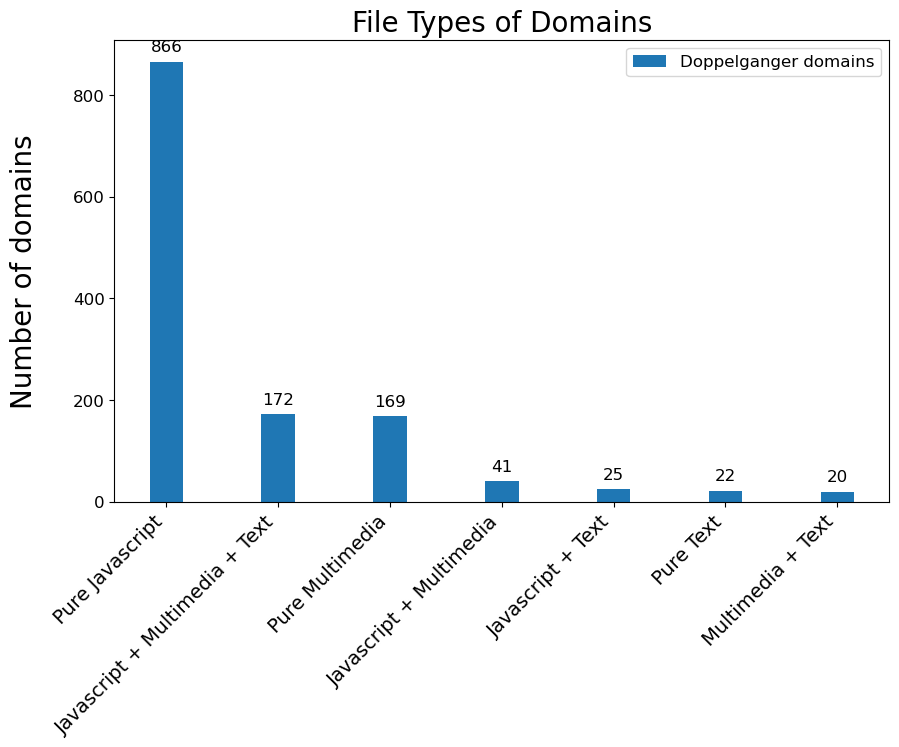

In [174]:
types2dm = dict(sorted(types2dm.items(), key=lambda item: len(item[1]), reverse=True))
labels = list(types2dm.keys())

fig1, ax1 = plt.subplots(figsize=(10,6))
t_cpdm = ax1.bar(np.arange(len(labels)), [ len(types2dm[k]) for k in labels], width=0.3, label='Doppelganger domains')
ax1.set_title("File Types of Domains", fontsize=20)
ax1.set_ylabel("Number of domains", labelpad=25, fontsize=20)
#ax1.set_yticks(range(0, 101, 10))
ax1.tick_params(axis='y', labelsize=12)
#ax1.set_ylim(0, 100)
plt.xticks(np.arange(len(labels)), labels, fontsize=14, rotation=45,ha='right')
ax1.bar_label(t_cpdm, padding=5, fontsize=12)
ax1.legend(fontsize=12)

#plt.savefig('figures/purposes.pdf', bbox_inches='tight', pad_inches=0)  
fig1

In [175]:
import mimetypes
types2dm = defaultdict(lambda: list())
for this_dm in {this_dm for this_dm, _, _ in companions}:
    t = { mimetypes.guess_type(p)[0] for p in dm2info[this_dm]['paths'] if mimetypes.guess_type(p)[0] is not None}
    t_s = { mimetypes.guess_type(p)[0].split('/')[0] for p in dm2info[this_dm]['paths'] if mimetypes.guess_type(p)[0] is not None}
    
    if len(t) == 0:
        continue
    
    for m in t_s - {"application"}:
        types2dm[m].append(this_dm)
    if 'application/javascript' in t:
        types2dm['JavaScript'].append(this_dm)
        
types2dmcount = dict(sorted(types2dm.items(), key=lambda item: len(item[1]), reverse=True))
labels = list(types2dmcount.keys())

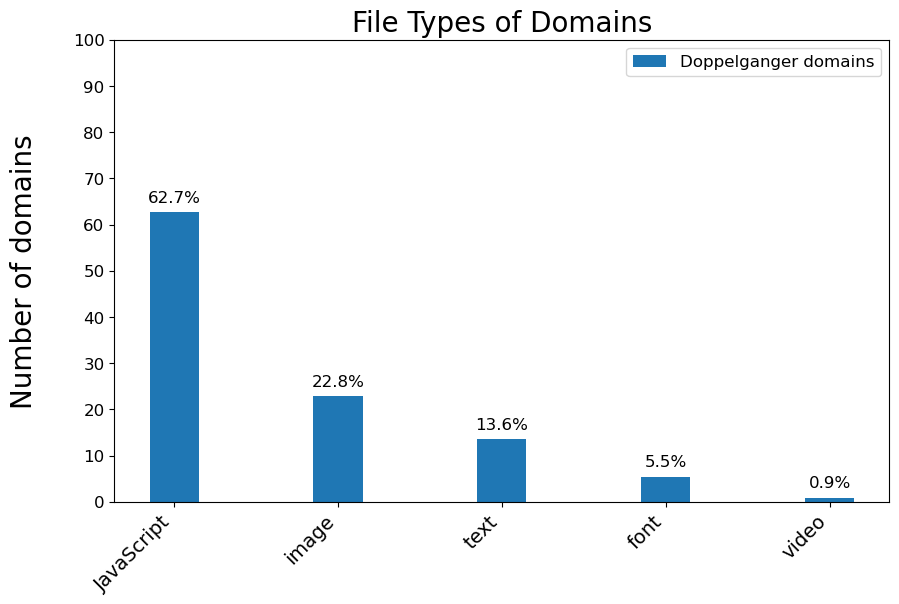

In [176]:
types2dm = dict(sorted(types2dm.items(), key=lambda item: len(item[1]), reverse=True))
labels = list(types2dm.keys())

fig1, ax1 = plt.subplots(figsize=(10,6))
t_cpdm = ax1.bar(np.arange(len(labels)), [ len(types2dm[k]) / len({this_dm for this_dm, _, _ in companions}) * 100 for k in labels], width=0.3, label='Doppelganger domains')
ax1.set_title("File Types of Domains", fontsize=20)
ax1.set_ylabel("Number of domains", labelpad=25, fontsize=20)
ax1.set_yticks(range(0, 101, 10))
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylim(0, 100)
plt.xticks(np.arange(len(labels)), labels, fontsize=14, rotation=45,ha='right')
ax1.bar_label(t_cpdm, fmt='%0.1f%%', padding=5, fontsize=12)
ax1.legend(fontsize=12)

#plt.savefig('figures/purposes.pdf', bbox_inches='tight', pad_inches=0)  
fig1

## Prevalence

In [139]:
print('companion: number of first-party: ', len({ r['first_party'] for this_dm, _, _, _ in companions for r in dm2info[this_dm]['requests'] }))
print('companion: number of first-party in top 10k: ', len(set(top20k[:10000]) & { r['first_party'] for this_dm, _, _, _ in companions for r in dm2info[this_dm]['requests'] }))
print('revolving: number of first-party: ', len({ r['first_party'] for this_dm, _ in revolvings for r in dm2info[this_dm]['requests'] }))

companion: number of first-party:  5121
companion: number of first-party in top 10k:  1068
revolving: number of first-party:  294


## Discovery Method Discussion

In [140]:
this_dm2sim_path_len = dict()
for this_dm in tqdm({this_dm for this_dm, _, _, _ in companions}):
    sim_path_lens = []
    for tdm, ad_dm, sim_paths, _ in companions:
        if tdm != this_dm or len(sim_paths) == 0:
            continue
        sim_path_lens.append(np.mean([ len(p[0]) for p in sim_paths if p[1] <= 1024 ]))
    
    if len(sim_path_lens) > 0:
        this_dm2sim_path_len[this_dm] = np.mean(sim_path_lens) 
np.mean(list(this_dm2sim_path_len.values()))

  0%|          | 0/1748 [00:00<?, ?it/s]

14.713327349358835

In [141]:
this_dm2sim_path_seg_len = dict()
for this_dm in tqdm({this_dm for this_dm, _, _, _ in companions}):
    sim_path_lens = []
    for tdm, ad_dm, sim_paths, _ in companions:
        if tdm != this_dm or len(sim_paths) == 0:
            continue
        sim_path_lens.append(np.mean([ p[0].count('/') + 1 for p in sim_paths if p[1] <= 1024 ]))
    
    if len(sim_path_lens) > 0:
        this_dm2sim_path_seg_len[this_dm] = np.mean(sim_path_lens) 
np.mean(list(this_dm2sim_path_seg_len.values()))

  0%|          | 0/1748 [00:00<?, ?it/s]

2.710389704776943

In [142]:
revdm2is_file_linked = dict()
for this_dm in tqdm({this_dm for this_dm, _ in revolvings}):
    r = False
    for tdm, ad_dm, sim_paths, file_jc_sim in companions:
        if tdm == this_dm or not file_jc_sim:
            continue
        r = True
    revdm2is_file_linked[this_dm] = r
sum(revdm2is_file_linked.values()), len({this_dm for this_dm, _ in revolvings})

  0%|          | 0/222 [00:00<?, ?it/s]

(222, 222)

In [143]:
revdm2is_file_linked = dict()
for this_dm, ad_dm, sim_paths, file_jc_sim in companions:
    if this_dm not in {this_dm for this_dm, _ in revolvings}:
        continue
    revdm2is_file_linked[this_dm] = (file_jc_sim and len([p for p in sim_paths if p[1] <= 1024]) == 0)
sum(revdm2is_file_linked.values()), len({this_dm for this_dm, _ in revolvings})

(61, 222)

In [144]:
file_linked_this_dm2_file_served_amt = {}
for this_dm in tqdm({this_dm for this_dm, _, _, file_jc_sim in companions if file_jc_sim}):
    file_linked_this_dm2_file_served_amt[this_dm] = len(dm2info[this_dm]['paths'])
np.mean(list(file_linked_this_dm2_file_served_amt.values())),\
sum([ 1 if p == 1 else 0 for p in file_linked_this_dm2_file_served_amt.values() ]),\
len(file_linked_this_dm2_file_served_amt)

  0%|          | 0/387 [00:00<?, ?it/s]

(1.6511627906976745, 335, 387)

In [147]:
len({ this_dm for this_dm, fs in file_linked_this_dm2_file_served_amt.items() if fs <= 1 } & {this_dm for this_dm, _ in revolvings})

57

In [146]:
for this_dm, ad_dm, _, file_jc_sim in companions :
    if not file_jc_sim:
        continue
    if "podfdch.com" in this_dm or "yyjvimo.com" in this_dm or "lmyiwaakn.com" in this_dm:
        continue
    if len(dm2info[this_dm]['paths'] | dm2info[ad_dm]['paths']) == 2:
        print(this_dm, ad_dm, dm2info[this_dm]['paths'], dm2info[ad_dm]['paths'])

qtjscx.com tcrybv.com {'/zhql17/912ilv/m0py03hq8/786vqu/786kpy0hk.php'} {'/ut417l219ilvpm003yh8q876/quv867pykiow1.php'}
qtjscx.com jvljpv.com {'/zhql17/912ilv/m0py03hq8/786vqu/786kpy0hk.php'} {'/mn9l17912/ilvpm003y/oln/786/vqu768kypc01r'}
qtjscx.com qakdki.com {'/zhql17/912ilv/m0py03hq8/786vqu/786kpy0hk.php'} {'/i2dl71/921livp0m30yh8q/867vuq/768kypph1zo.php'}
qtjscx.com inpiza.com {'/zhql17/912ilv/m0py03hq8/786vqu/786kpy0hk.php'} {'/mn9l17912/ilvpm003y/oln/786/vqu768kypc01r'}
qtjscx.com umcbbt.com {'/zhql17/912ilv/m0py03hq8/786vqu/786kpy0hk.php'} {'/pjfl17/921vlip0my30q8h786vqu/867ykpev.php'}
qtjscx.com eadgxy.com {'/zhql17/912ilv/m0py03hq8/786vqu/786kpy0hk.php'} {'/mn9l17912/ilvpm003y/oln/786/vqu768kypc01r'}
qtjscx.com kbtzxl.com {'/zhql17/912ilv/m0py03hq8/786vqu/786kpy0hk.php'} {'/mn9l17912/ilvpm003y/oln/786/vqu768kypc01r'}
qtjscx.com tpjsqt.com {'/zhql17/912ilv/m0py03hq8/786vqu/786kpy0hk.php'} {'/mn9l17912/ilvpm003y/oln/786/vqu768kypc01r'}
qtjscx.com bveyge.com {'/zhql17/912ilv/m0py

## Experimental

In [102]:
def func(url):
    try:
        return urlparse(url).netloc
    except:
        return None
len(set([ func(url) for url in url2response.keys()]) - set([None]))

310535

In [103]:
domain_contains_t = set()
for k, v in tqdm(dm2info.items()):
    for r in v['requests']:
        if '&t=' in r["url"].query or r["url"].query.startswith('t='):
            domain_contains_t.add(k)
            break
print(len(domain_contains_t))

  0%|          | 0/252601 [00:00<?, ?it/s]

6834


In [104]:
all_path_trie.getMaxSubpath('/js'), all_path_trie.getMaxSubpath('/static'), all_path_trie.getMaxSubpath('/site_media')

((['', 'js'], 23830), (['', 'static'], 8524), (['', 'site_media'], 28))

In [101]:
url2response = pickle.loads(Path('./data/url2response.pickle').read_bytes())

In [106]:
for this_dm, ad_dm, sim_paths, _ in companions:
    if len(sim_paths) > 0:
        continue
    if len(dm2info[this_dm]['paths']) != 1 and len(dm2info[ad_dm]['paths']):
        print(this_dm, ad_dm, dm2info[this_dm]['paths'], dm2info[ad_dm]['paths'])

joshdev.com cashinme.com {'/px.js', '/'} {'/req/3811'}
joshdev.com fastdlr.com {'/px.js', '/'} {'/'}
joshdev.com marphezis.com {'/px.js', '/'} {'', '/img.aspx', '/XddWZ/', '/ZXZRi/', '/TneeZ/', '/cpWTV/TneeZ/', '/XlLeZ/', '/', '/TZlOZ/', '/PglgZ/'}
try.sometimesfree.biz vogo-vogo.ru {'/c.php', '/pop.php'} {'/ukrmin.js', '/3ba6c1e7714f2aa17295360d16509996.js'}
try.sometimesfree.biz ssl.cdn.odinkod.ru {'/c.php', '/pop.php'} {'/tags/16990541-05999e.js', '/tags/6578524-40fd30.js'}
try.sometimesfree.biz www.tracc.it {'/c.php', '/pop.php'} {'/js/ti.js'}
try.sometimesfree.biz engine.turboroller.ru {'/c.php', '/pop.php'} {'/Script'}
try.sometimesfree.biz js.clickequations.net {'/c.php', '/pop.php'} {'/CLEQ_A7EDBA14.js'}
try.sometimesfree.biz oriondigital.ru {'/c.php', '/pop.php'} {'/ad/adorion.js'}
try.sometimesfree.biz adv-first.ru {'/c.php', '/pop.php'} {'/code/bshow.php'}
try.sometimesfree.biz ad.arklm.com {'/c.php', '/pop.php'} {'/vm/ads.js'}
try.sometimesfree.biz gjh.newsportal4.ru {'/c.p